In [6]:
import rasterio
import rasterio.mask
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

AUTOCORRELAÇÃO ESPACIAL DE AMOSTRAS

Funções

In [7]:
def autocorrelation(clipped_raster,title, target_correlation = 0.4, plot = False):
    
    shape = np.shape(clipped_raster)
    n_col =  shape[1]
    n_row =  shape[0]
    data =  clipped_raster
    
    # Convolving mask
    k1 = min(int(n_col / 3) + 2, 20) #mask extention Ydim 
    k2 = min(int(n_row / 3) + 2, 20) #mask extention Xdim


    # Statistic of valid pixels
    mean = np.mean(data[data >= 0])
    n_valid_pixels = np.count_nonzero(data[data >= 0])
    # 
    C = np.zeros((k1, k2))
    te = np.zeros((k1, k2), dtype=int)

    for i in range(1, k1 + 1):
        for j in range(1, k2 + 1):
            for k in range(n_col - i + 1):
                for l in range(n_row - j + 1):
                    lj = (l * n_col) + k
                    temp = lj + ((j - 1) * n_col) + i - 1
                    if data.flat[lj] >= 0 and data.flat[temp] >= 0:
                        C[i-1, j-1] += (data.flat[lj] - mean) * (data.flat[temp] - mean)
                        te[i-1, j-1] += 1

    # Normalização da correlação
    var = C[0, 0]/n_valid_pixels
                        
    norm_factor = (te * var) # normalization factor
    R = C/norm_factor     

    hh = np.concatenate([np.flip(R[:k1, 0]), R[1:k1, 0]])
    vv = np.concatenate([np.flip(R[0, :k2]), R[0, 1:k2]])
    
    #print(hh)
    #print(vv)
    min_lag_h, _ = find_nearest(hh,  target_correlation)
    min_lag_v, _ = find_nearest(vv,  target_correlation)

    
    if plot:
        
        plt.style.use('dark_background')
        lags_h = np.arange(1 - k1, k1)
        lags_v = np.arange(1 - k2, k2)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(lags_h, hh,'x-', color='white')
        plt.axhline(y=target_correlation, color='r', linestyle='--')
        plt.axvline(x=min_lag_h, color='yellow', linestyle='--')
        plt.title(f'{title} - Horizontal')
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")

        plt.subplot(1, 2, 2)
        plt.plot(lags_v, vv,'x-', color='white')
        plt.axhline(y=target_correlation, color='r', linestyle='--')
        plt.axvline(x=min_lag_v, color='yellow', linestyle='--')
        plt.title(f'{title} - Vertical')
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")

        plt.tight_layout()
        plt.show()

    
    return(min_lag_h, min_lag_v)
   

In [8]:
def find_nearest(array, value):
    center = len(array)//2
    for i in range(center, len(array)):
        if array[i] < value:
            return i - center, array[i]  # Retorna o lag e o valor
    return None, None 

In [9]:
def extrair_dados_raster(polygon, raster_path, banda):
    """
    Extrai os dados raster de um dado polígono.
    """
    
    with rasterio.open(raster_path) as src:
        
        # Verificar se o polígono é válido
        if not polygon.is_valid:
            print("Polígono inválido encontrado.")
            return None

        try:
            masked_img, _ = rasterio.mask.mask(src, [polygon], crop=True, all_touched=True, indexes=banda)
            return masked_img.squeeze()
        except ValueError as e:
            print(f"Erro ao processar o polígono: {e}")
            return None

In [10]:
def calculate_iqr(lags):
    q1 = np.percentile(lags, 25)
    q3 = np.percentile(lags, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    # Identifica valores que são não outliers e estão dentro dos limites
    non_outliers = [x for x in lags if lower_bound <= x <= upper_bound]
    
    return non_outliers

def find_max_lag_without_outliers(lags, IQR = True):
    if IQR:
        non_outliers = calculate_iqr(lags)
        max_lag = max(non_outliers) if non_outliers else None
    else:
        max_lag = np.max(lags)
    return max_lag

In [11]:
def bounding_box(shapefile_path, output_path, nome = None):
    # Carregar o arquivo shapefile original
    gdf = gpd.read_file(shapefile_path)
    
    # Criar uma nova GeoDataFrame para os polígonos externos
    gdf_bbox = gdf.copy()
    
    # Calcular o menor polígono externo para cada polígono
    gdf_bbox['geometry'] = gdf.geometry.apply(lambda x: x.envelope)
    
    # Salvando o novo shapefile
    gdf_bbox.to_file(output_path+nome)


Clippando imagem com vetor original

In [38]:
raster_path = 'G:/Meu Drive/INPE/projeto_dissertacao/0_images/1_processed_images/0_SAR/2010/REC_2010_ALPSRP234707120_Cal_ML_Spk5_DSk_TC_modificado_aligned.TIF'
shapefile_path = 'G:/Meu Drive/INPE/projeto_dissertacao/samples_design/reis_vec_samples/Amostras/amostras_2010.shp'
out_path = 'G:/Meu Drive/INPE/projeto_dissertacao/samples_design/reis_vec_samples/raster/image_clipped_by_polygons/'

In [35]:
shapes = gpd.read_file(shapefile_path)
geoms = [feature["geometry"] for _, feature in shapes.iterrows()]

In [39]:
nome = 'REC_2010_ALPSRP234707120_Cal_ML_Spk5_DSk_TC_modificado_aligned_clipped_by_polygons.TIF'

In [40]:
bandas_recortadas = []

with rasterio.open(raster_path) as src:
    meta = src.meta.copy()
    for b in range(1, src.count + 1):  # Loop através de cada banda
        # Recorte a banda com os vetores do shapefile
        banda_recortada, _ = mask(src, geoms, crop=False, indexes=b, invert=False, filled=True, nodata=-1)
        # Atribua o valor de -9999 para os pixels fora do recorte
        banda_recortada[banda_recortada == src.nodata] = -9999
        # Adicione a banda recortada à lista
        bandas_recortadas.append(banda_recortada)

# Empilhe as bandas recortadas
imagem_final = np.concatenate(bandas_recortadas)

# Atualize as metadados para refletir o número de bandas
meta.update(count=len(bandas_recortadas))

with rasterio.open(out_path + nome, 'w', **meta) as dest:
    for idx, banda in enumerate(bandas_recortadas, start=1):
        dest.write(banda, idx)

In [16]:
bounding_box(shapefile_path, out_path, nome = 'amostras_2010_bb.shp' )

Importando imagem clipada e bouding boxes

In [41]:
masked_raster_path = out_path + nome
bounding_boxes_path = out_path + 'amostras_2010_bb.shp'
print(masked_raster_path)
print(bounding_boxes_path)

G:/Meu Drive/INPE/projeto_dissertacao/samples_design/reis_vec_samples/raster/image_clipped_by_polygons/REC_2010_ALPSRP234707120_Cal_ML_Spk5_DSk_TC_modificado_aligned_clipped_by_polygons.TIF
G:/Meu Drive/INPE/projeto_dissertacao/samples_design/reis_vec_samples/raster/image_clipped_by_polygons/amostras_2010_bb.shp


In [28]:
df_boundings = gpd.read_file(bounding_boxes_path)
df_boundings.shape

(127, 4)

Processameto banda 1
Processando classe AP.


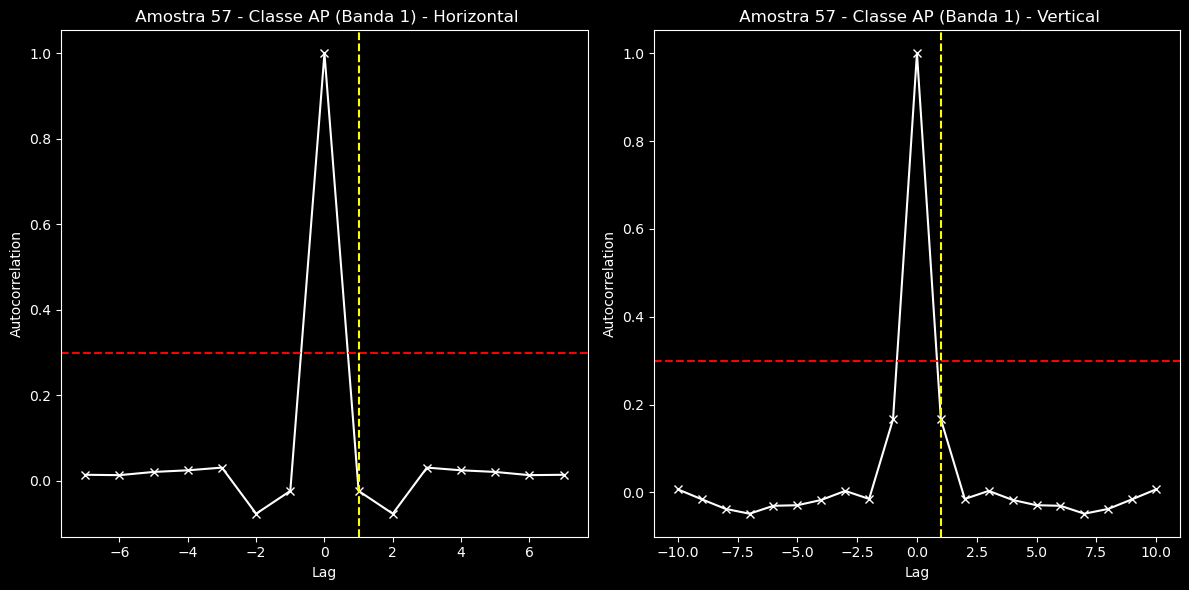

Erro ao calcular lags do polígono 99: '>' not supported between instances of 'float' and 'NoneType'


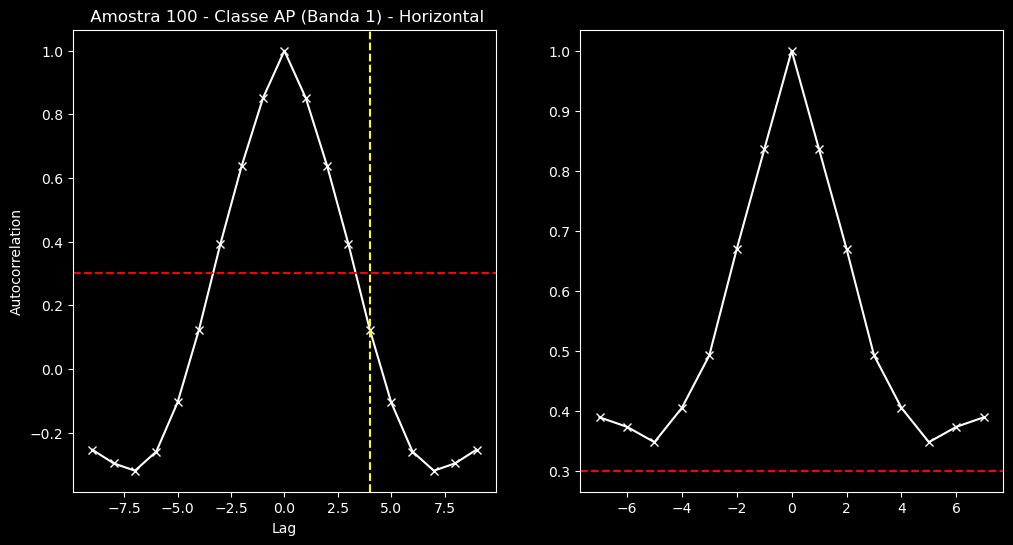

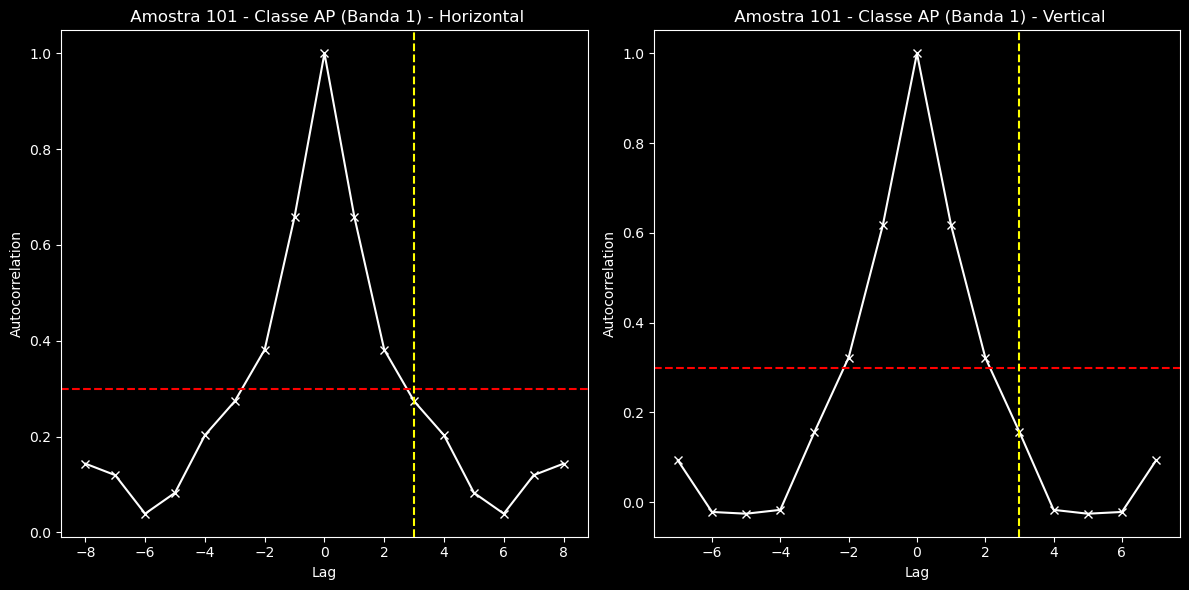

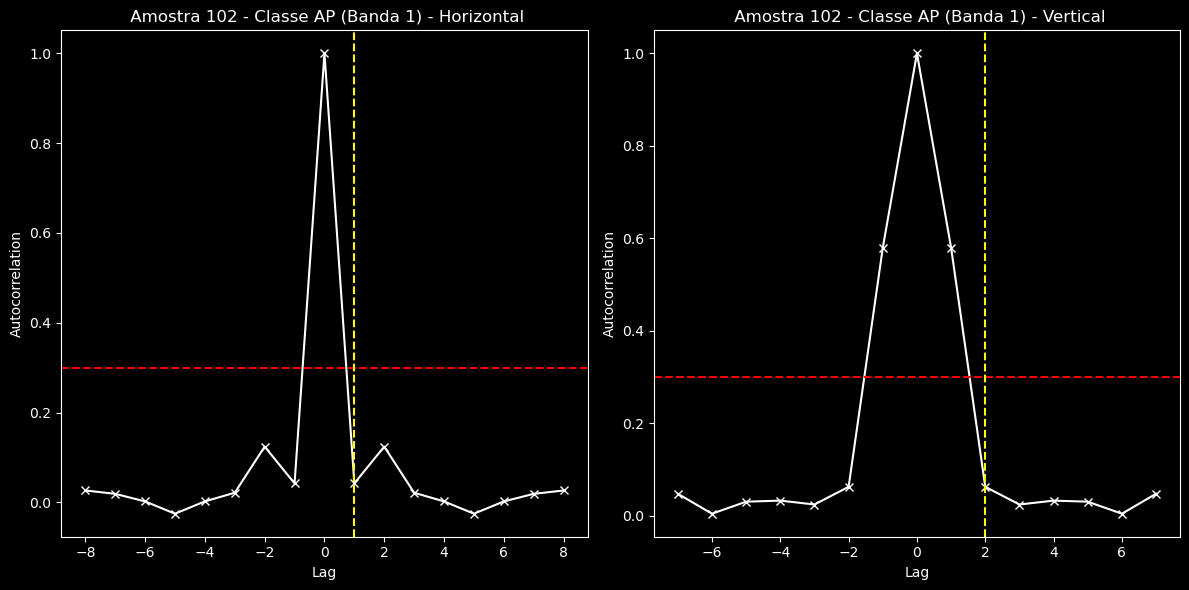

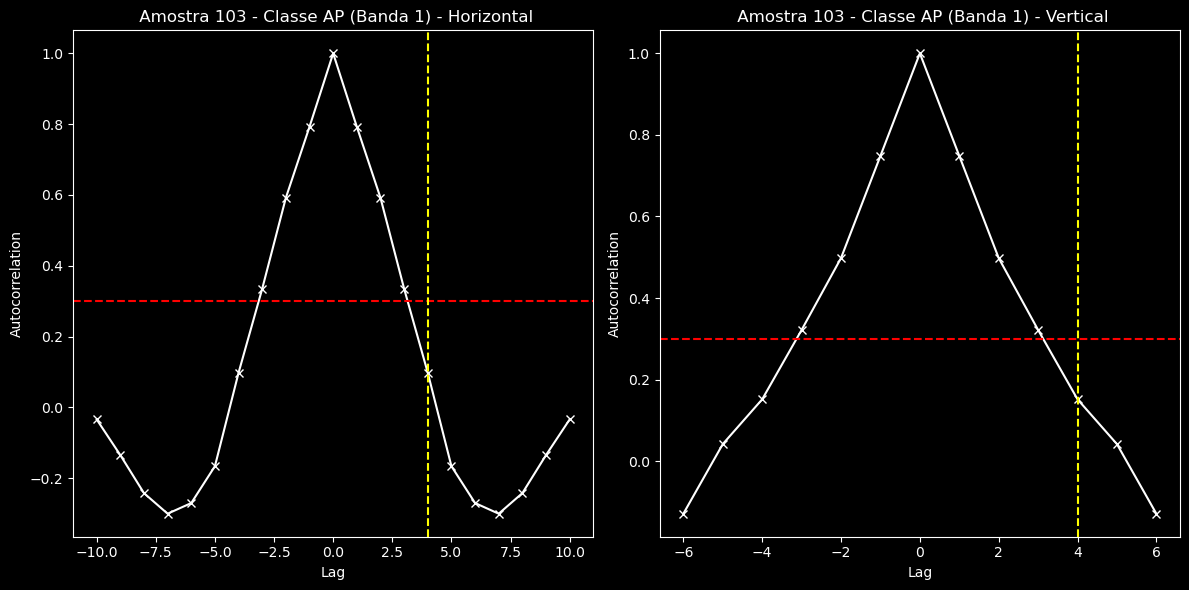

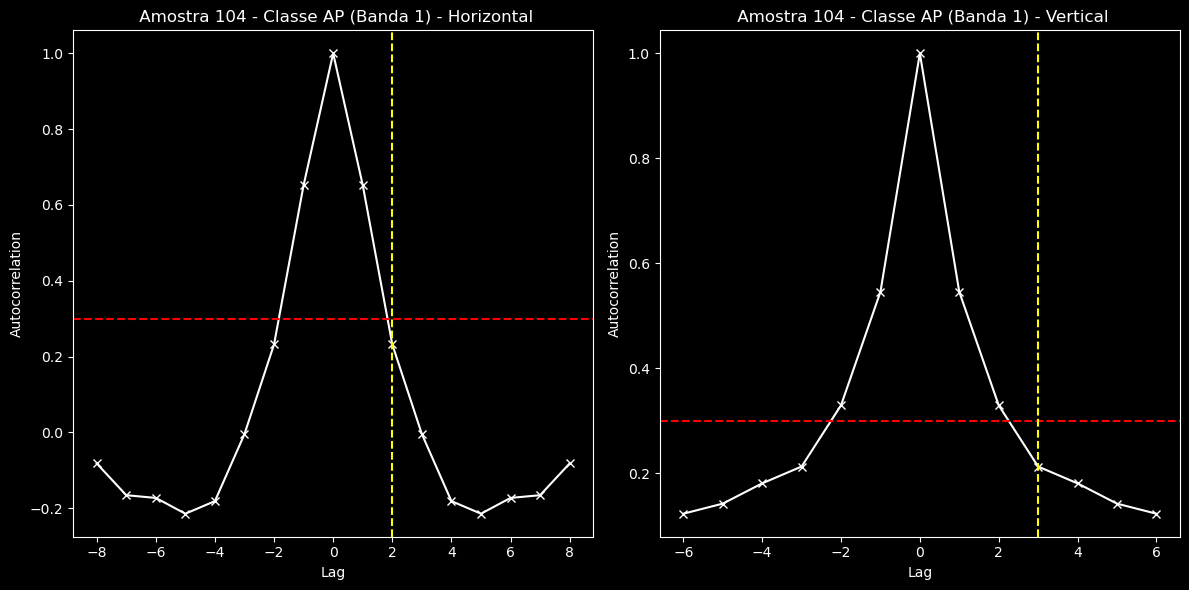

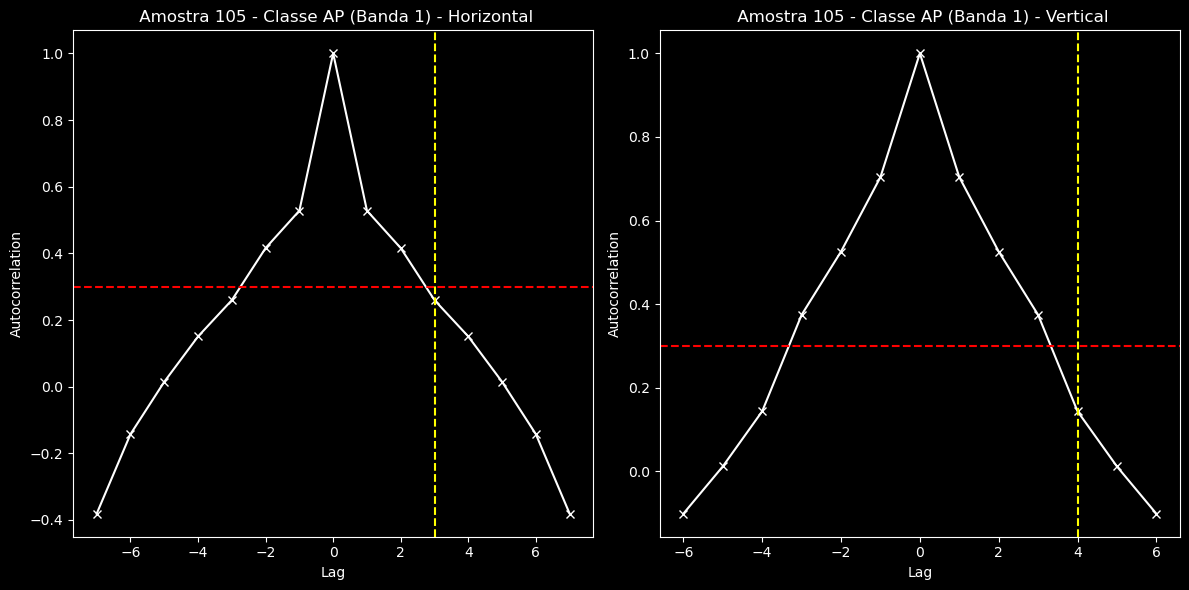

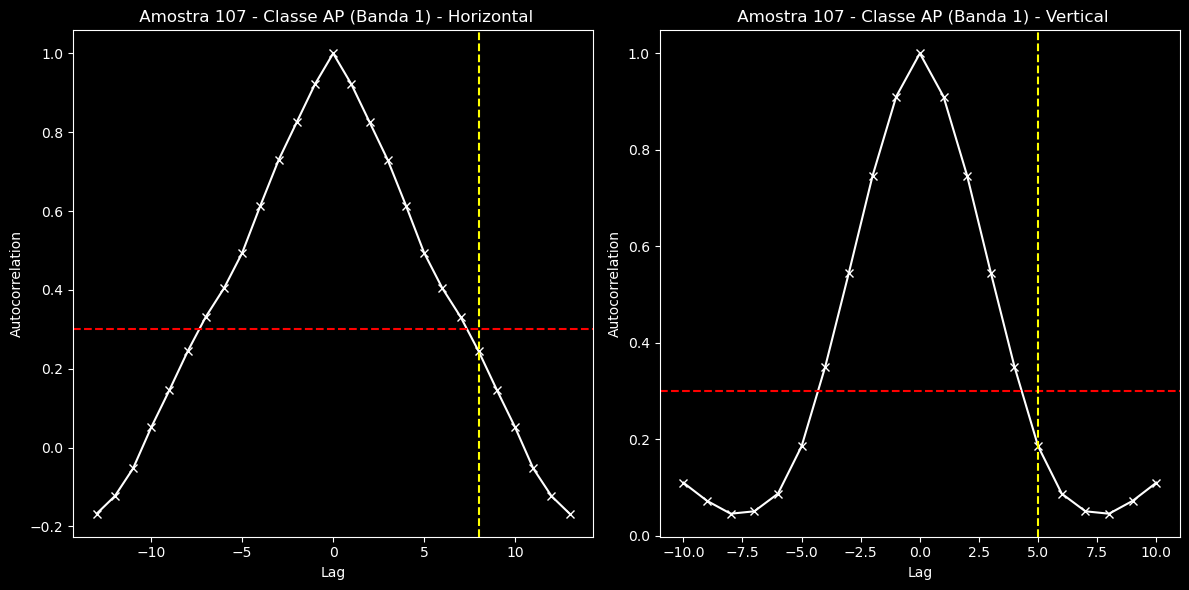

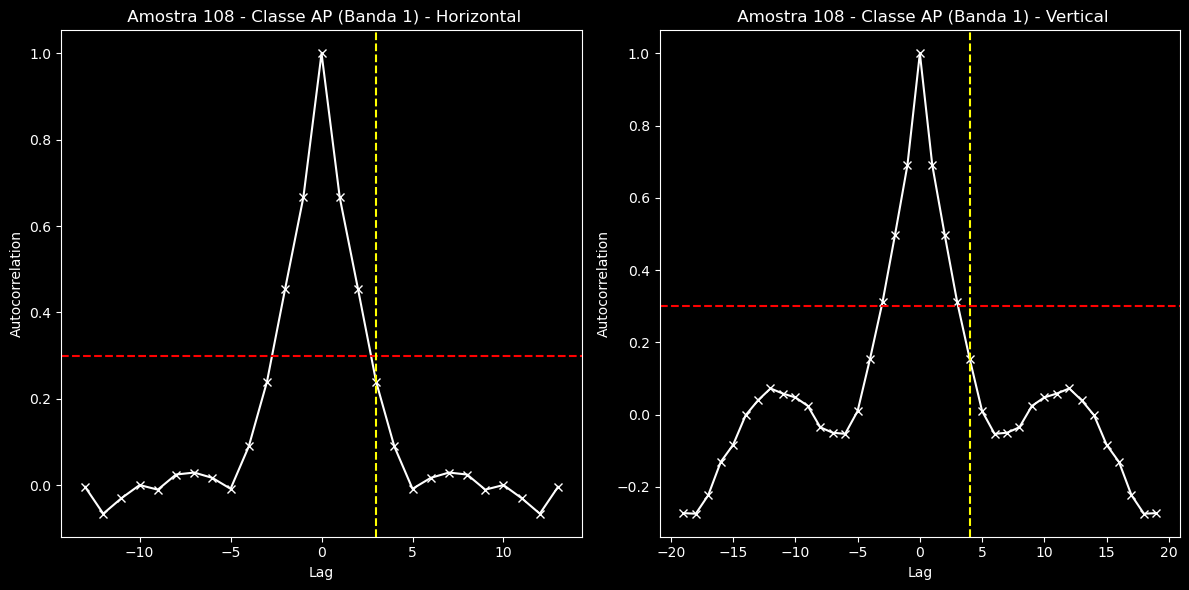

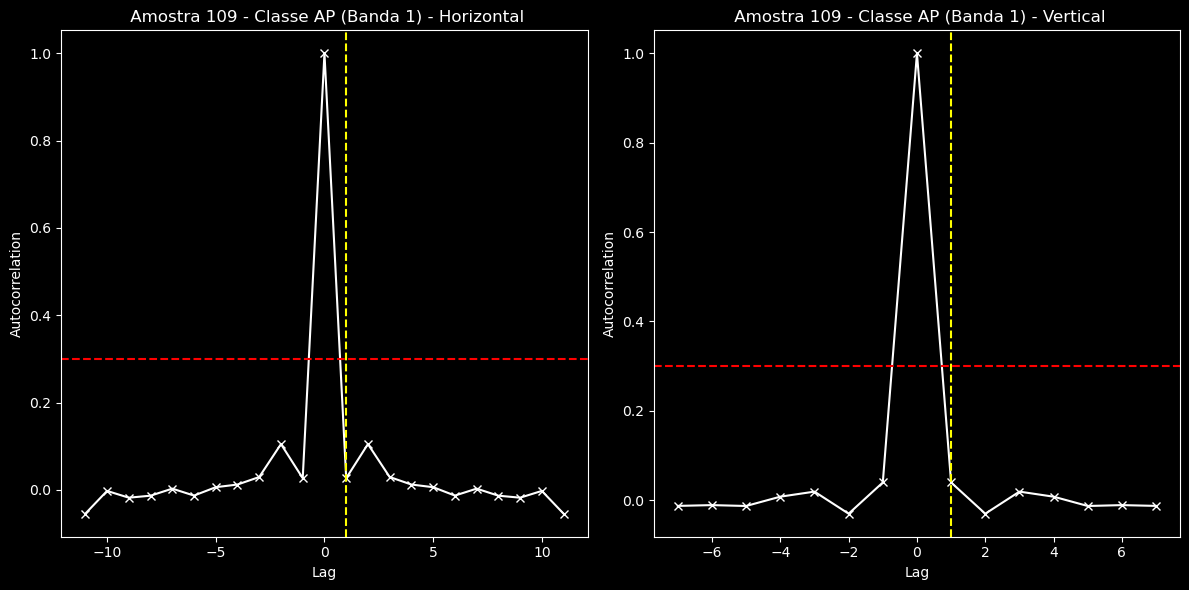

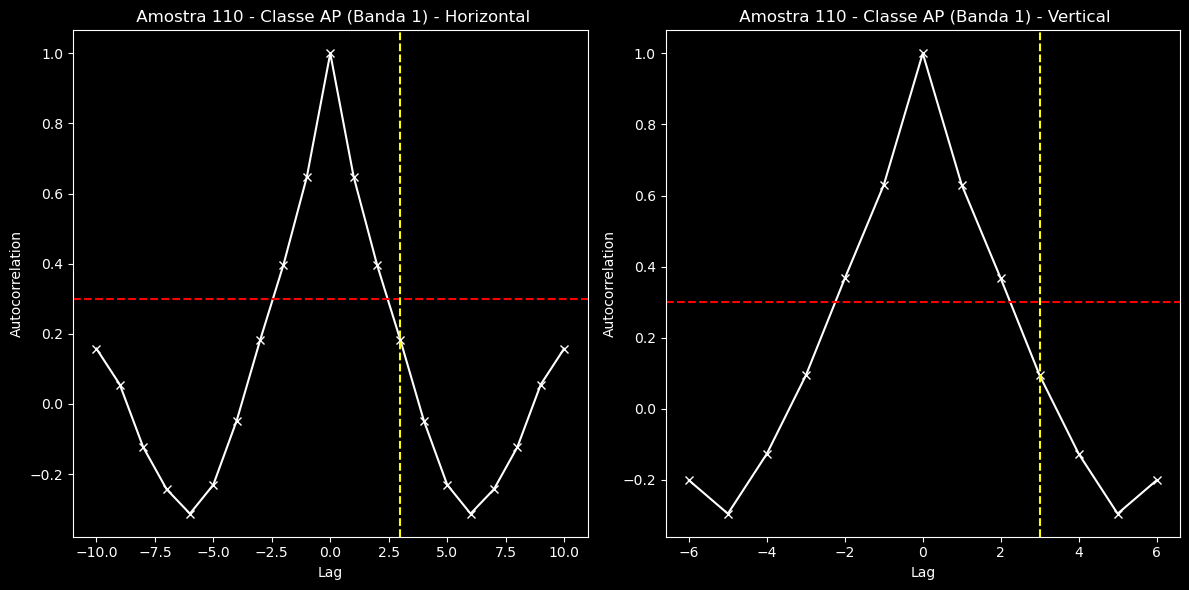

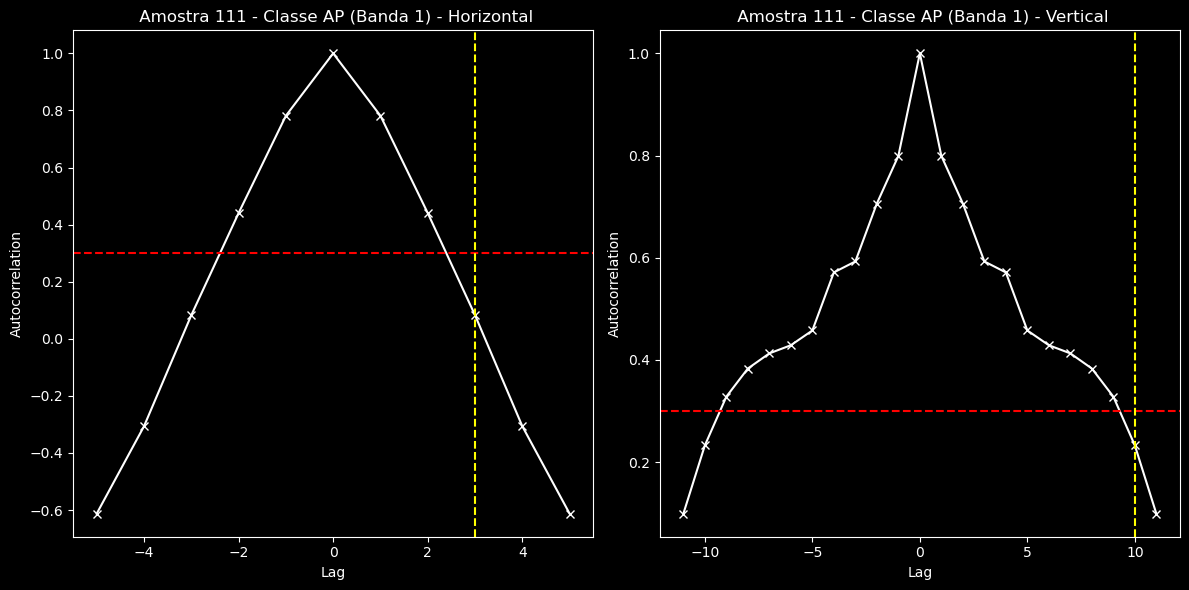

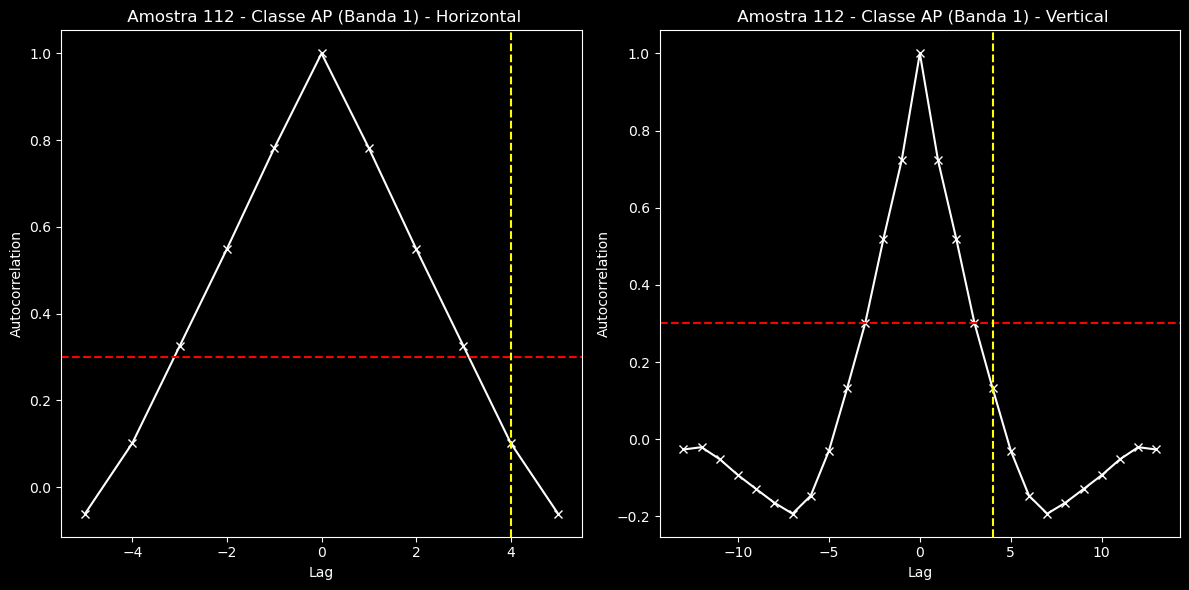

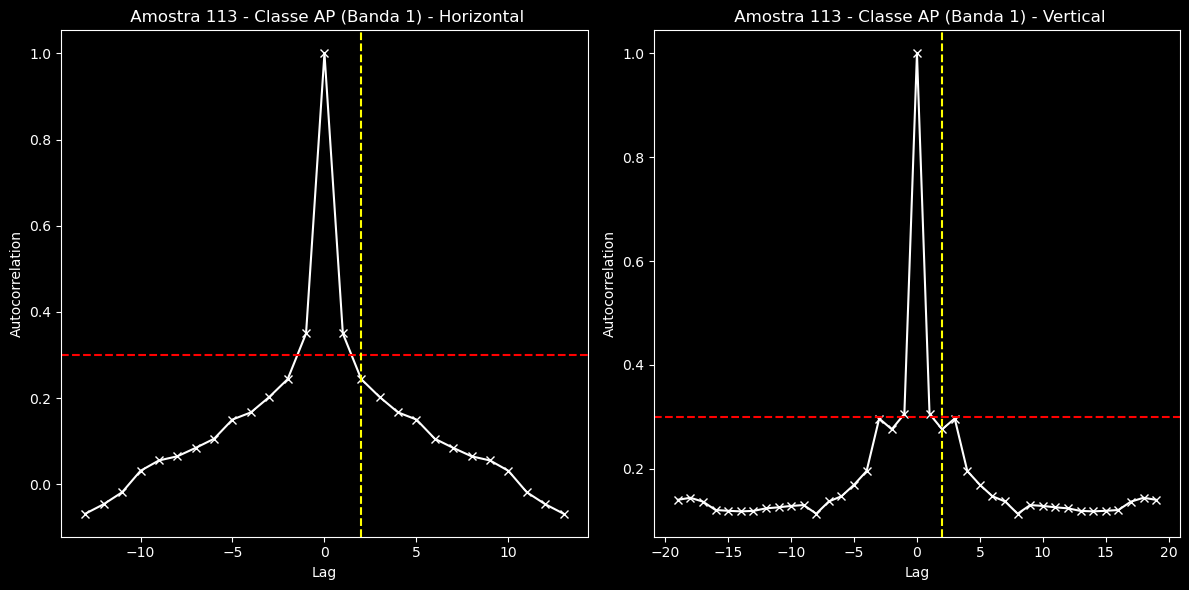

Lags Horizontais [1, 3, 1, 4, 2, 3, 8, 3, 1, 3, 3, 4, 2]
Lags Verticais [1, 3, 2, 4, 3, 4, 5, 4, 1, 3, 10, 4, 2]
Lag mediano horizontal para a classe AP: 3.0
Lag máximo horizontal para a classe AP: 4
Lag mediano vertical para a classe AP: 3.0
Lag máximo vertical para a classe AP: 5
-----------------------------------------------------------------------------------
Processando classe CL.


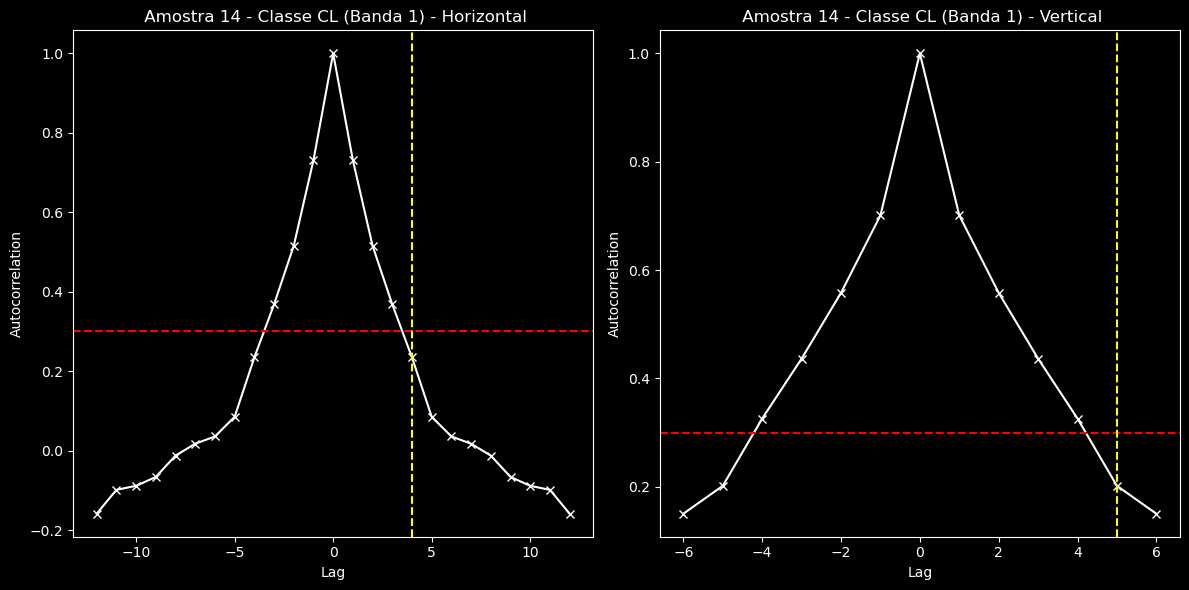

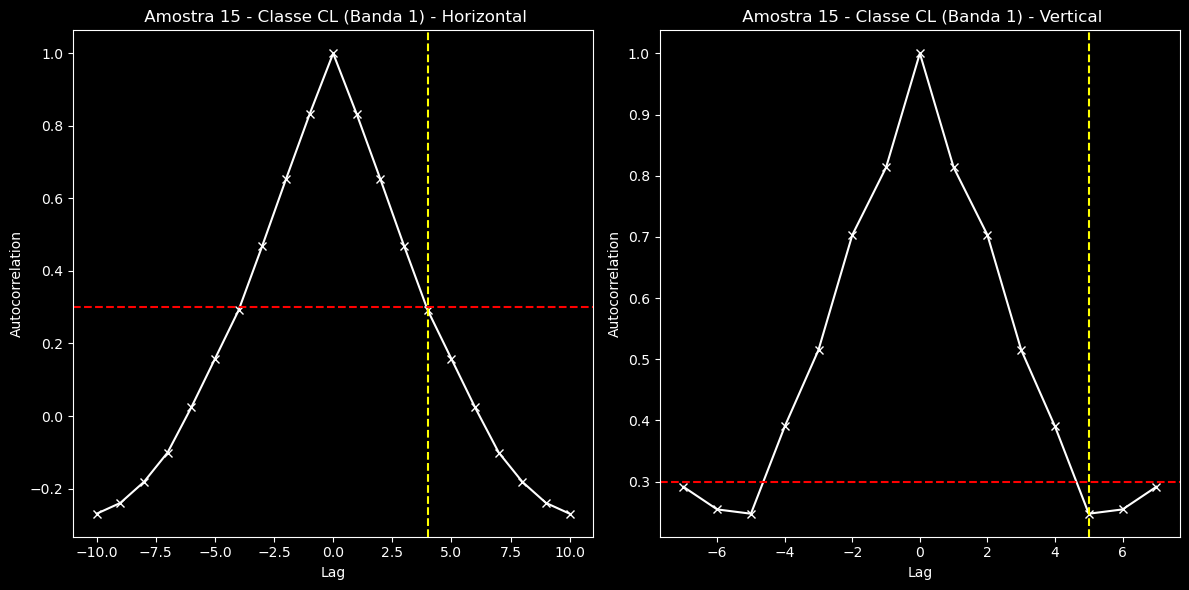

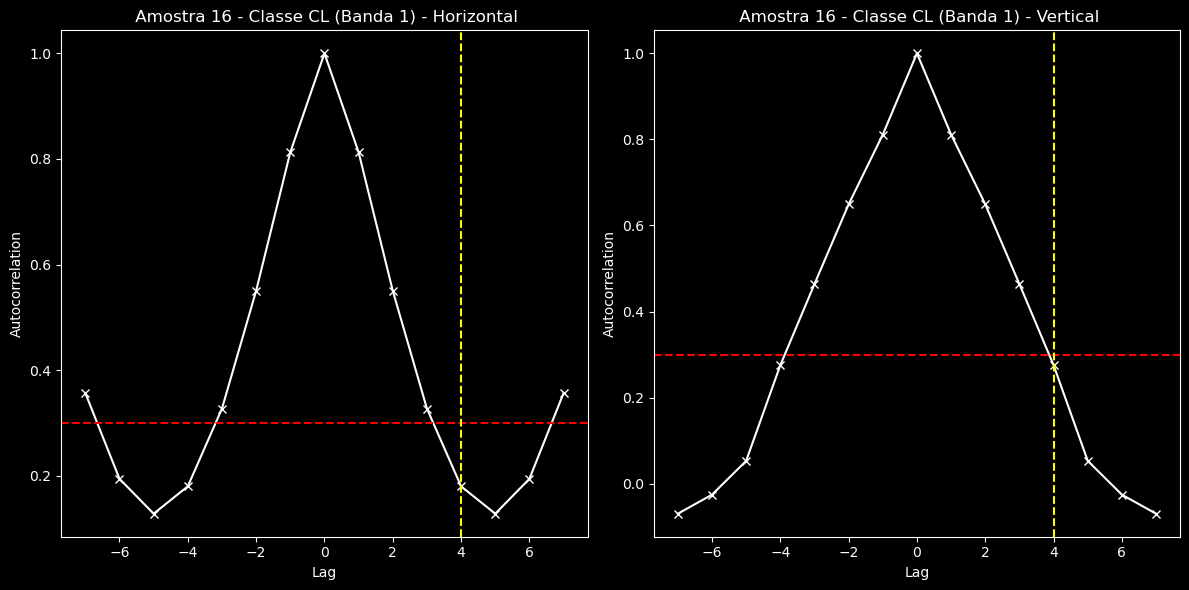

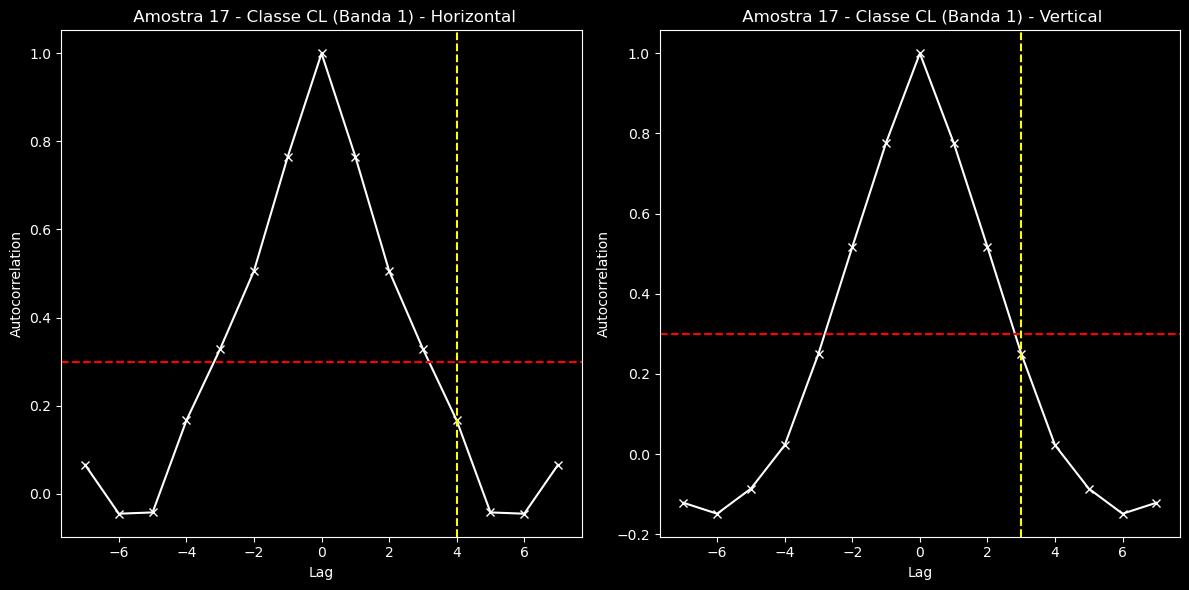

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_6216\3874122535.py:34: RuntimeWarning: invalid value encountered in divide
  R = C/norm_factor


Erro ao calcular lags do polígono 17: '>' not supported between instances of 'float' and 'NoneType'


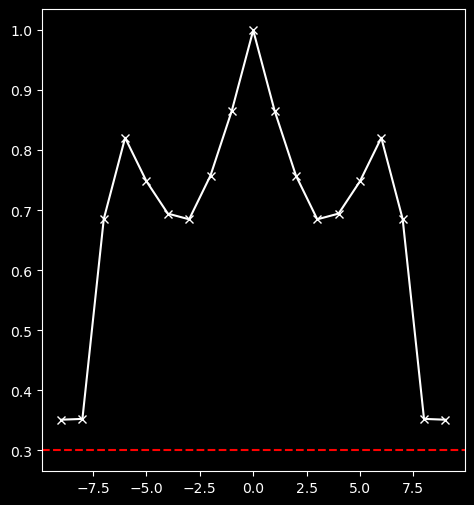

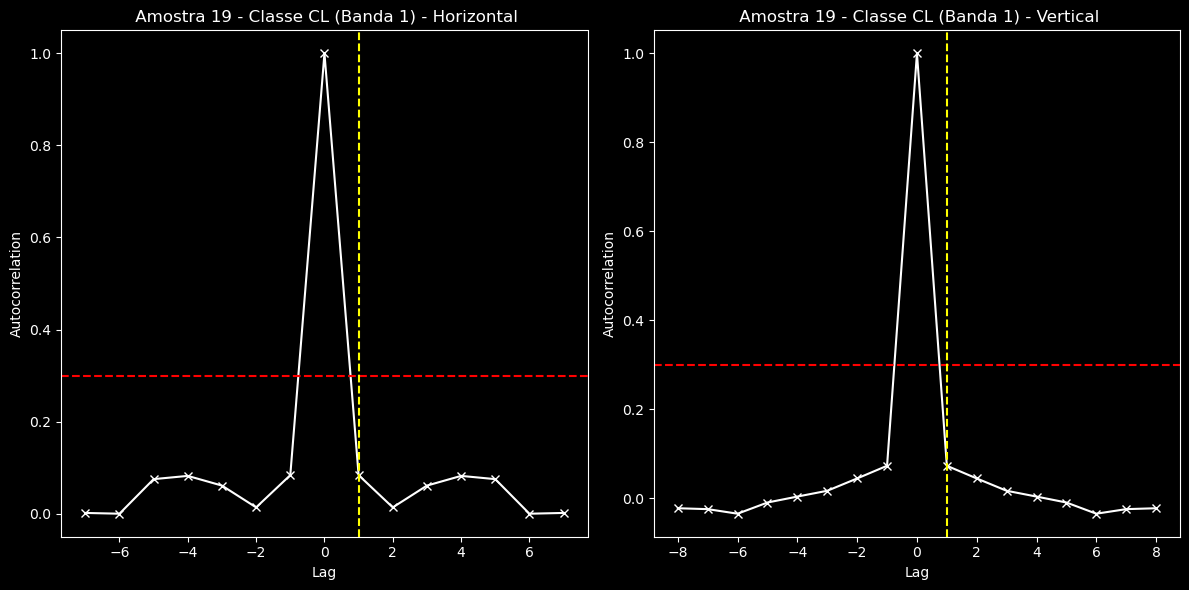

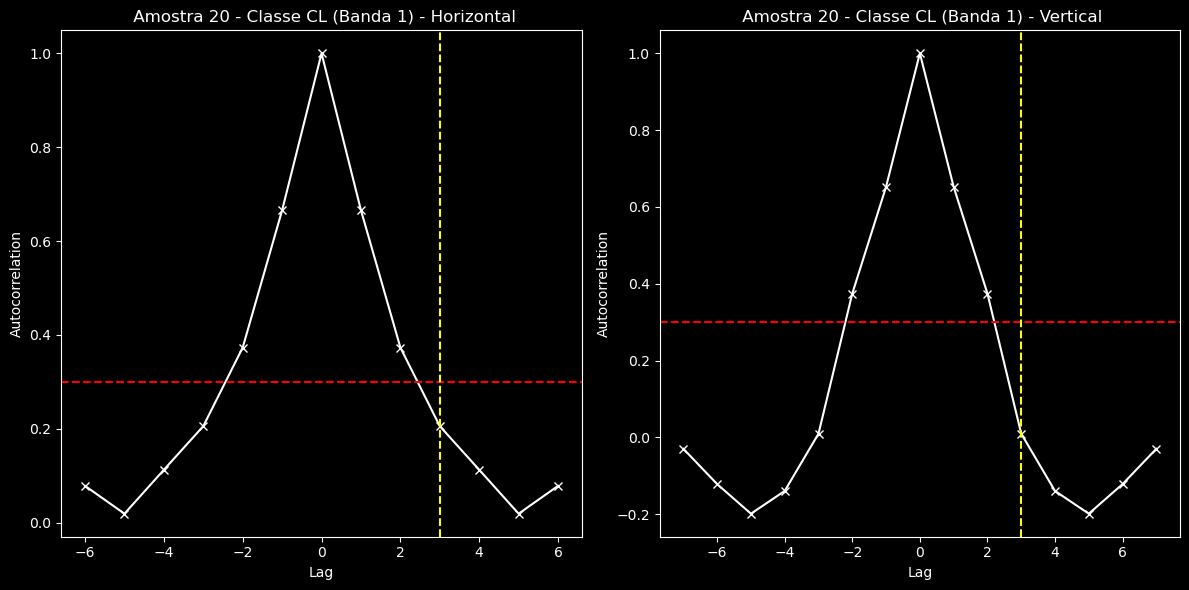

Erro ao calcular lags do polígono 20: '>' not supported between instances of 'float' and 'NoneType'


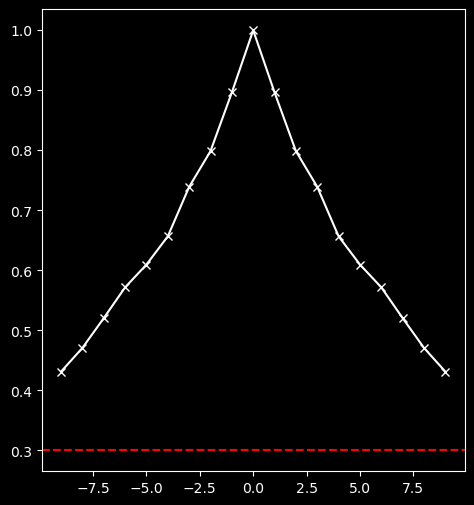

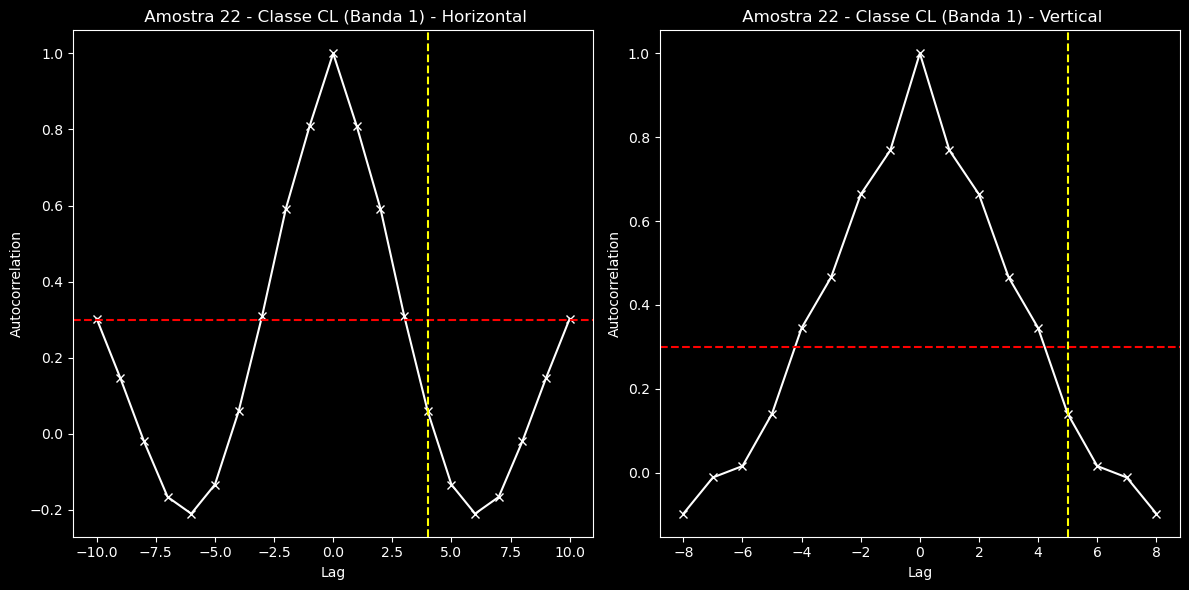

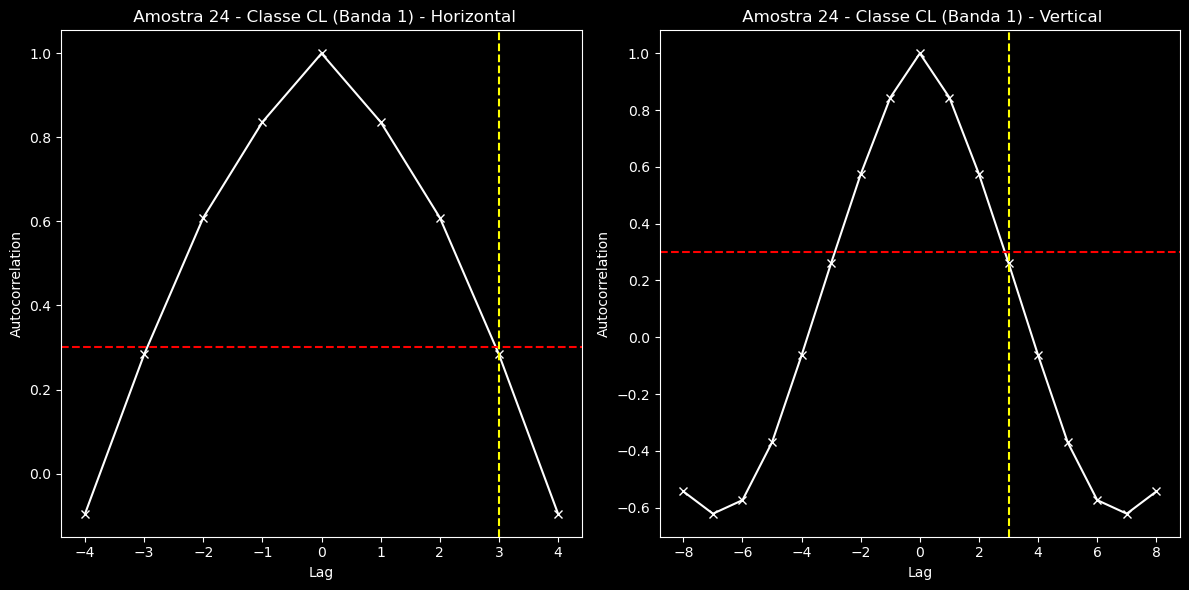

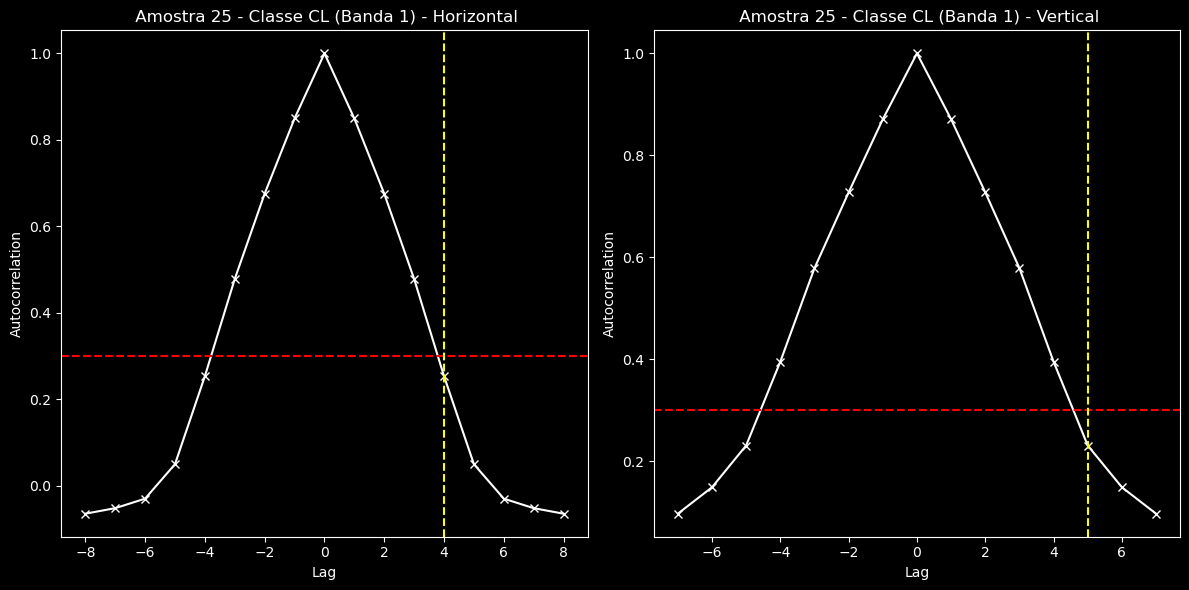

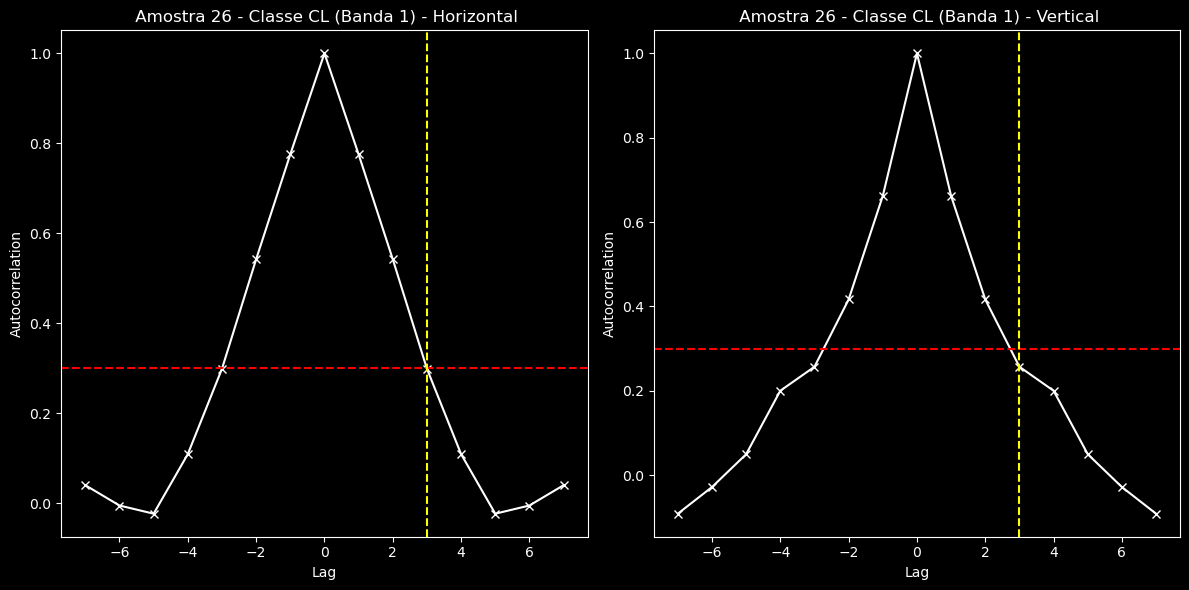

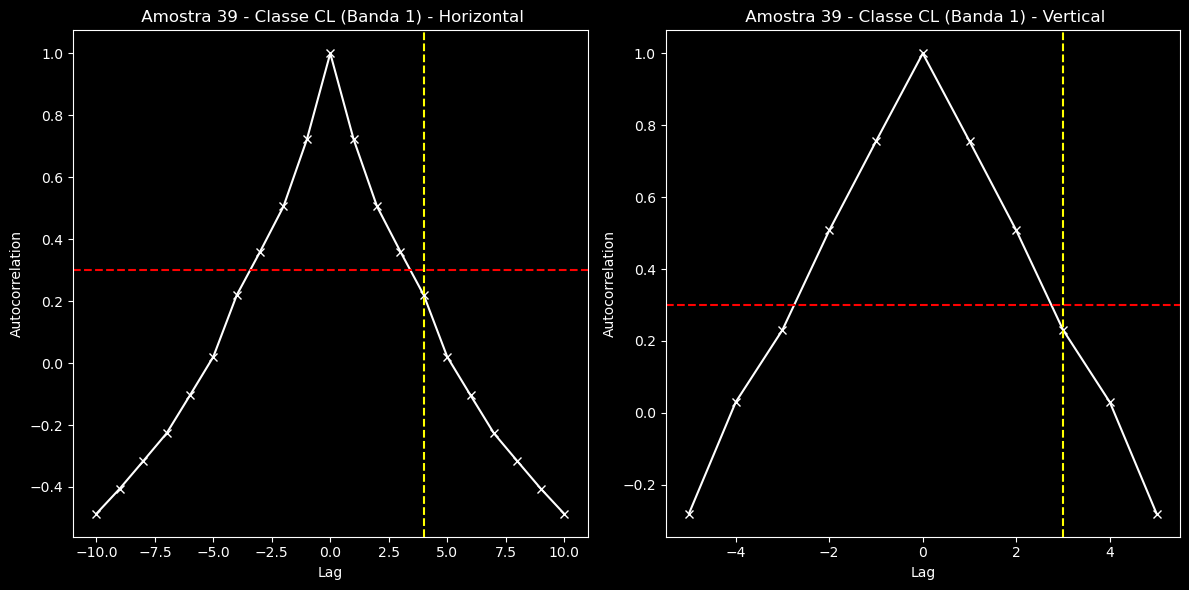

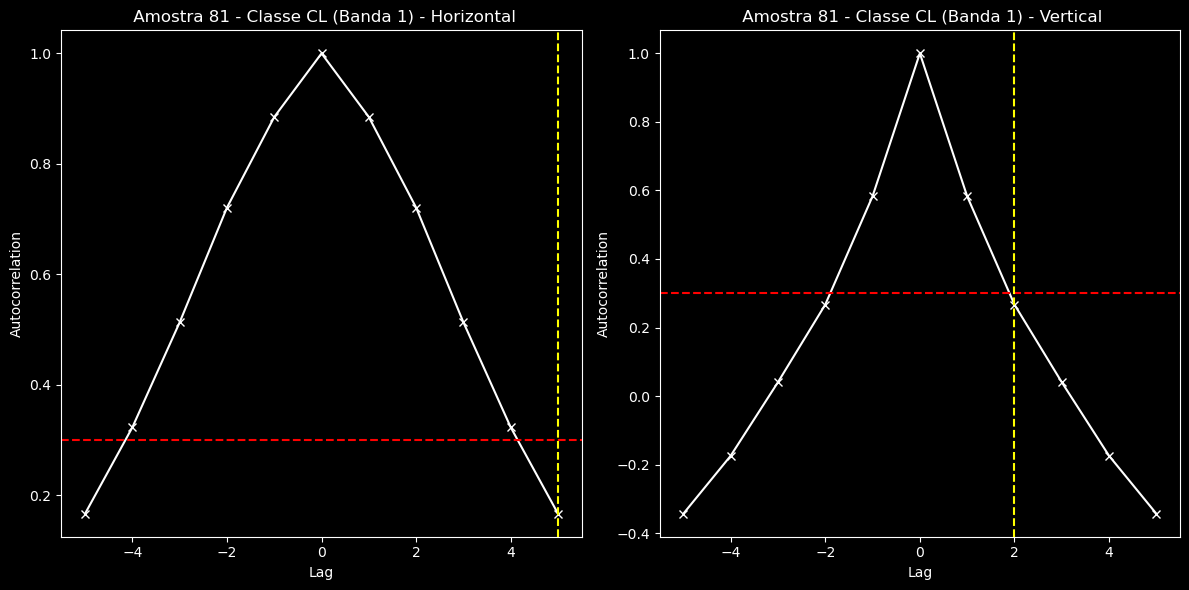

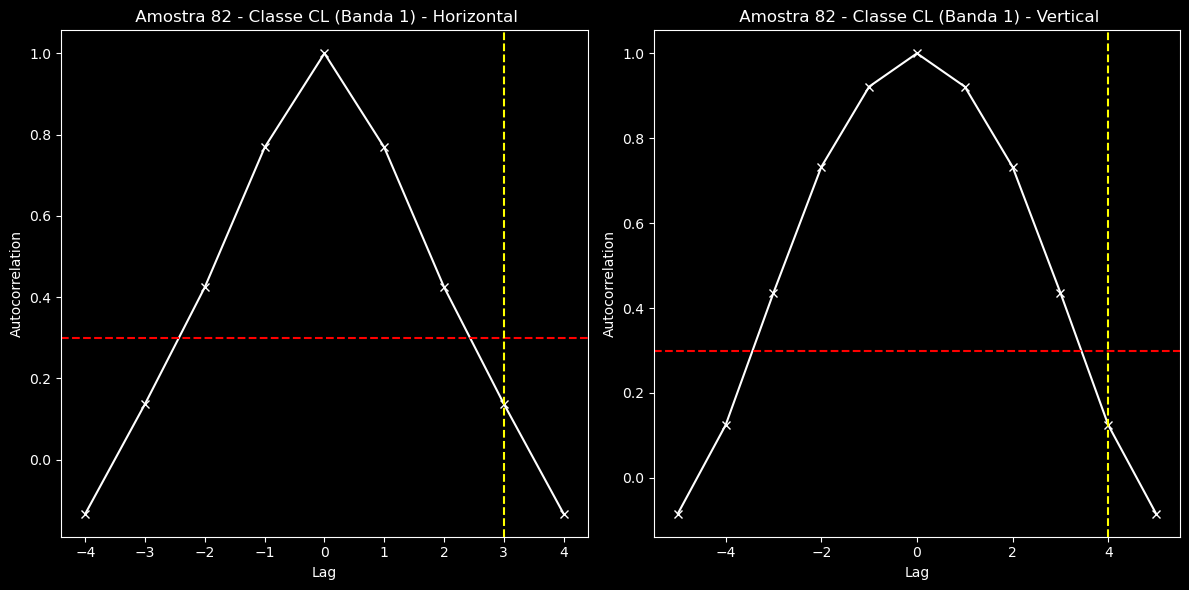

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_6216\3874122535.py:34: RuntimeWarning: invalid value encountered in divide
  R = C/norm_factor


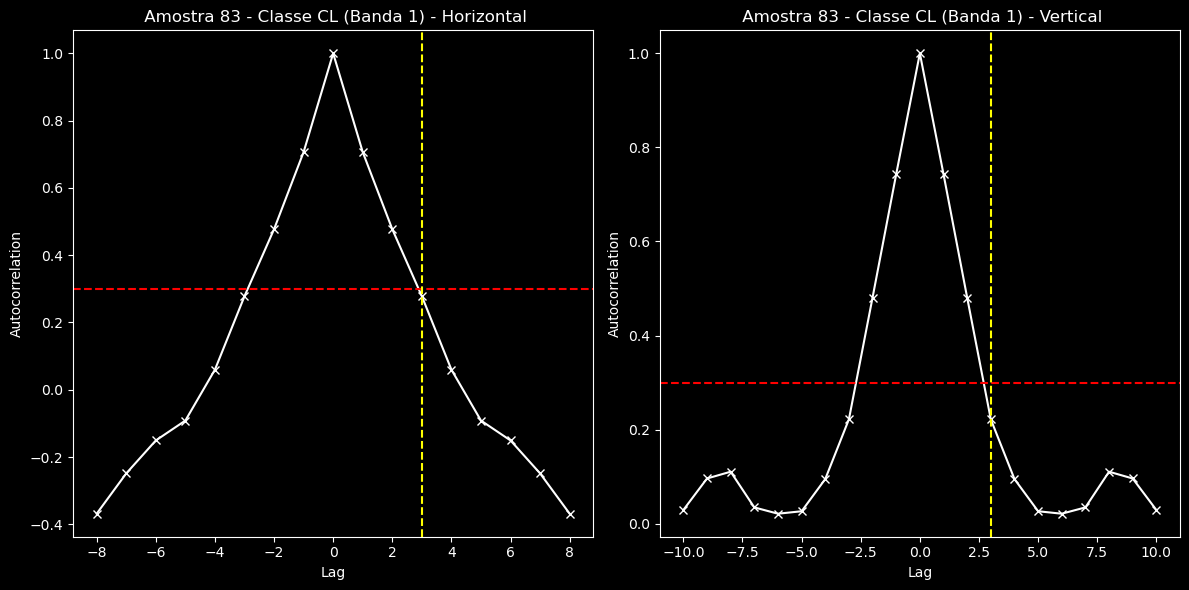

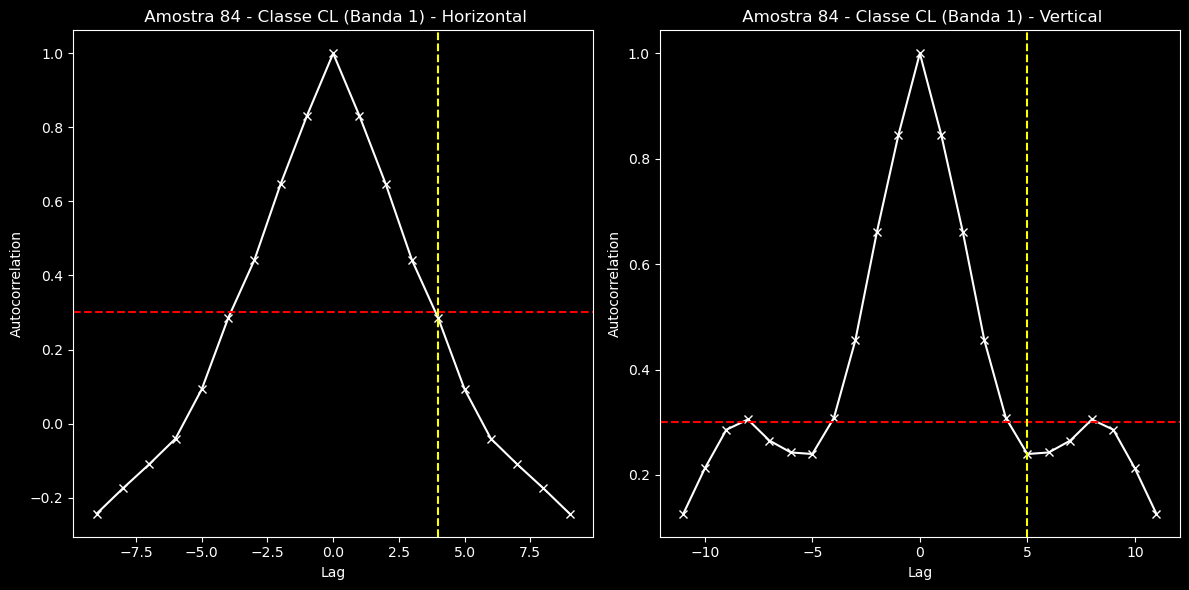

Lags Horizontais [4, 4, 4, 4, 1, 3, 4, 3, 4, 3, 4, 5, 3, 3, 4]
Lags Verticais [5, 5, 4, 3, 1, 3, 5, 3, 5, 3, 3, 2, 4, 3, 5]
Lag mediano horizontal para a classe CL: 4.0
Lag máximo horizontal para a classe CL: 5
Lag mediano vertical para a classe CL: 3.0
Lag máximo vertical para a classe CL: 5
-----------------------------------------------------------------------------------
Processando classe FD.


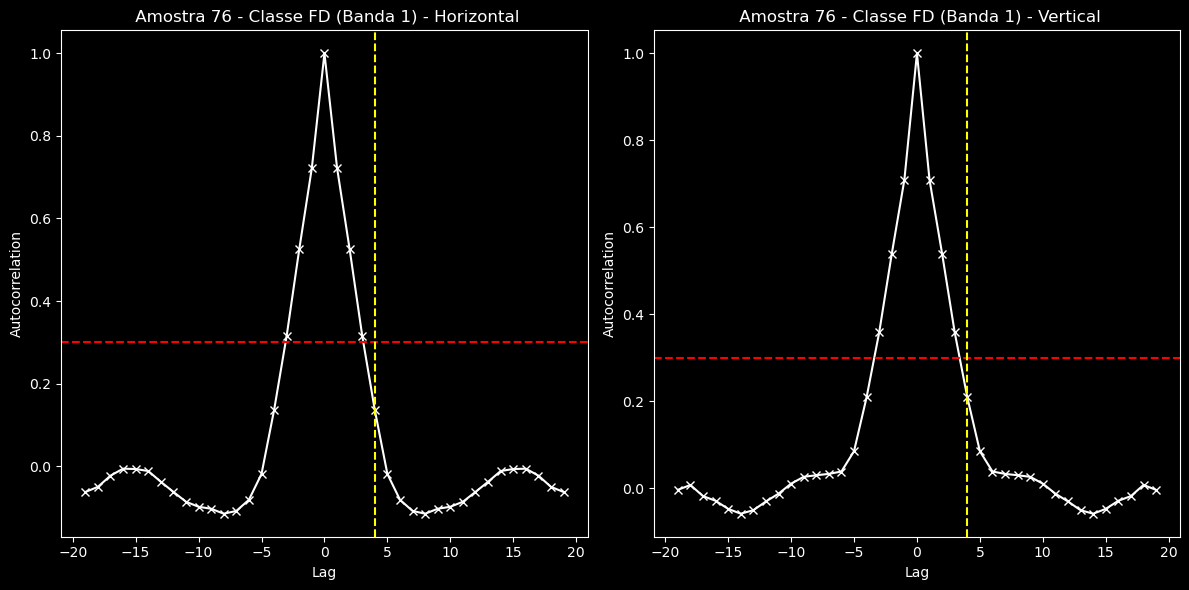

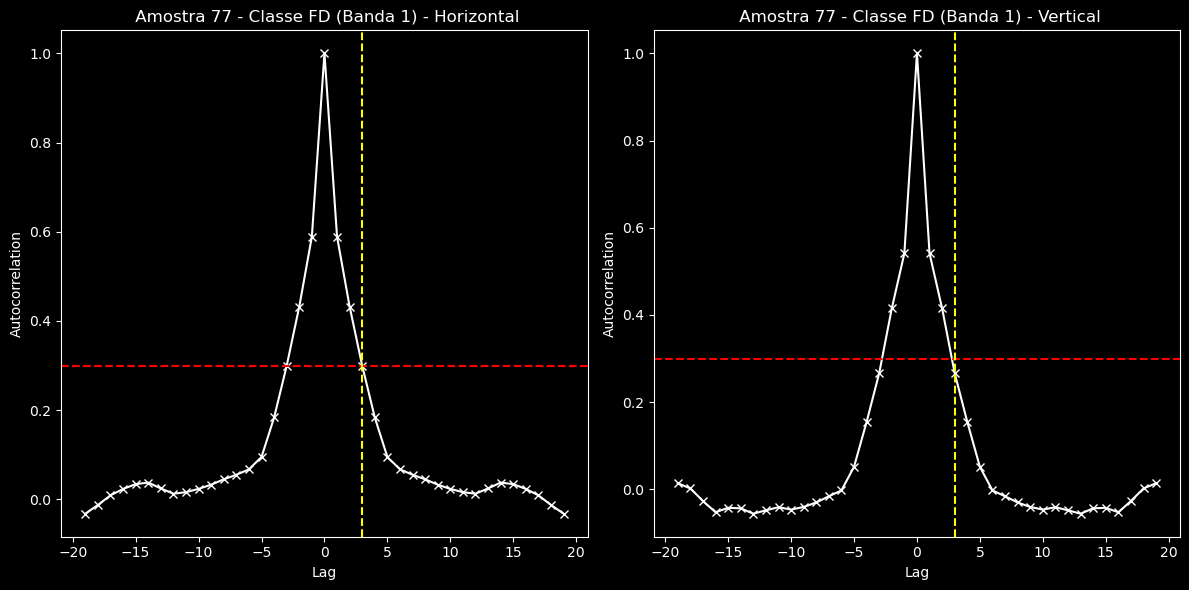

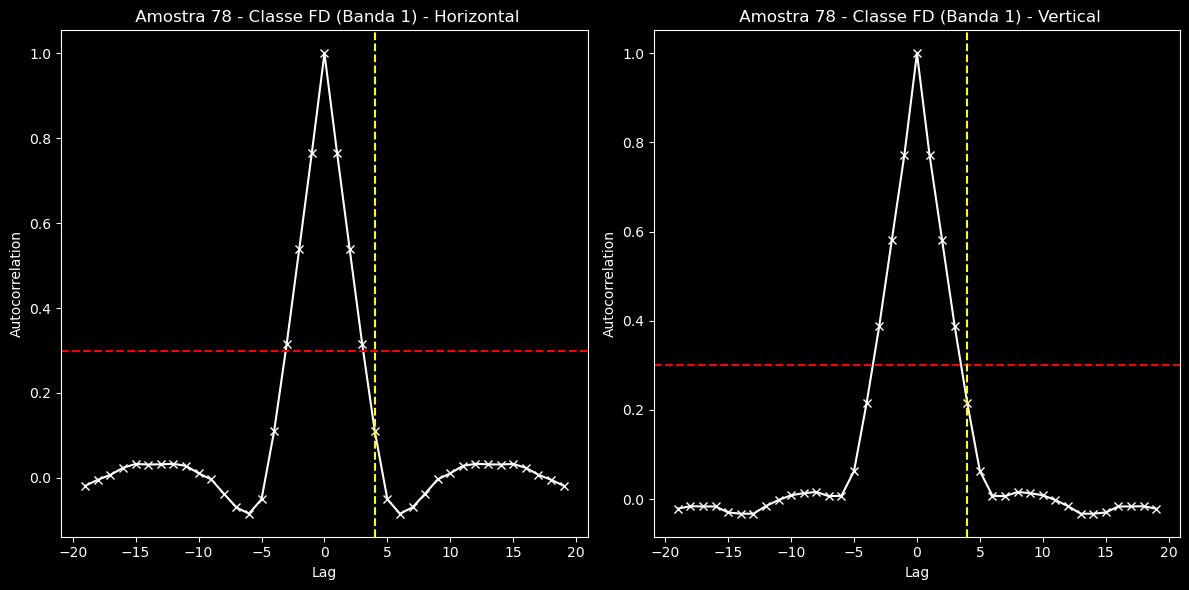

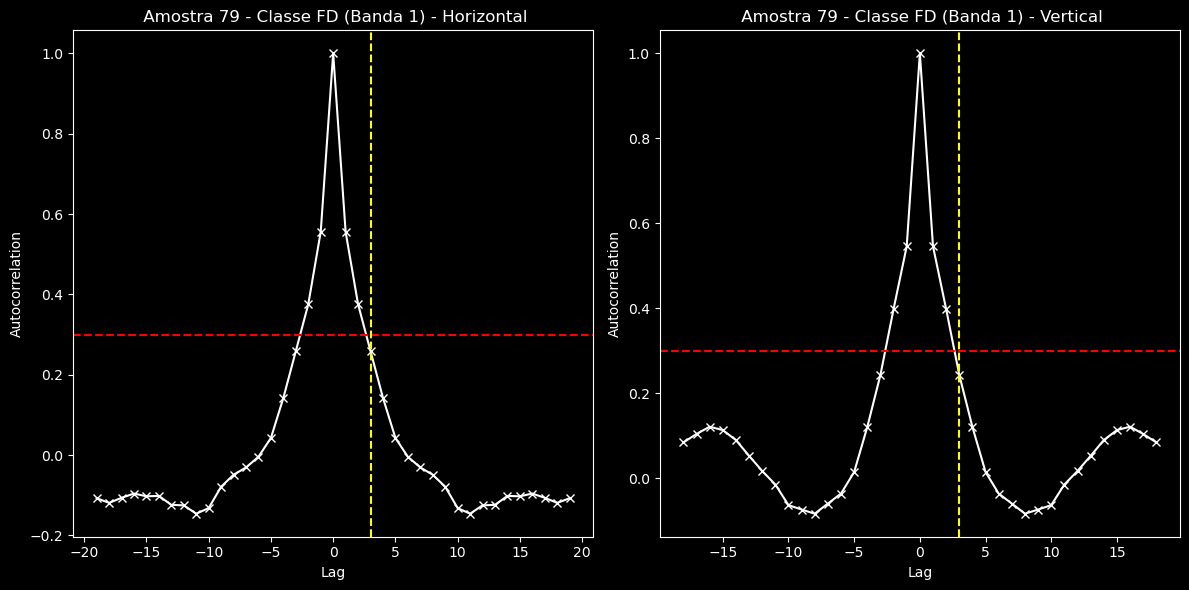

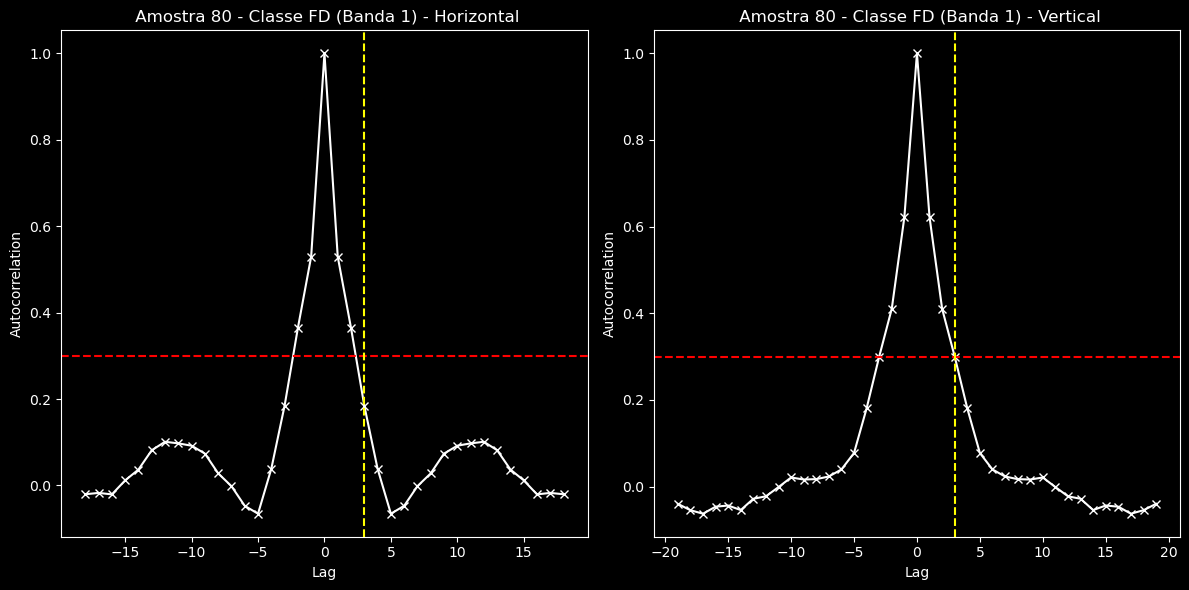

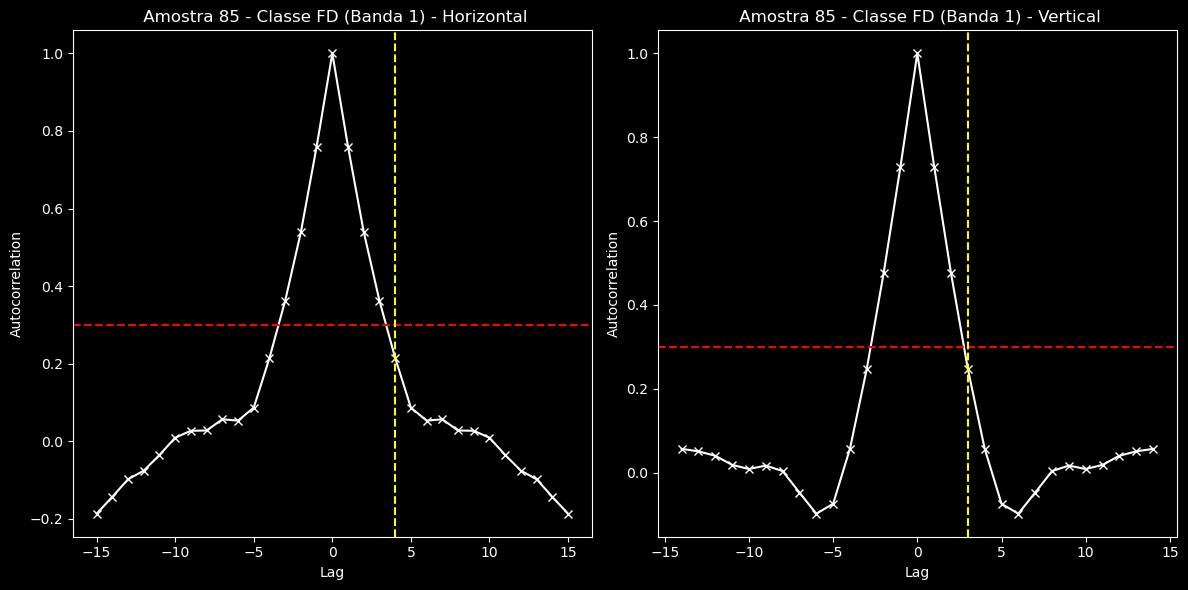

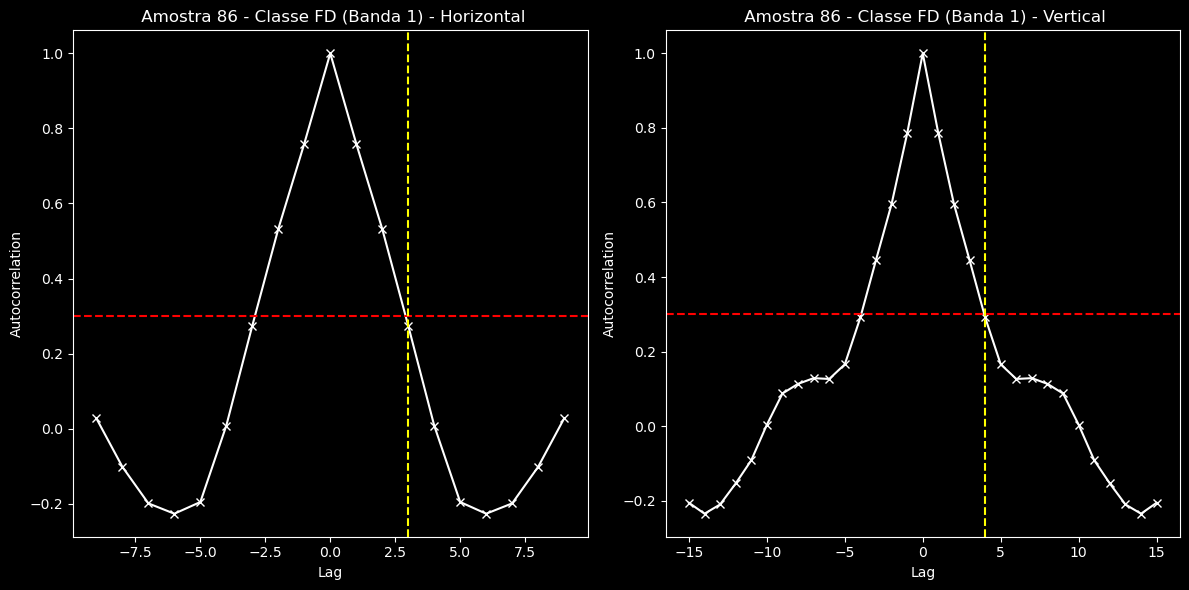

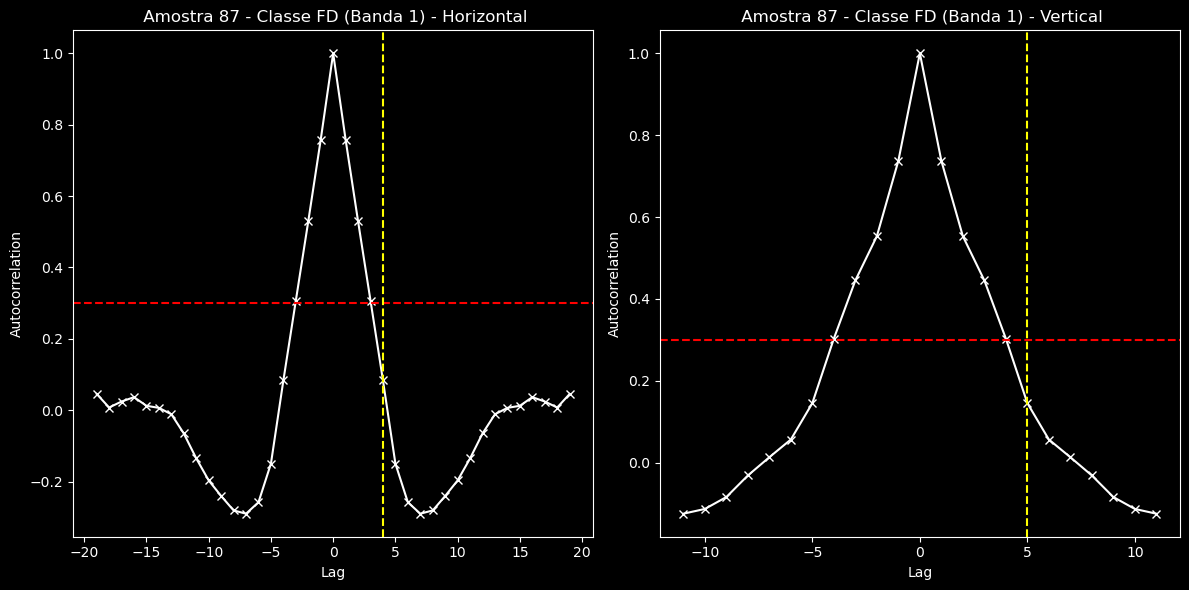

Lags Horizontais [4, 3, 4, 3, 3, 4, 3, 4]
Lags Verticais [4, 3, 4, 3, 3, 3, 4, 5]
Lag mediano horizontal para a classe FD: 3.5
Lag máximo horizontal para a classe FD: 4
Lag mediano vertical para a classe FD: 3.5
Lag máximo vertical para a classe FD: 5
-----------------------------------------------------------------------------------
Processando classe FP.


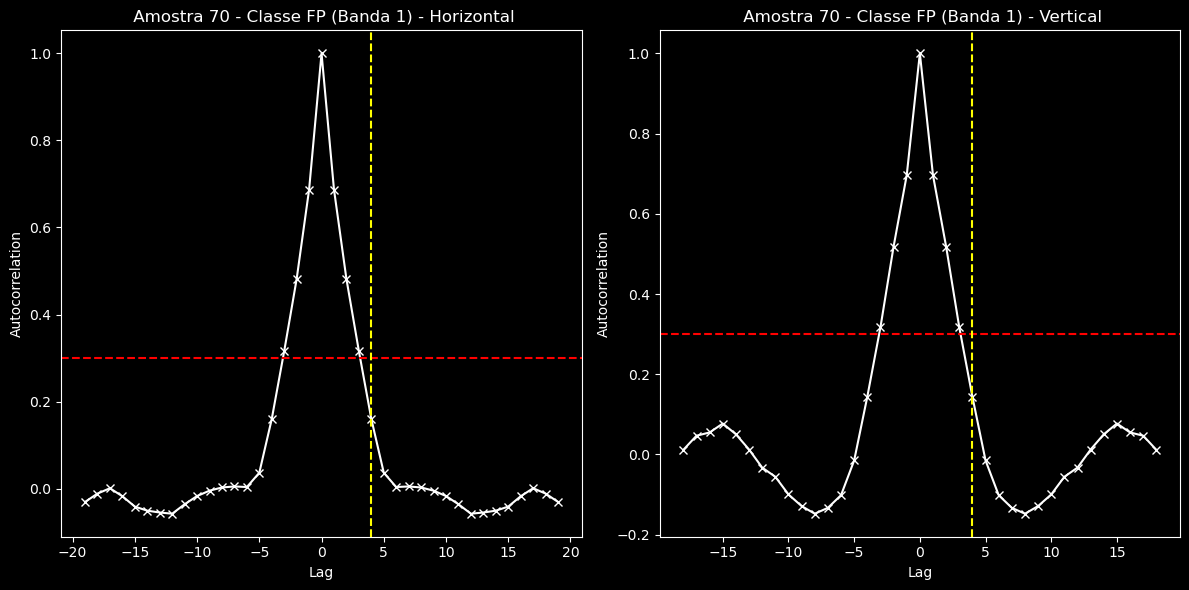

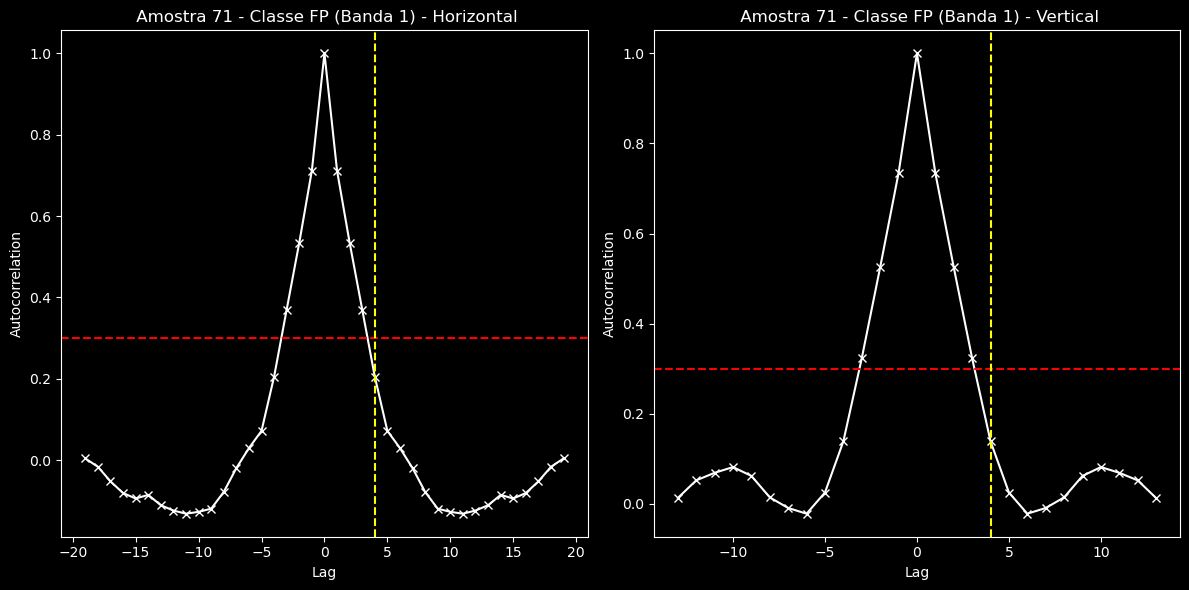

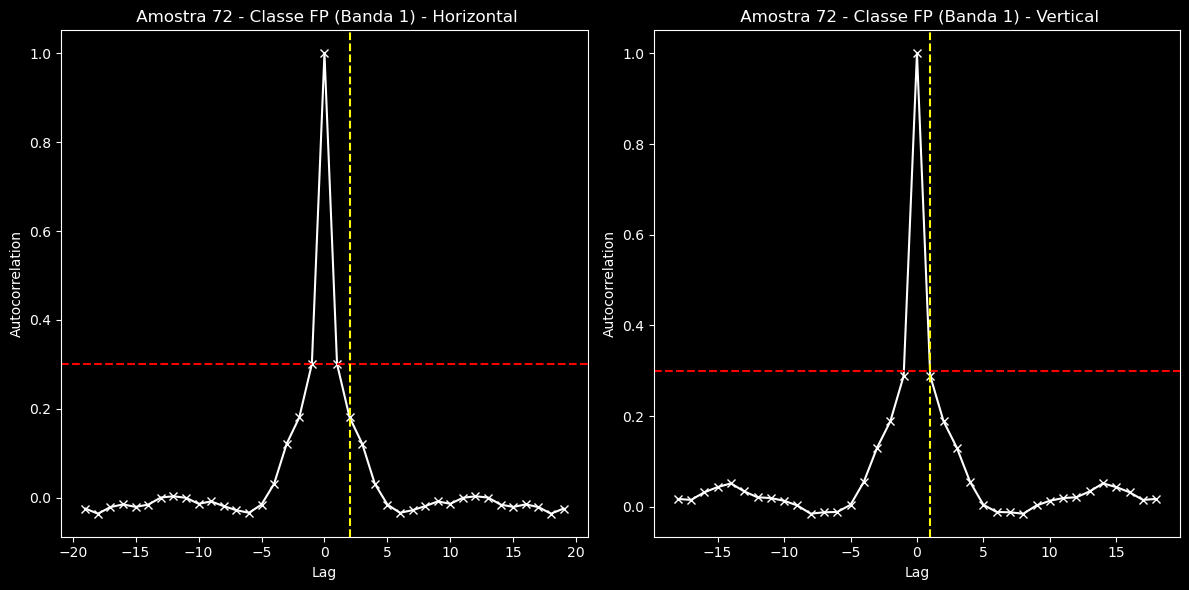

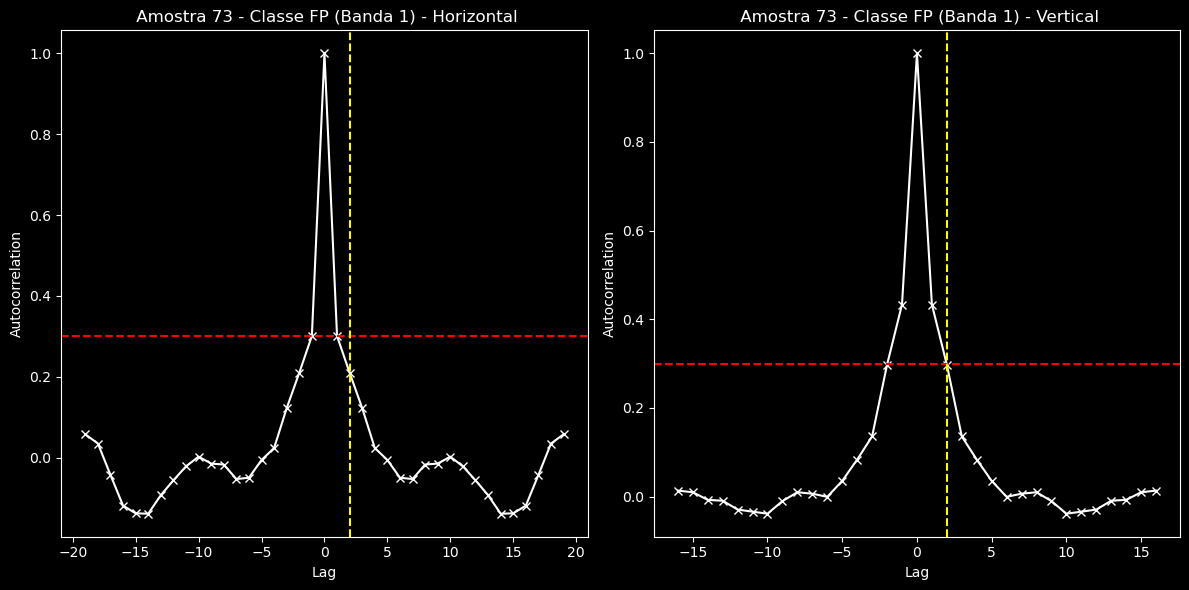

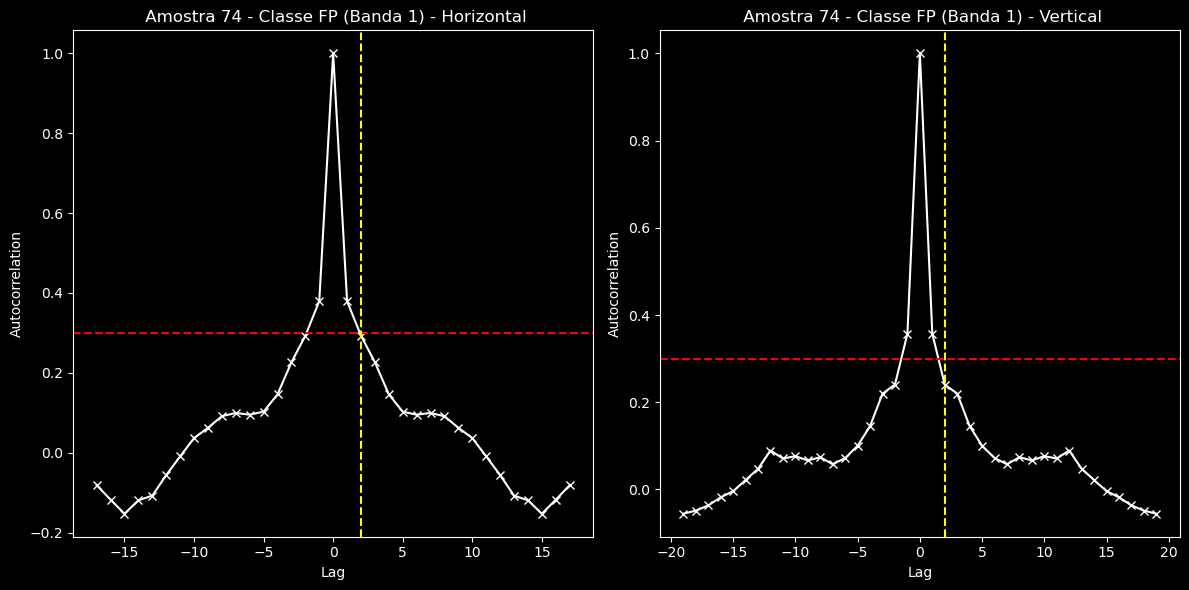

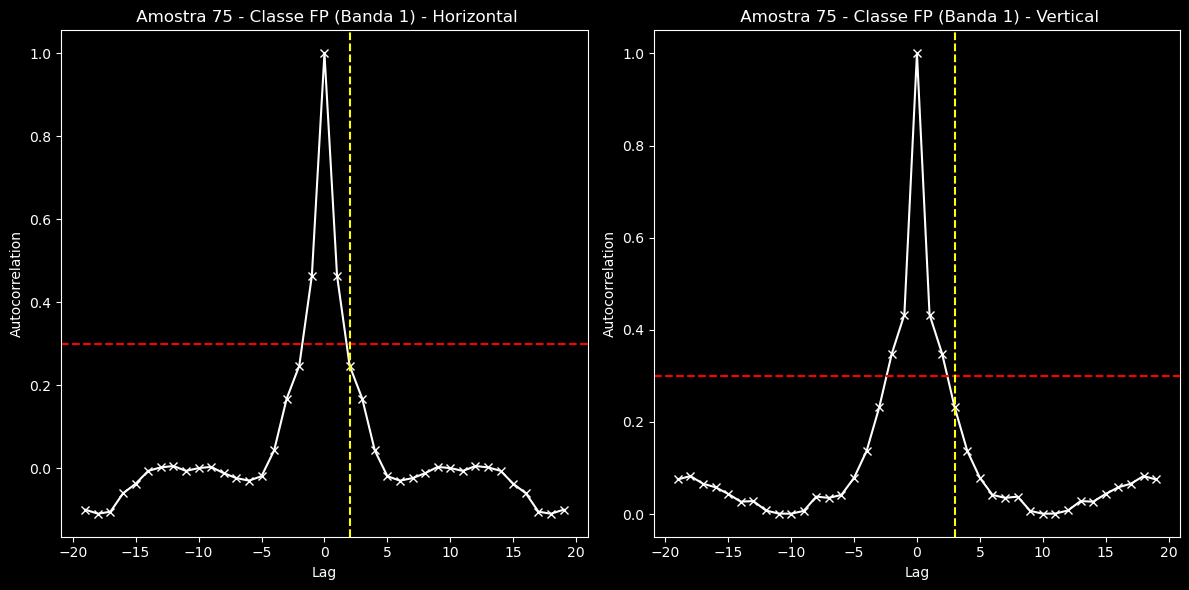

Erro ao calcular lags do polígono 87: '>' not supported between instances of 'float' and 'NoneType'


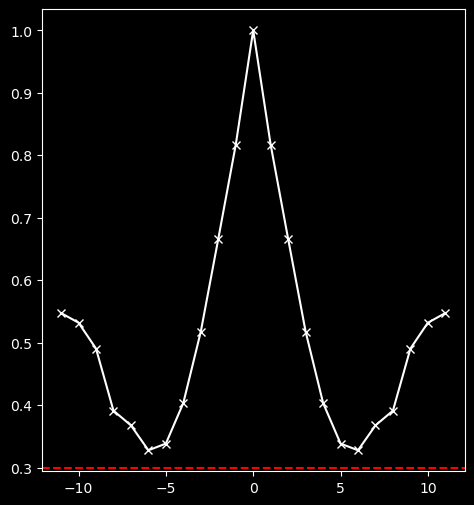

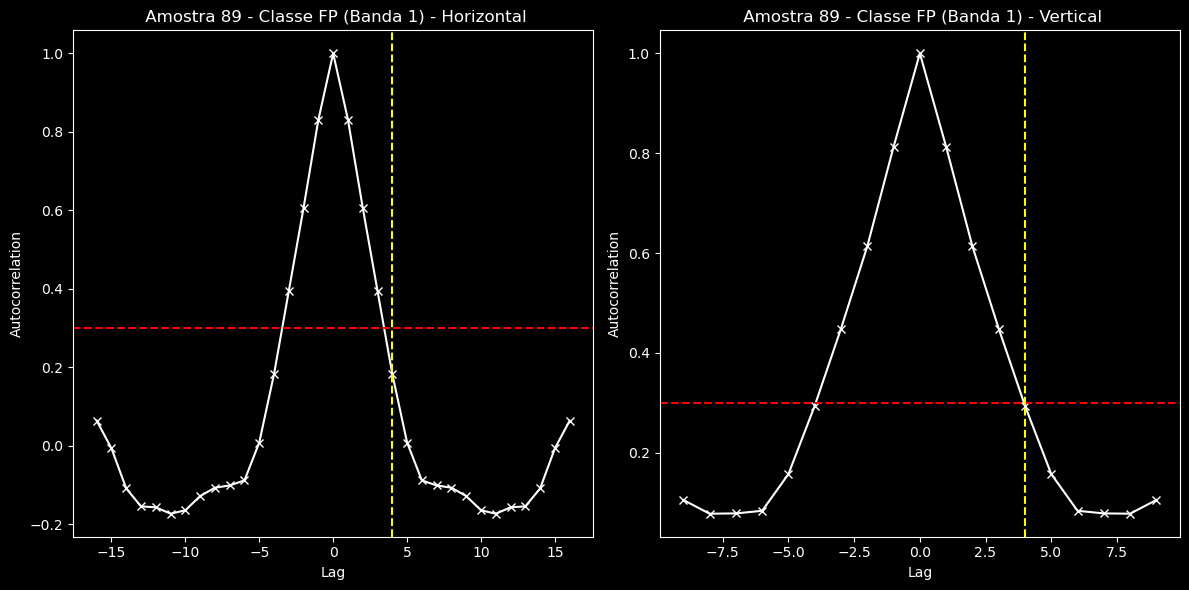

Lags Horizontais [4, 4, 2, 2, 2, 2, 4]
Lags Verticais [4, 4, 1, 2, 2, 3, 4]
Lag mediano horizontal para a classe FP: 2.0
Lag máximo horizontal para a classe FP: 4
Lag mediano vertical para a classe FP: 3.0
Lag máximo vertical para a classe FP: 4
-----------------------------------------------------------------------------------
Processando classe PL.


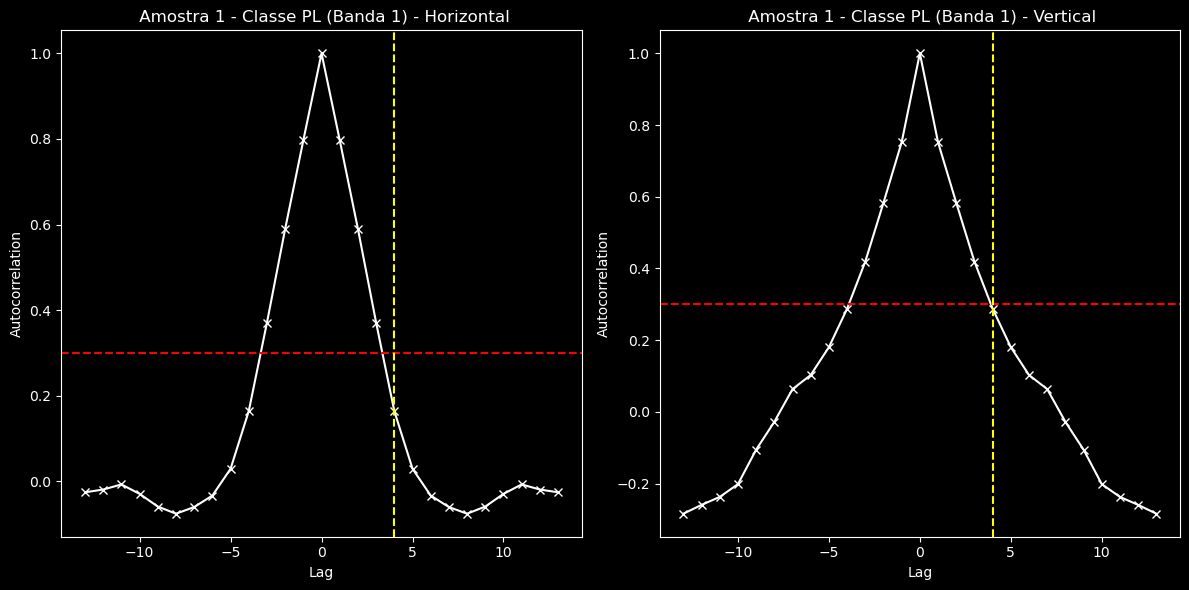

Erro ao calcular lags do polígono 1: '>' not supported between instances of 'float' and 'NoneType'


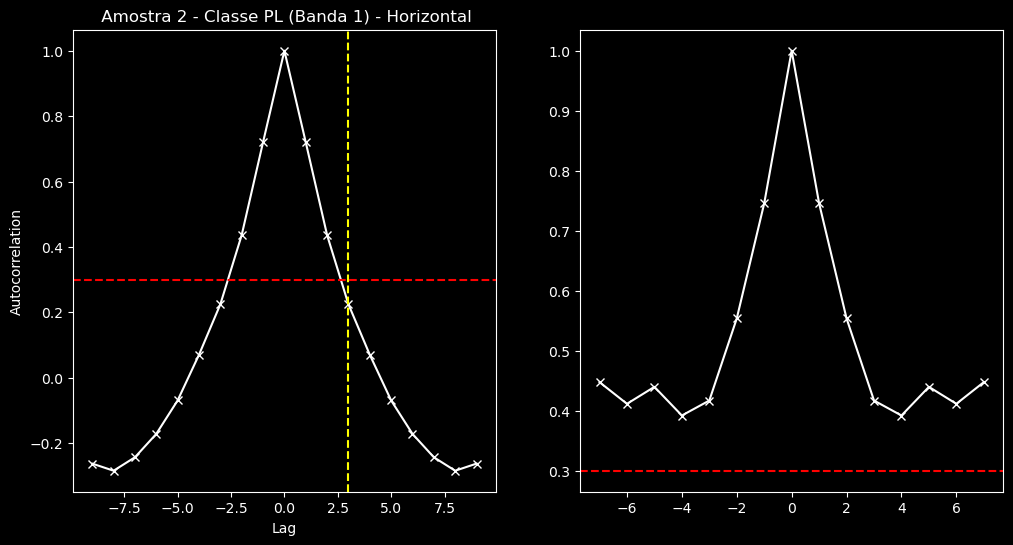

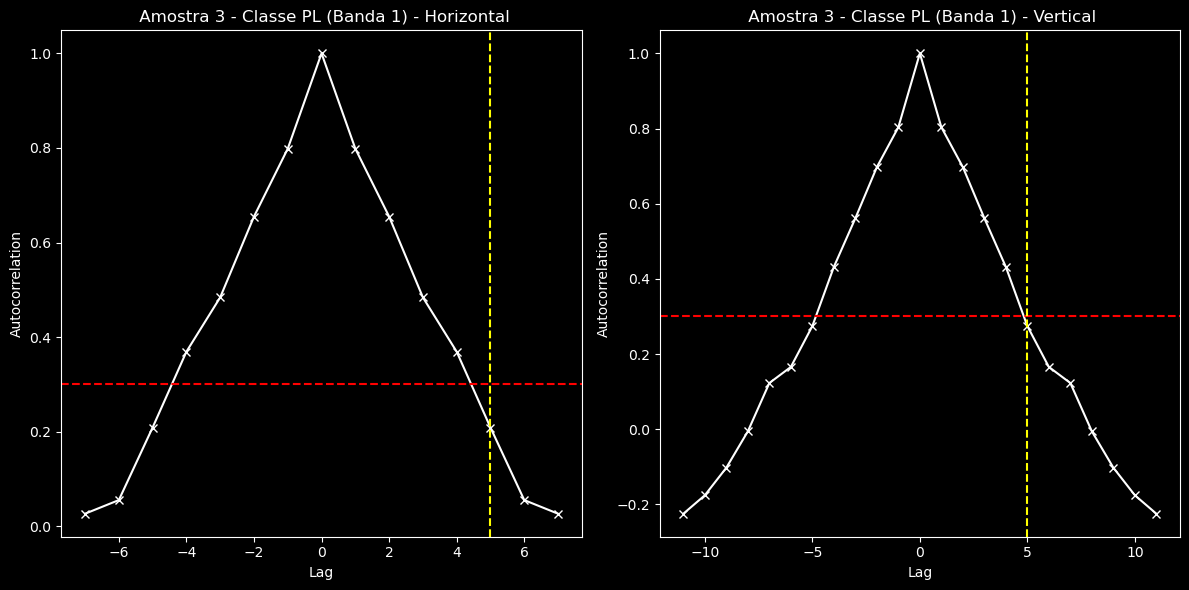

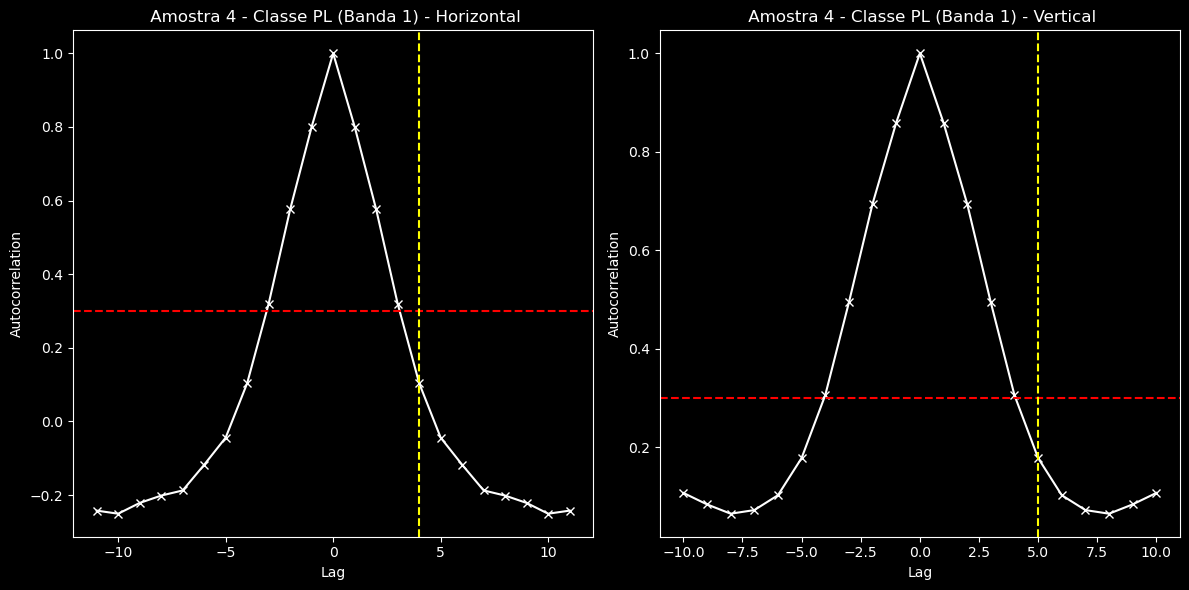

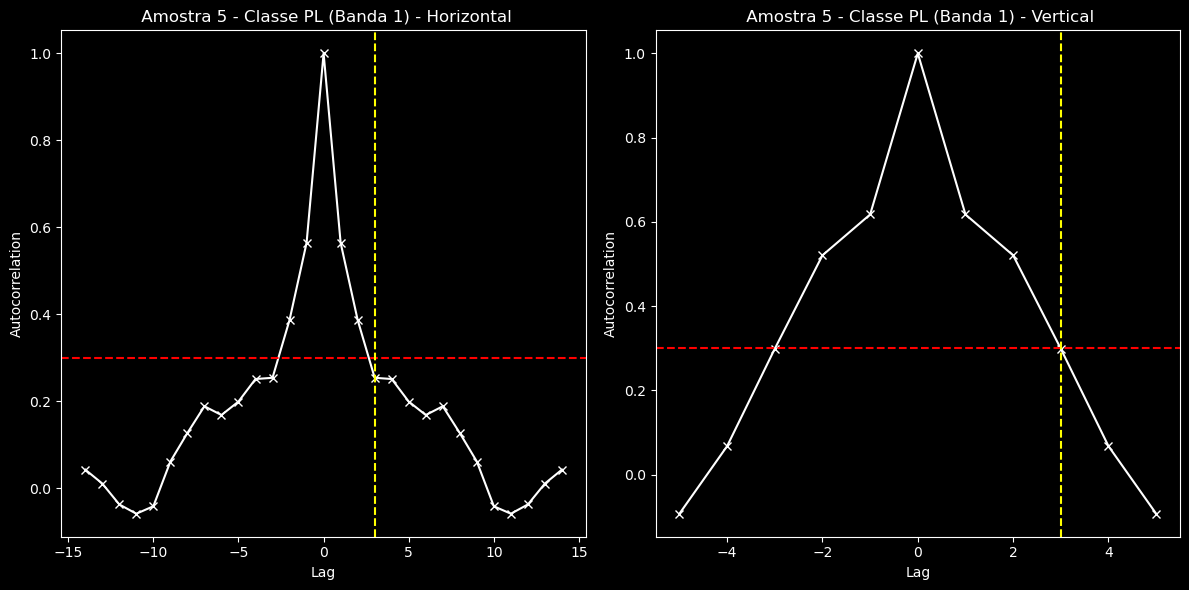

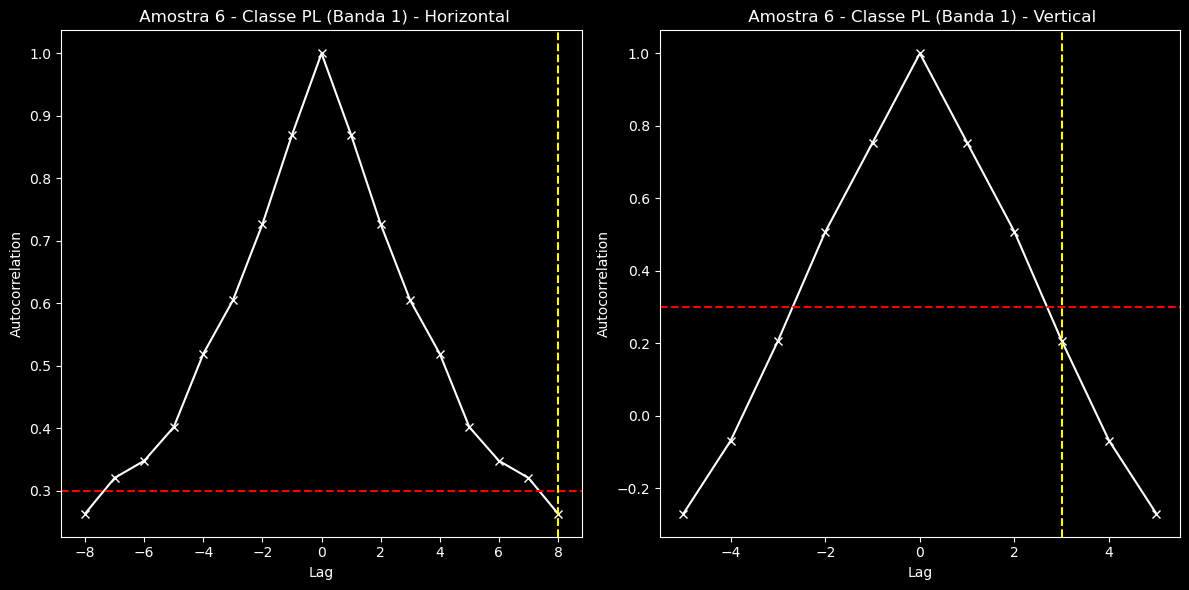

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_6216\3874122535.py:34: RuntimeWarning: invalid value encountered in divide
  R = C/norm_factor


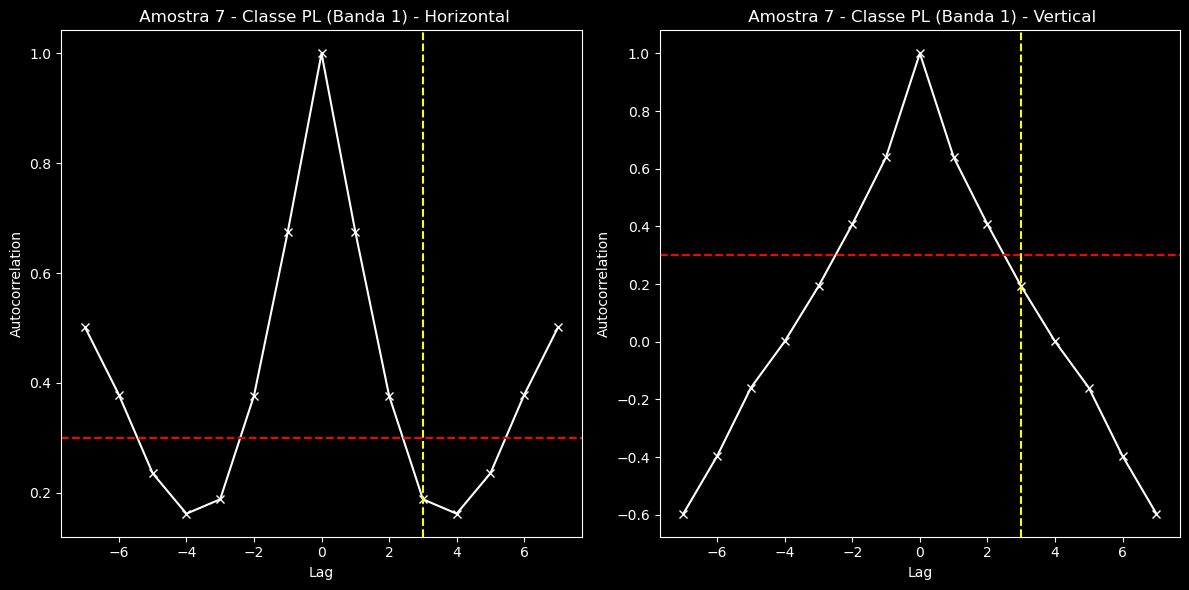

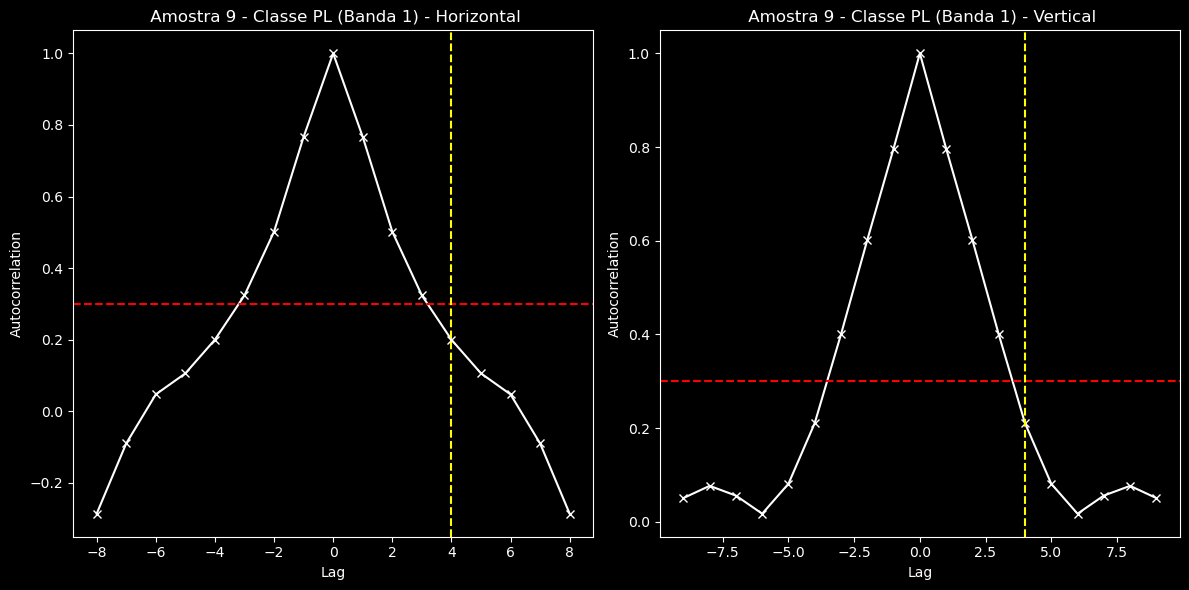

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_6216\3874122535.py:34: RuntimeWarning: invalid value encountered in divide
  R = C/norm_factor


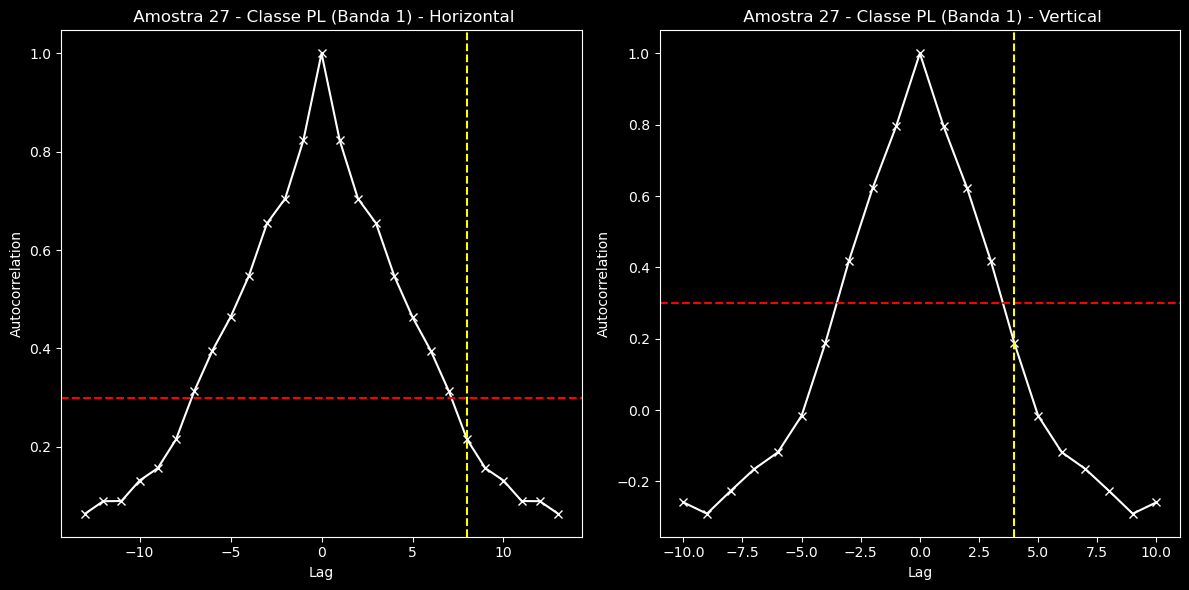

Erro ao calcular lags do polígono 27: '>' not supported between instances of 'float' and 'NoneType'


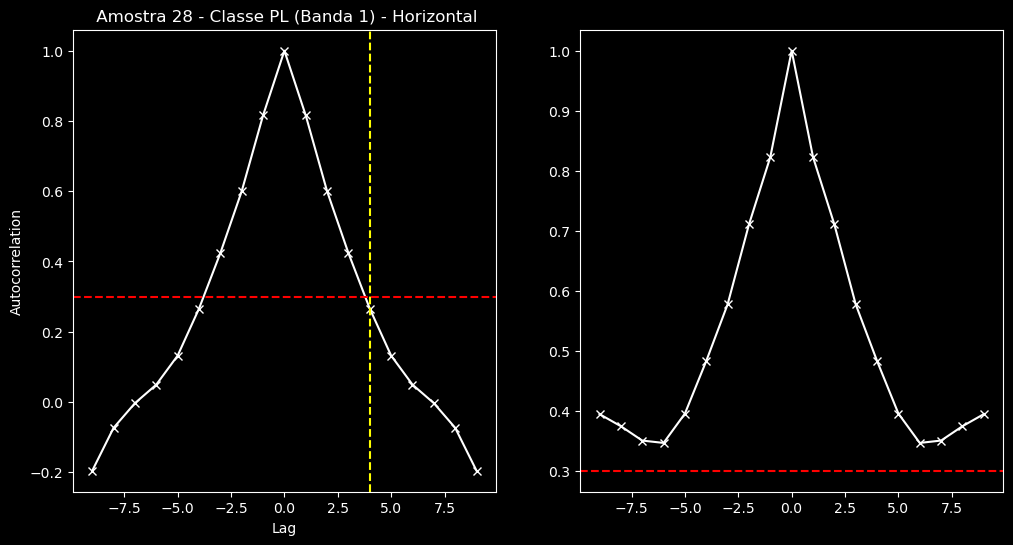

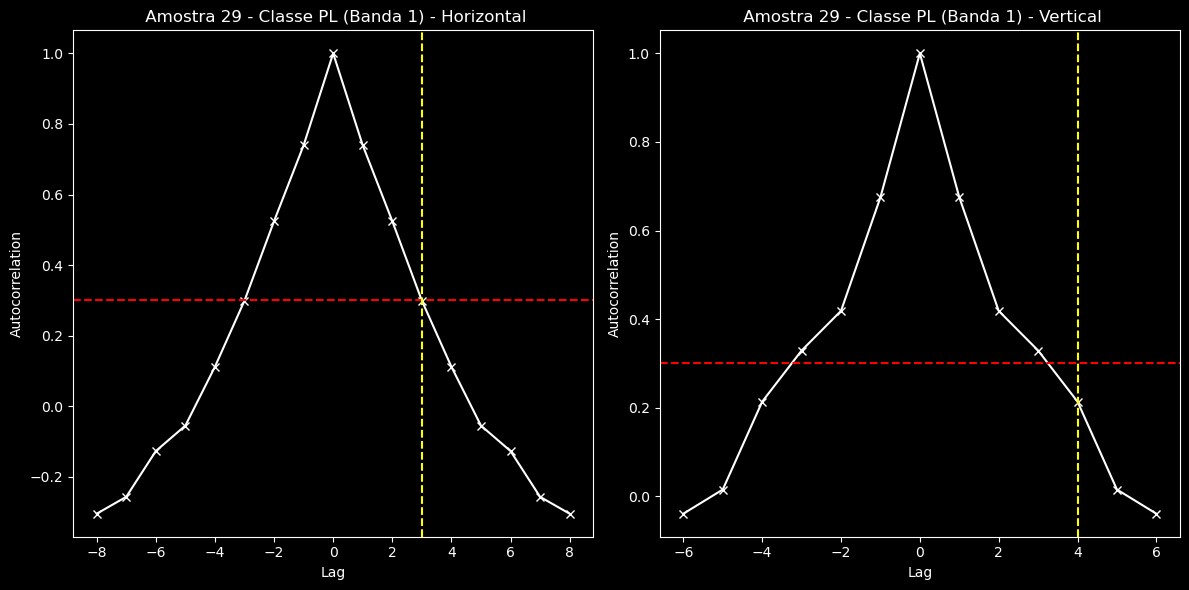

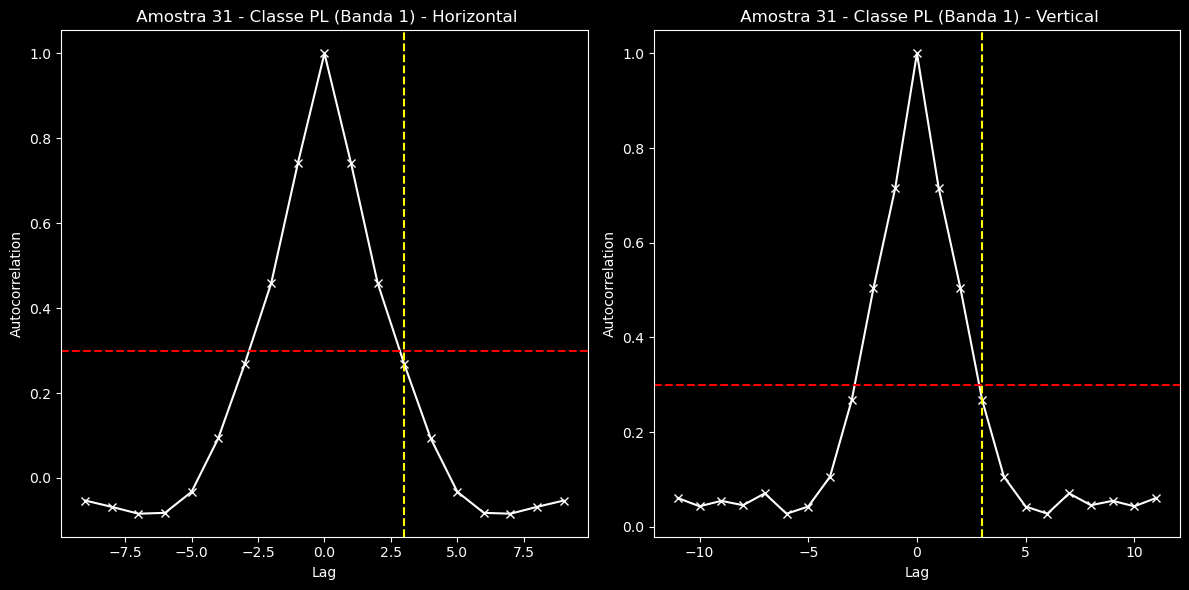

Erro ao calcular lags do polígono 31: '>' not supported between instances of 'float' and 'NoneType'


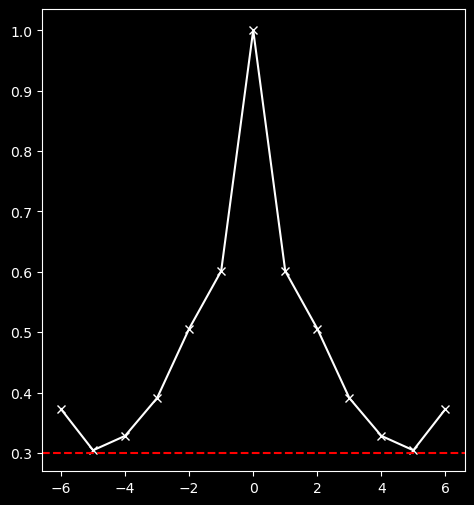

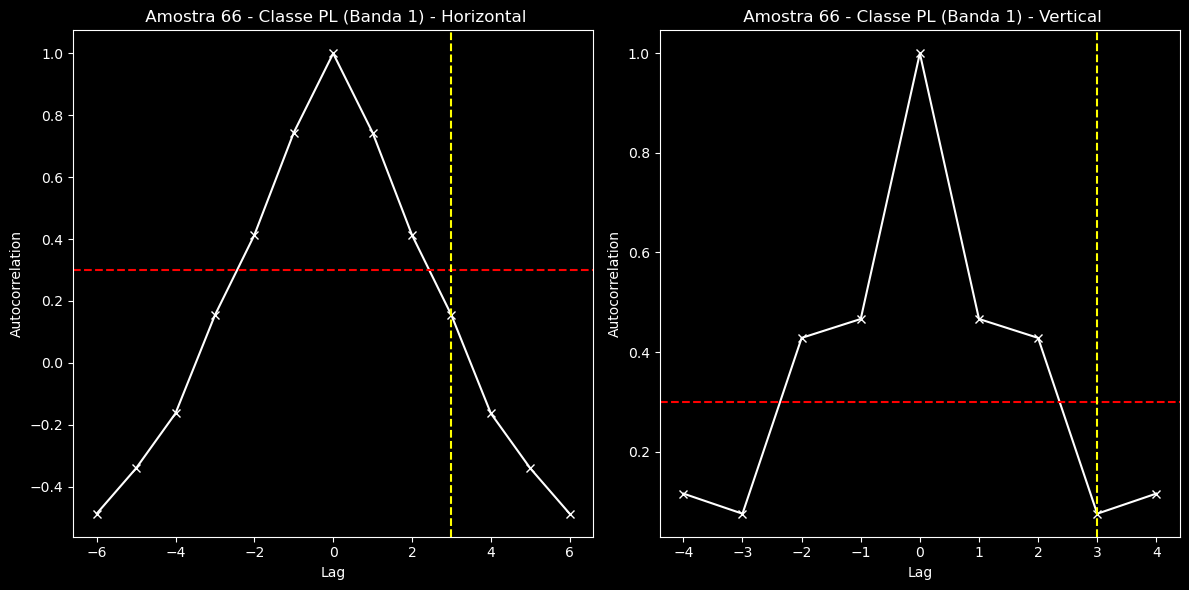

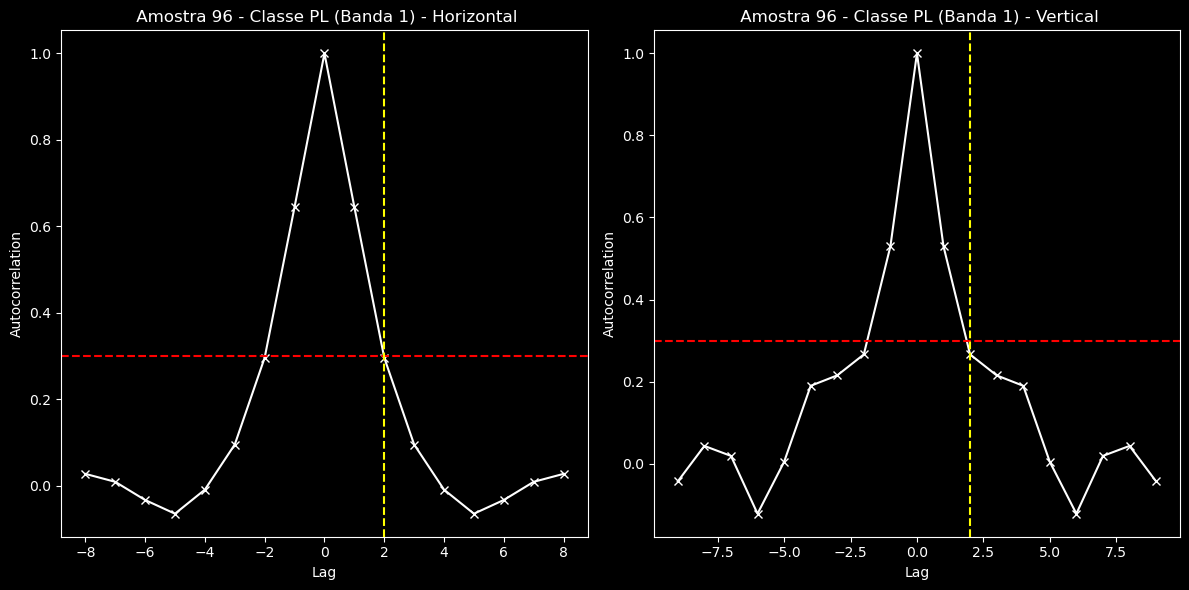

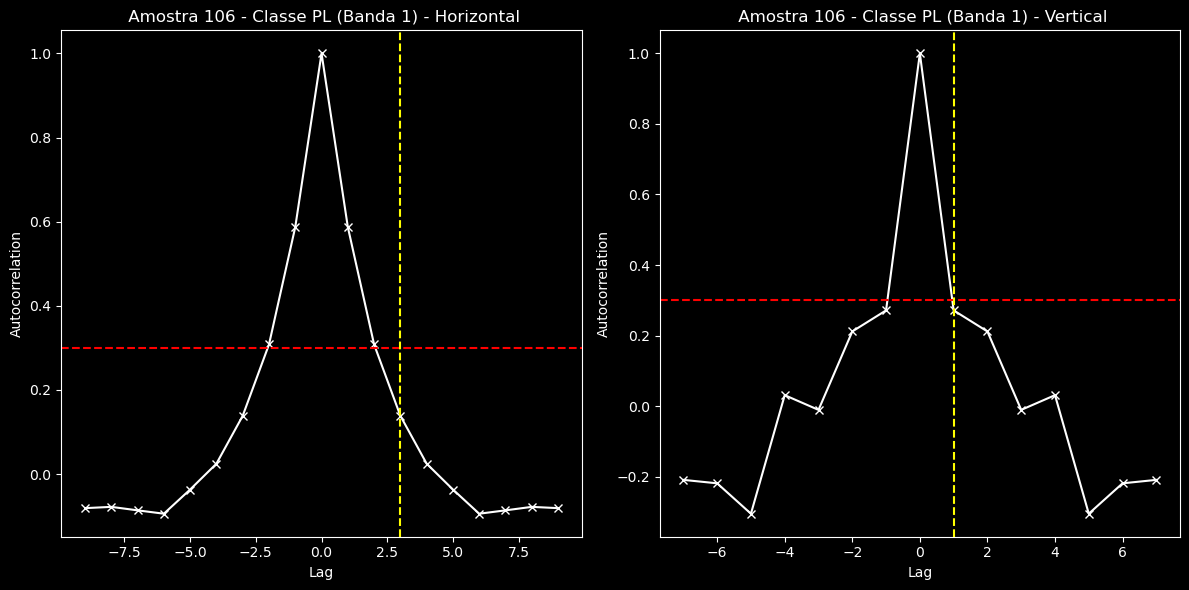

Lags Horizontais [4, 5, 4, 3, 8, 3, 4, 8, 3, 3, 3, 2, 3]
Lags Verticais [4, 5, 5, 3, 3, 3, 4, 4, 4, 3, 3, 2, 1]
Lag mediano horizontal para a classe PL: 3.0
Lag máximo horizontal para a classe PL: 5
Lag mediano vertical para a classe PL: 3.0
Lag máximo vertical para a classe PL: 5
-----------------------------------------------------------------------------------
Processando classe PS.


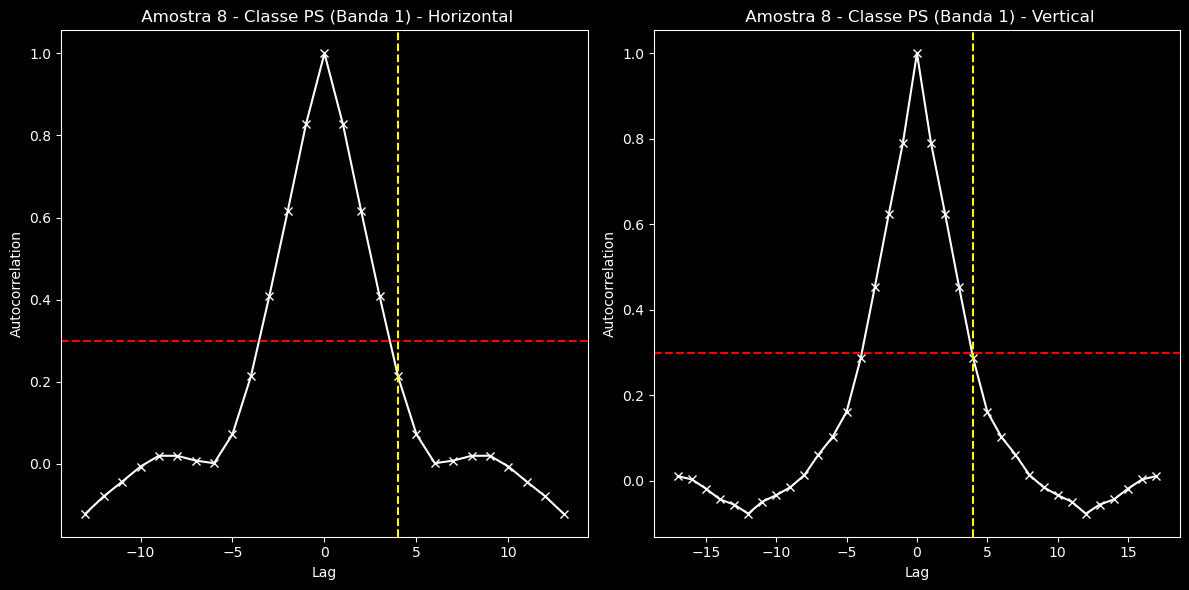

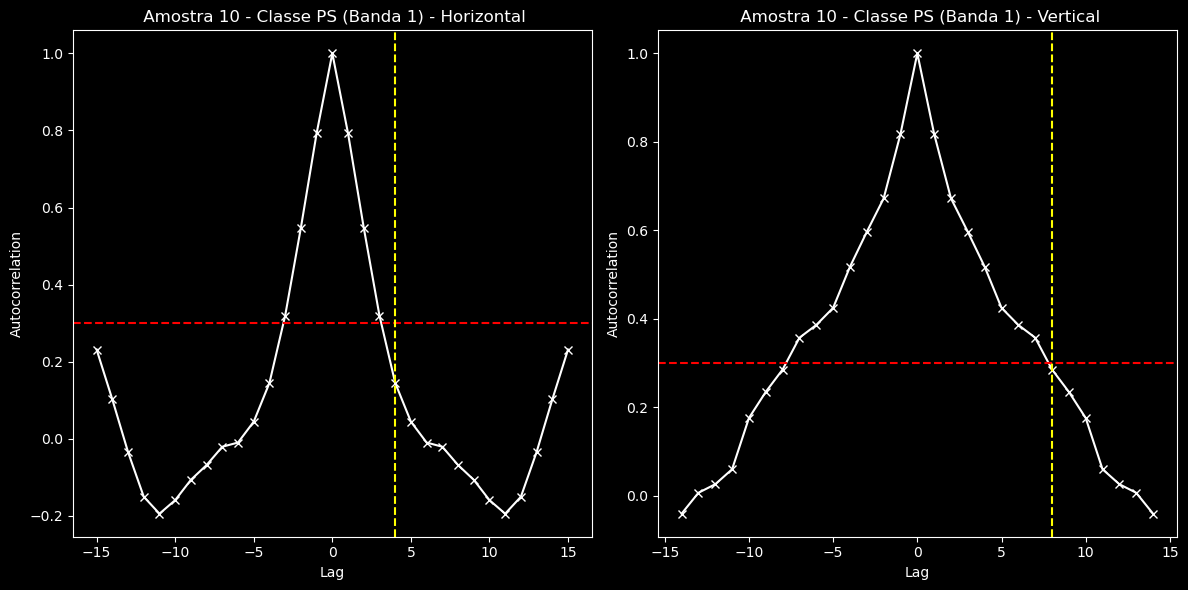

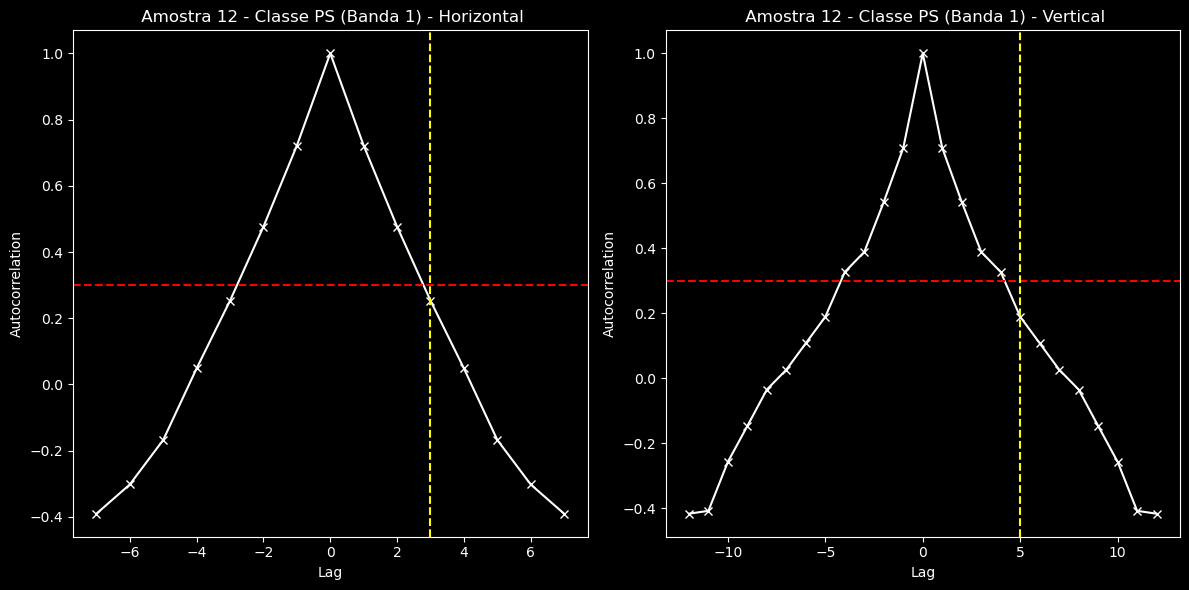

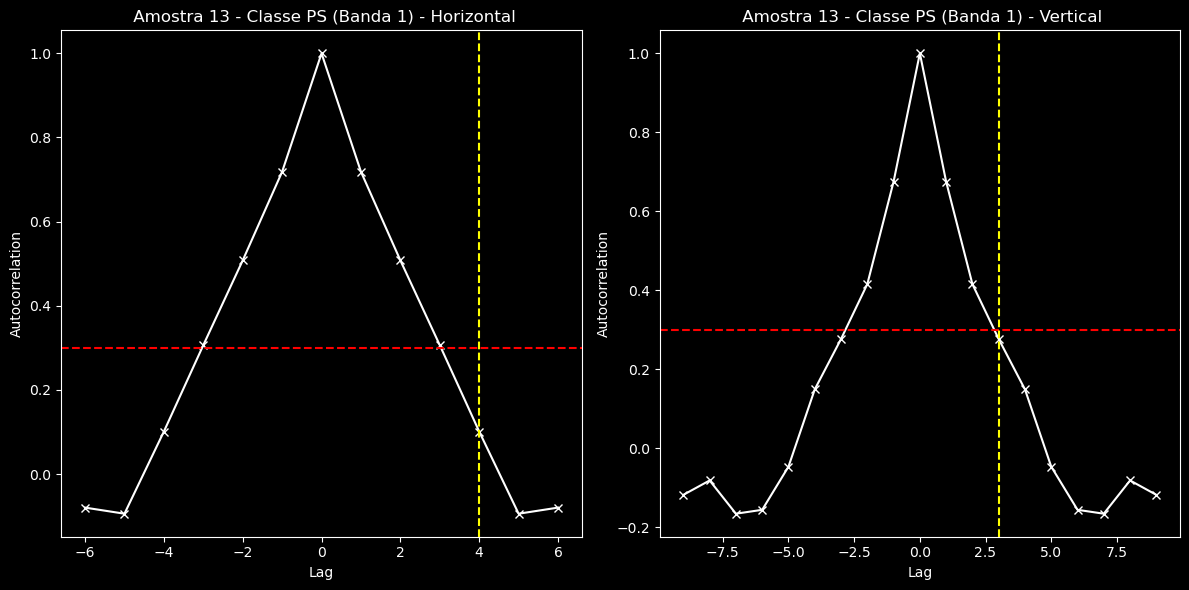

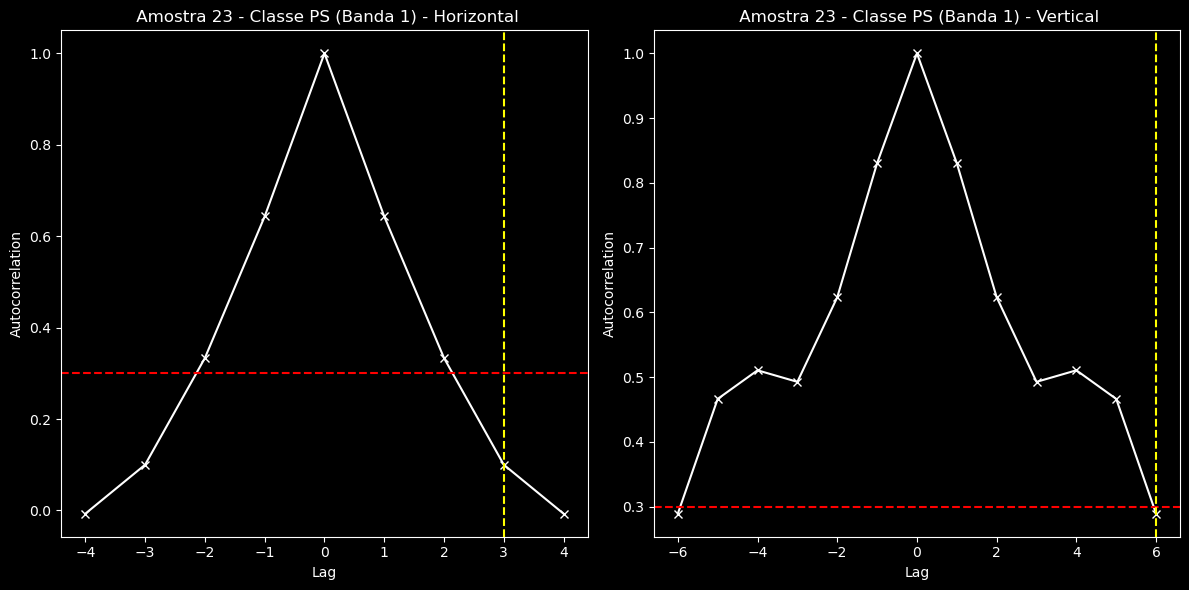

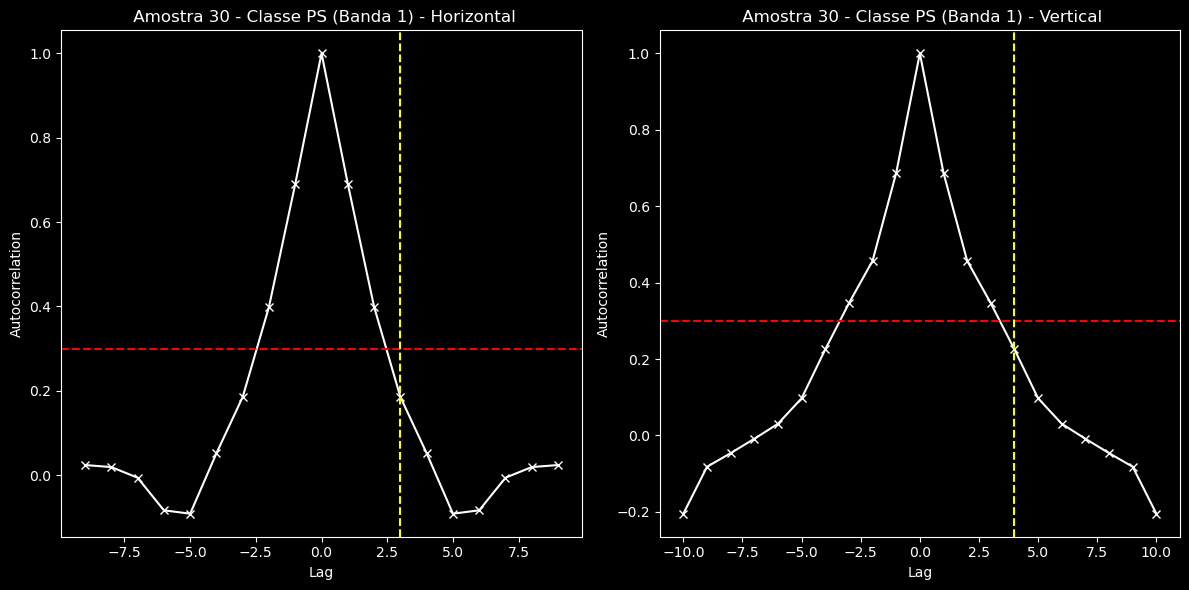

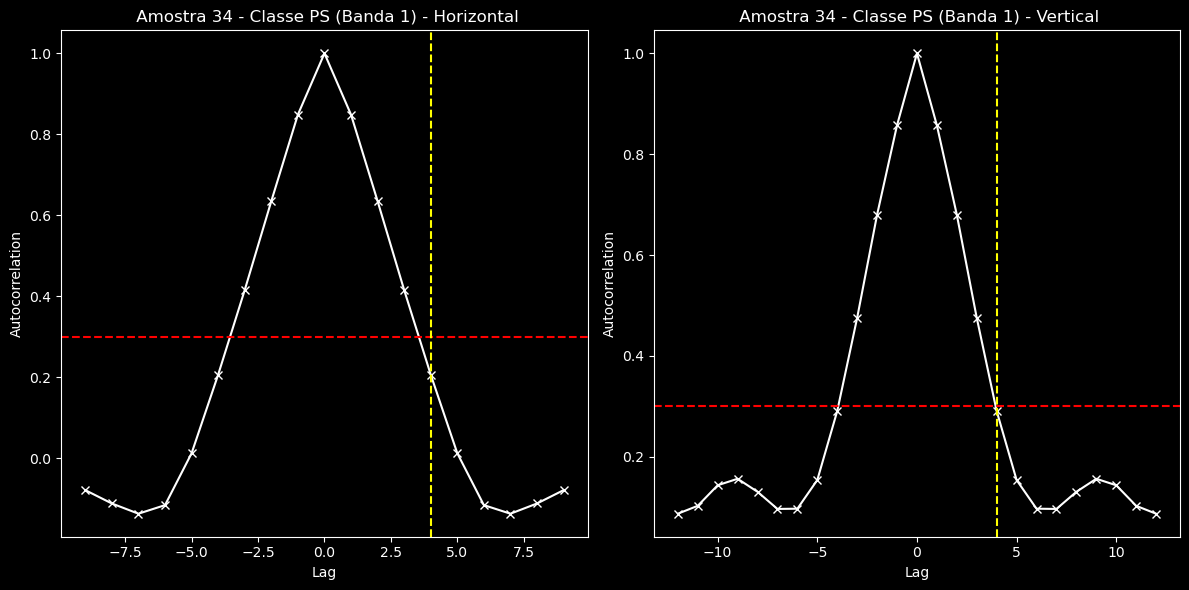

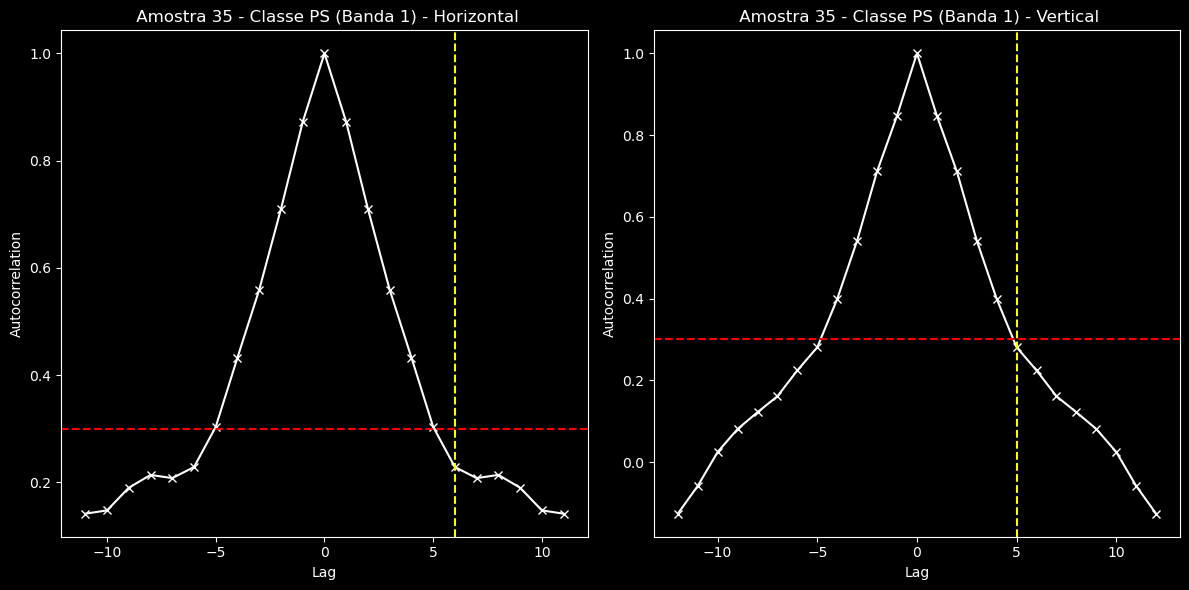

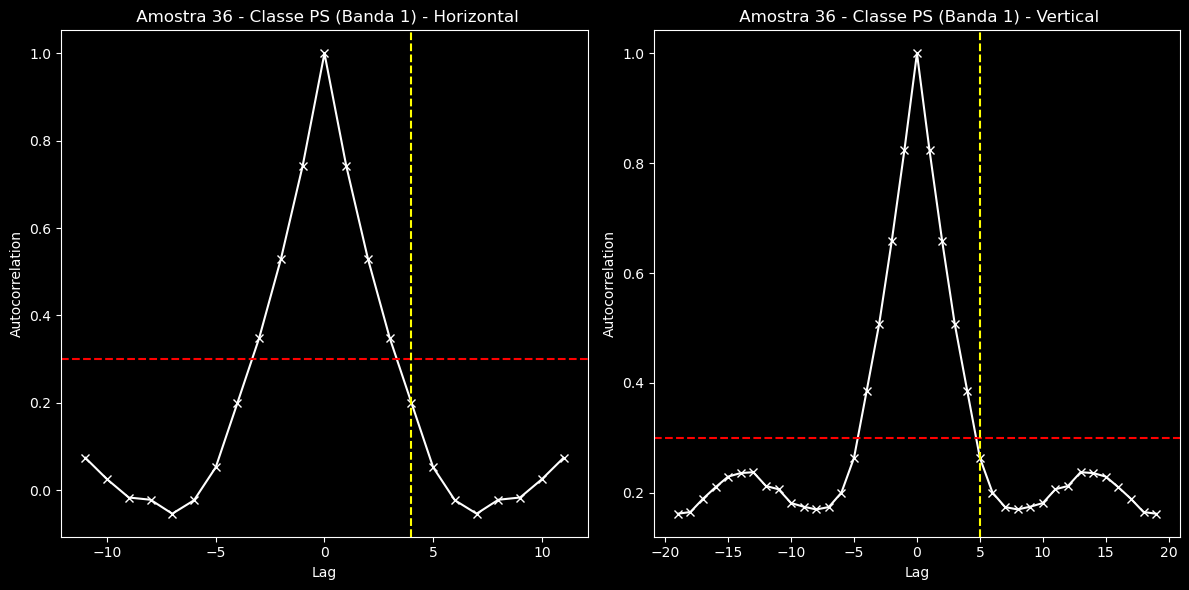

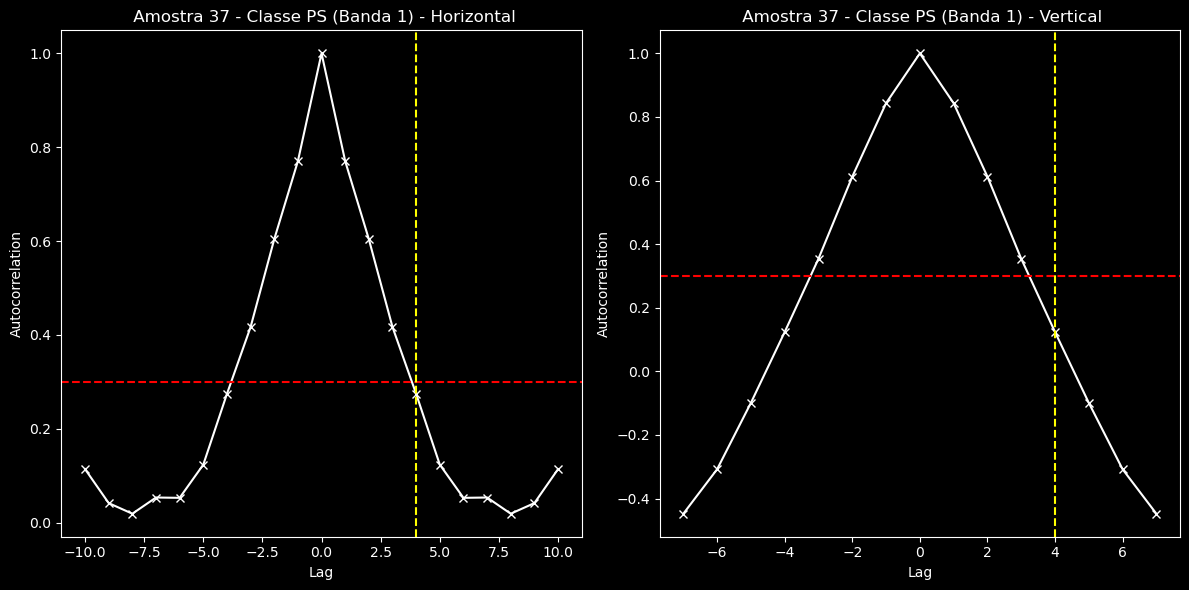

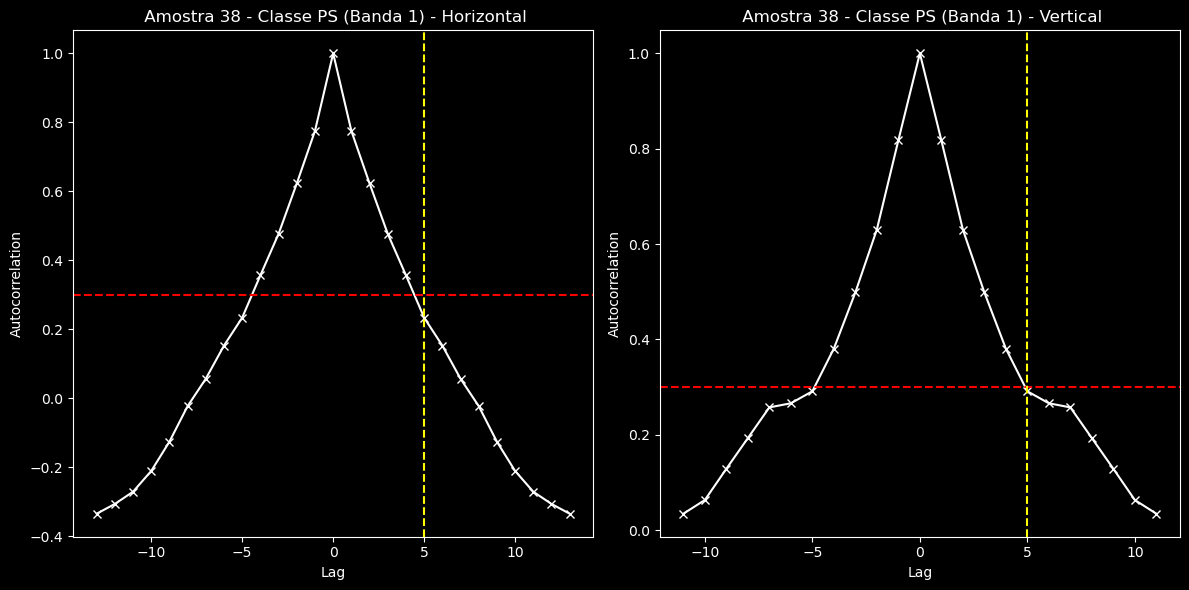

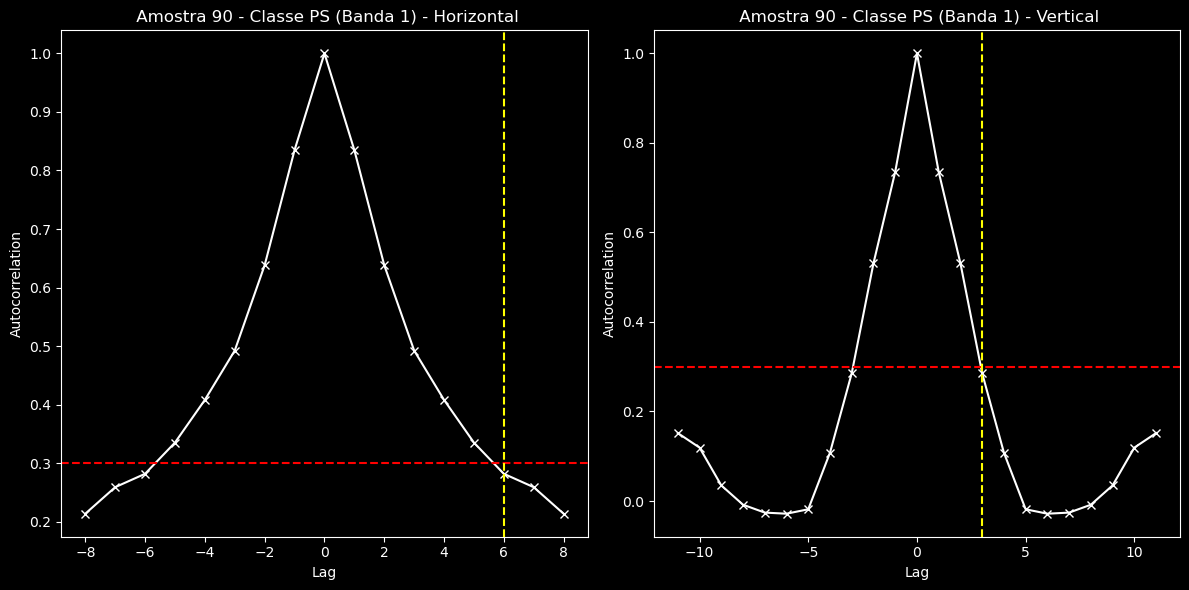

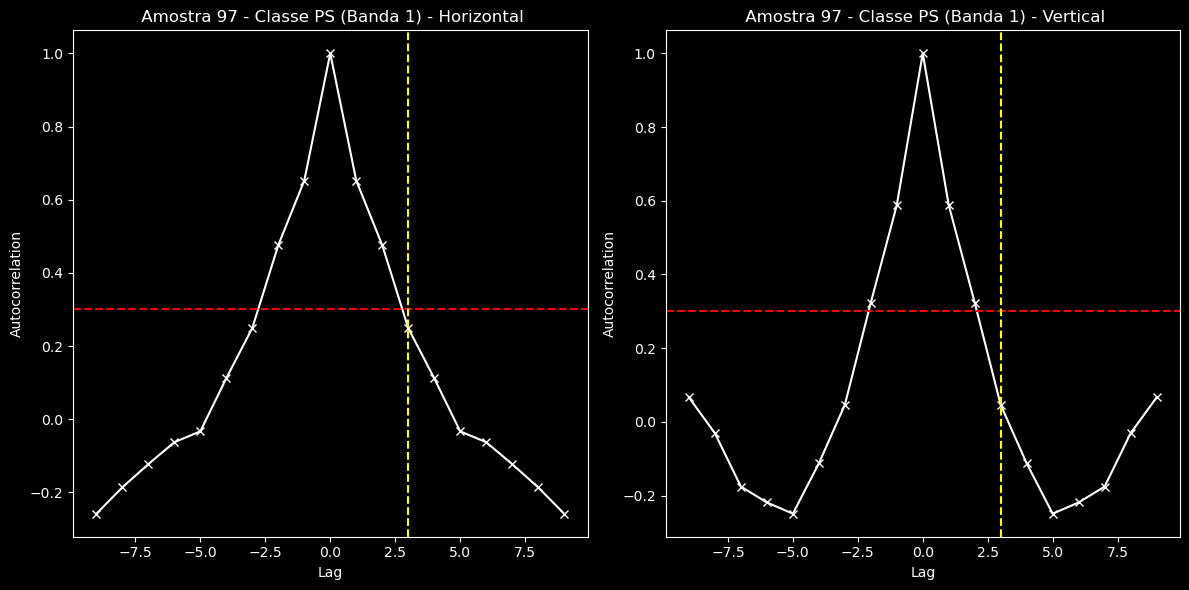

Erro ao calcular lags do polígono 97: '>' not supported between instances of 'float' and 'NoneType'


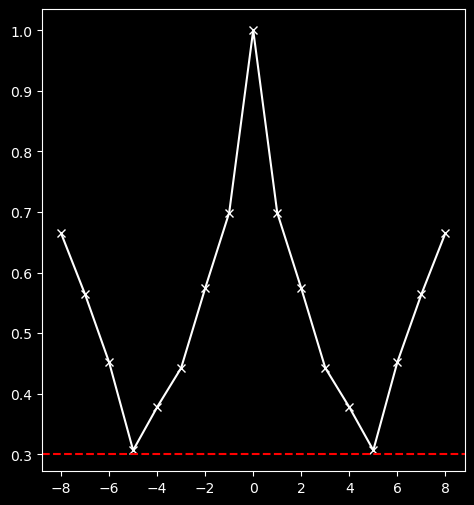

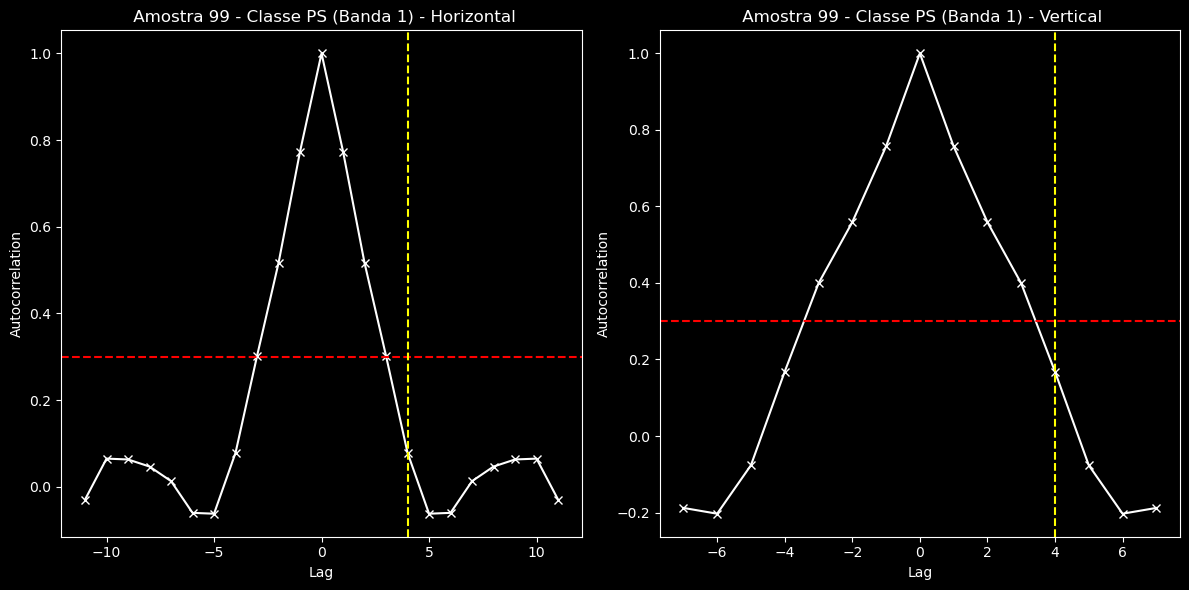

Lags Horizontais [4, 4, 3, 4, 3, 3, 4, 6, 4, 4, 5, 6, 3, 4]
Lags Verticais [4, 8, 5, 3, 6, 4, 4, 5, 5, 4, 5, 3, 3, 4]
Lag mediano horizontal para a classe PS: 4.0
Lag máximo horizontal para a classe PS: 5
Lag mediano vertical para a classe PS: 4.0
Lag máximo vertical para a classe PS: 6
-----------------------------------------------------------------------------------
Processando classe SE.


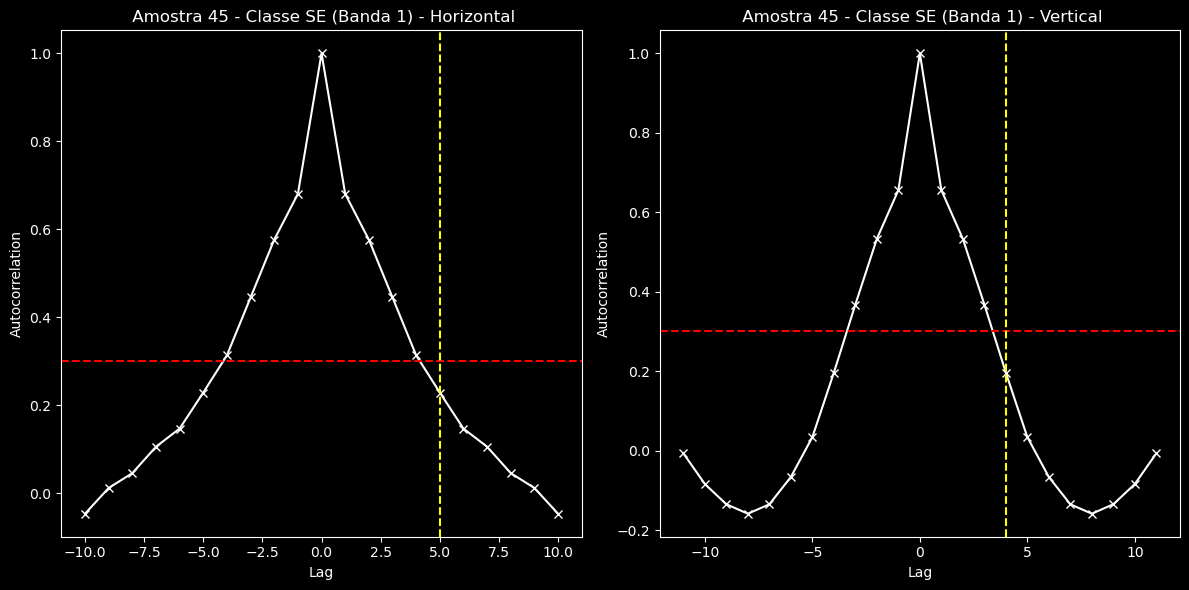

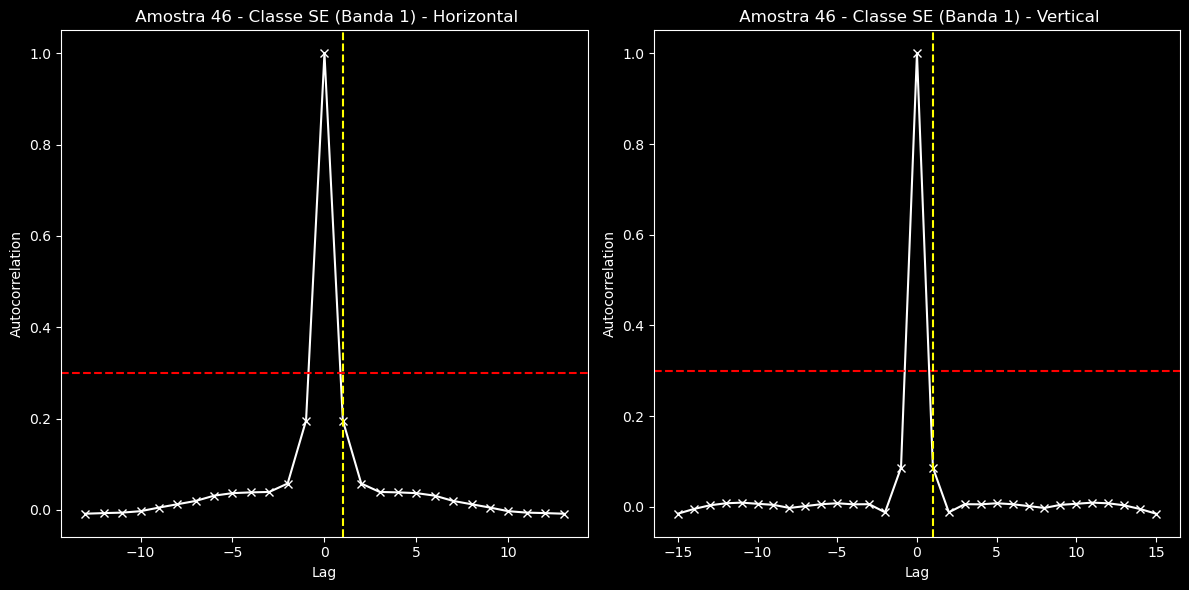

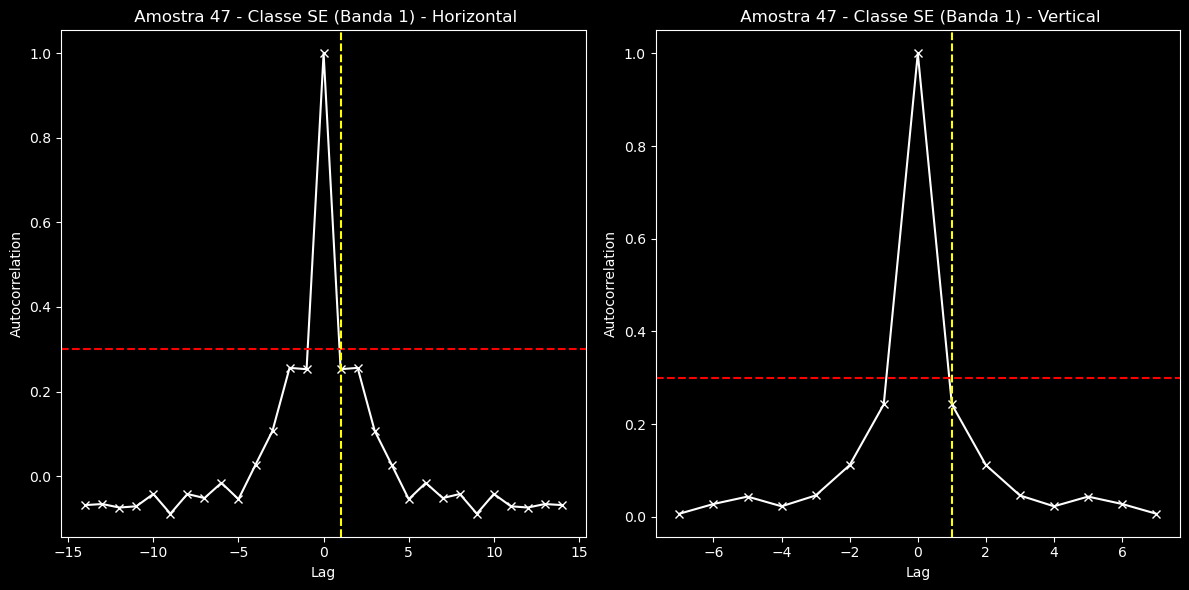

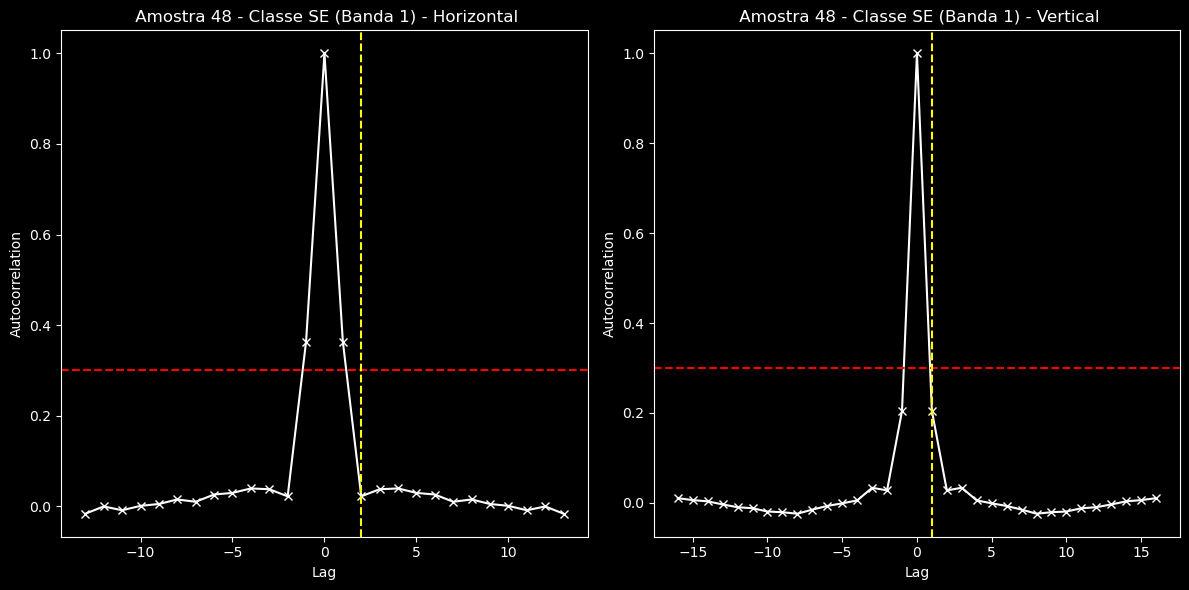

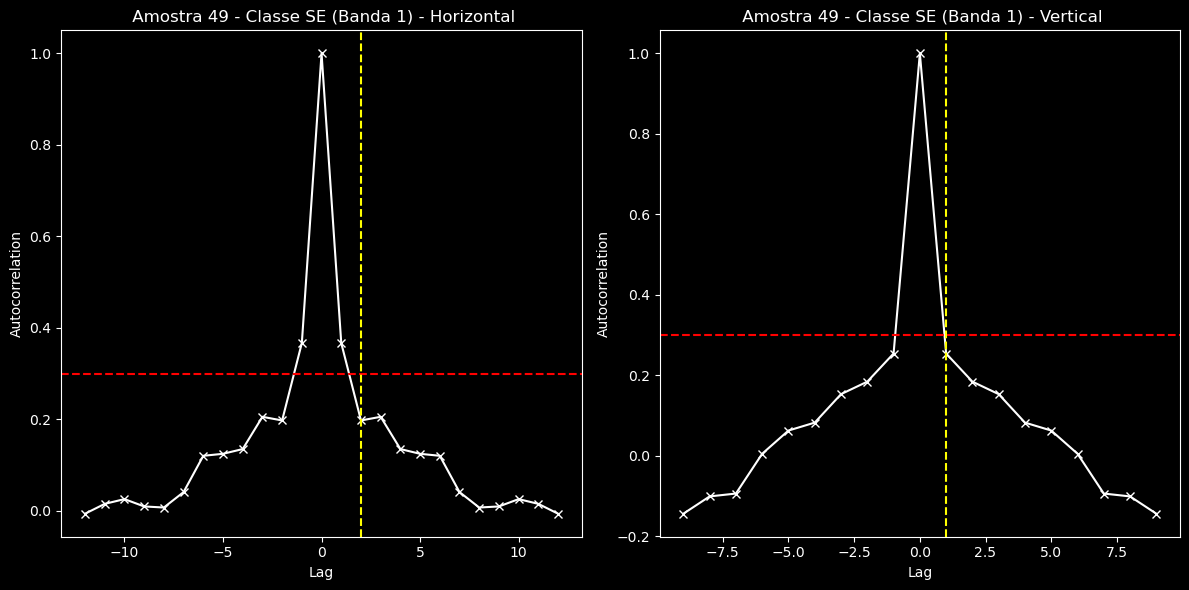

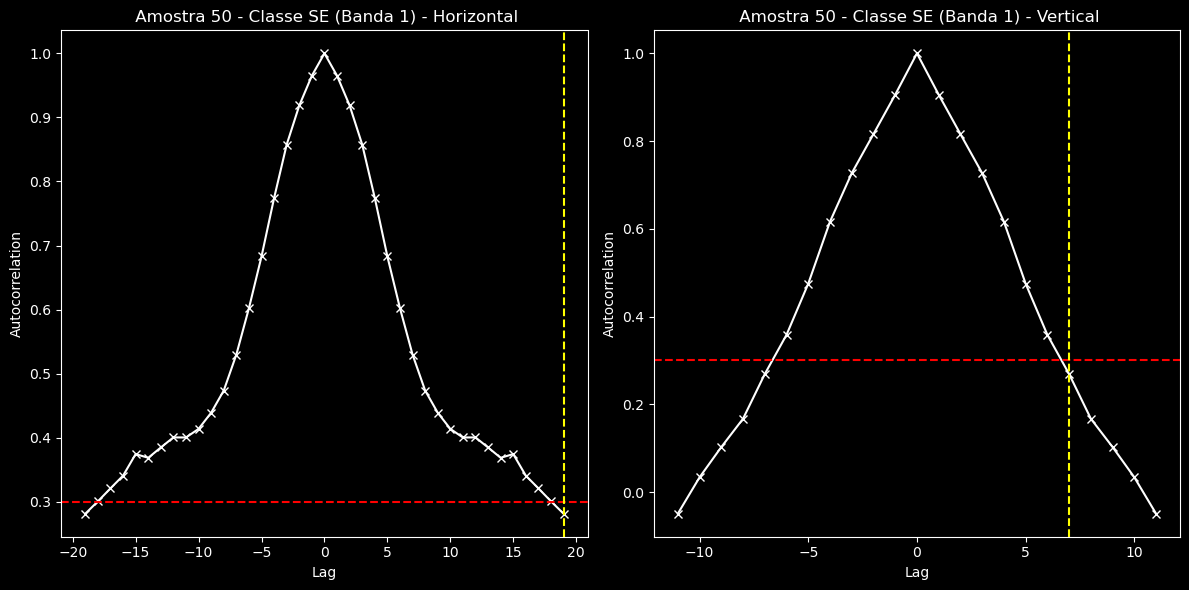

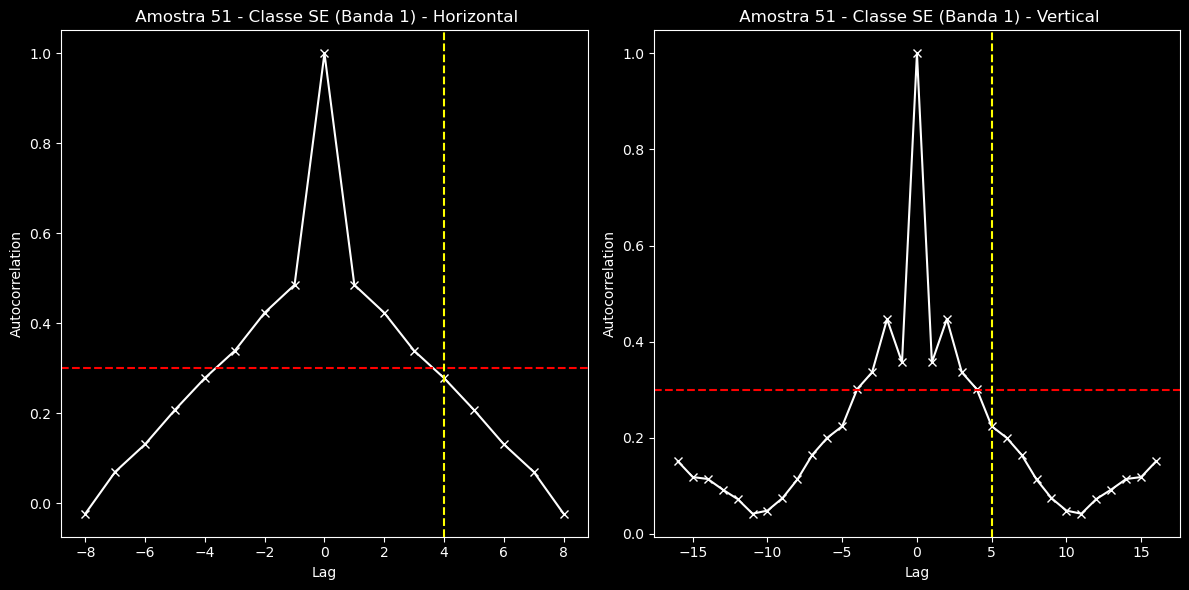

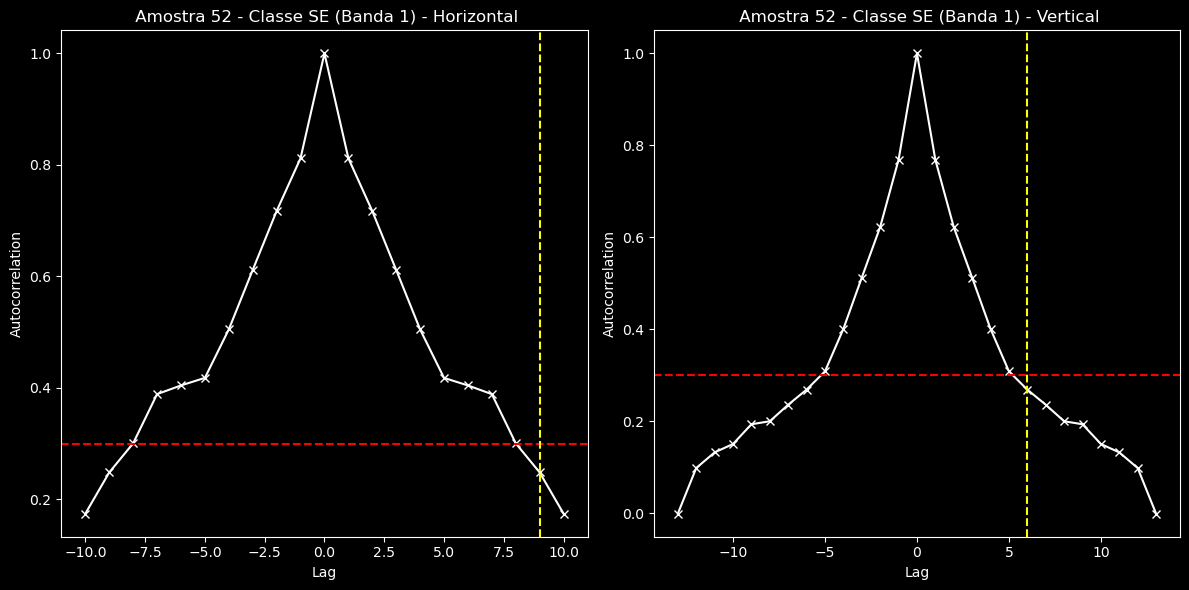

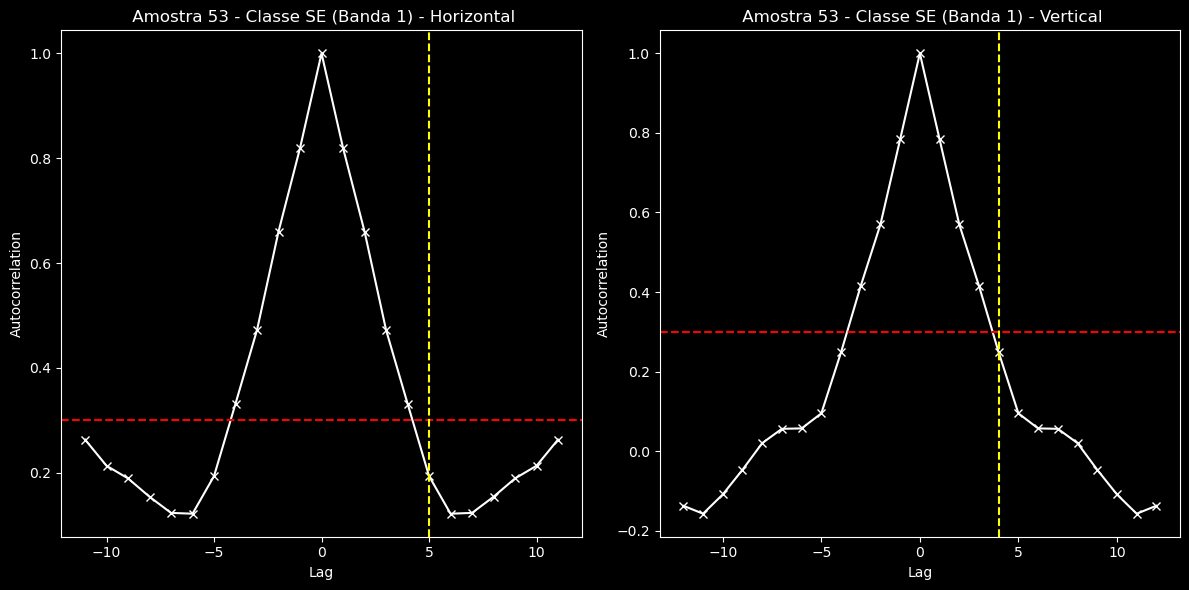

Erro ao calcular lags do polígono 53: '>' not supported between instances of 'float' and 'NoneType'


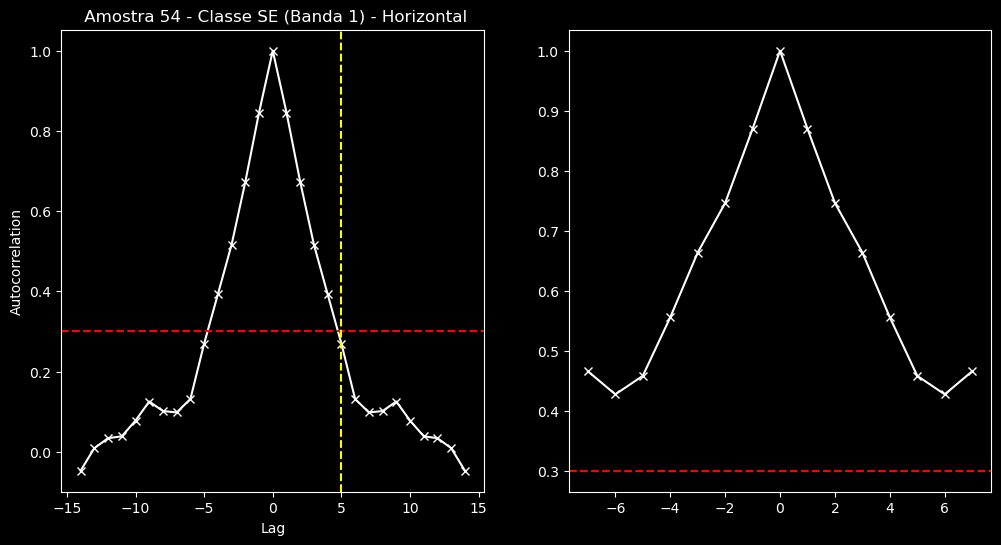

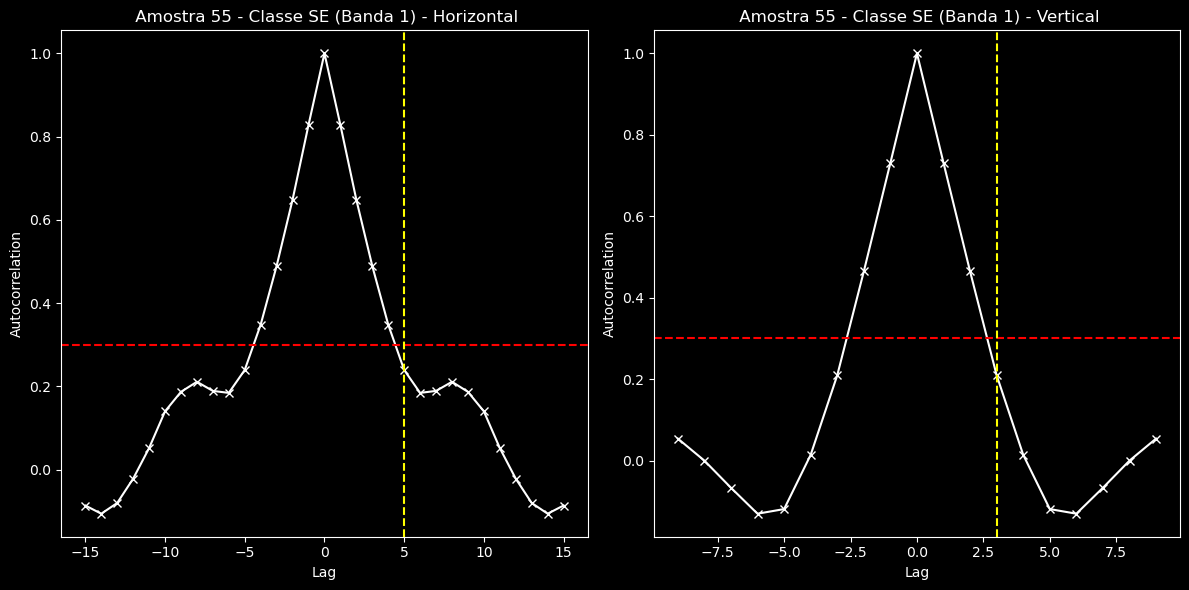

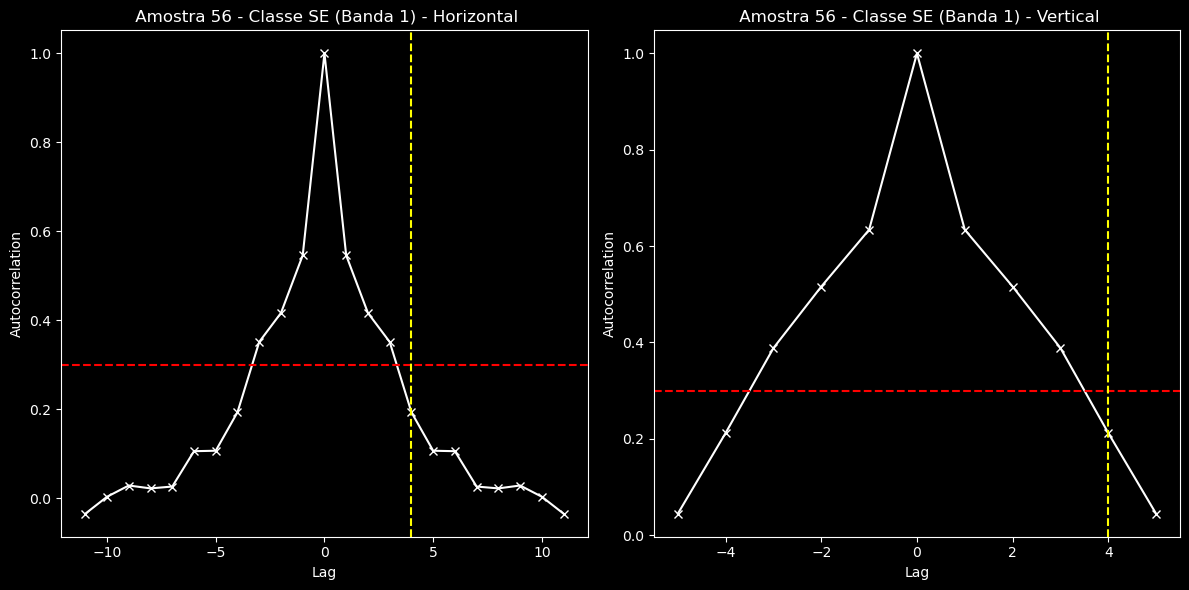

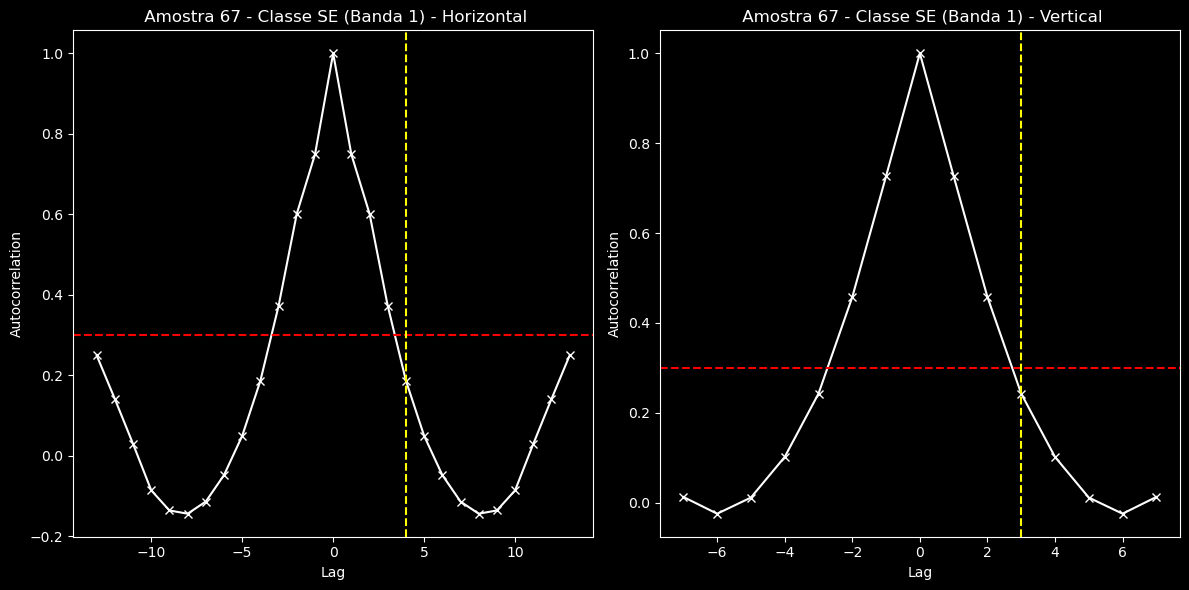

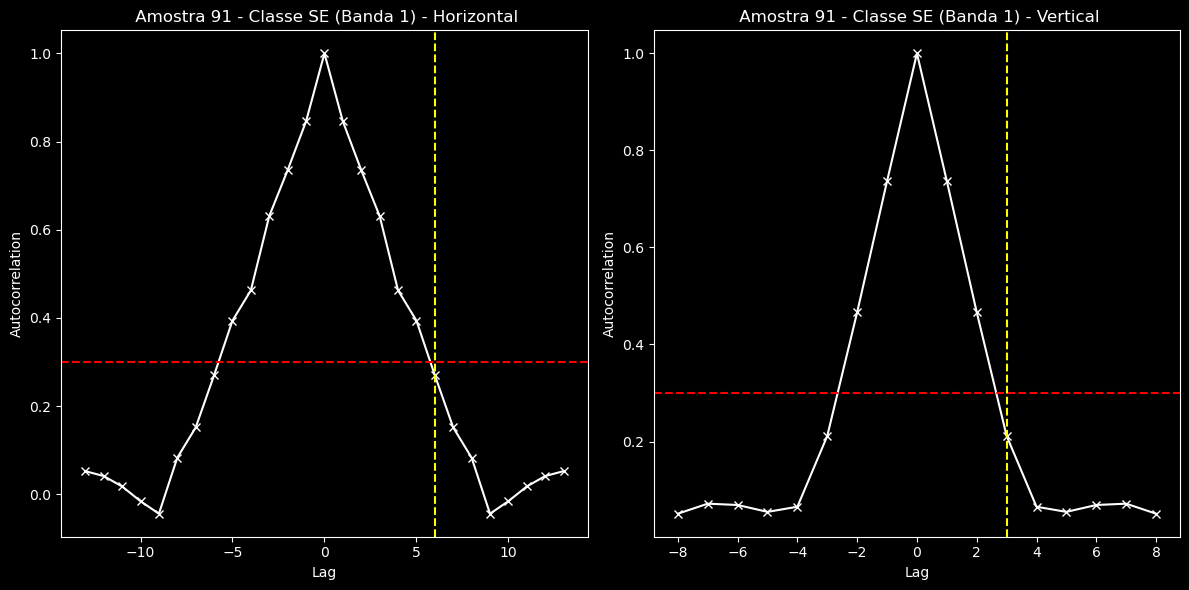

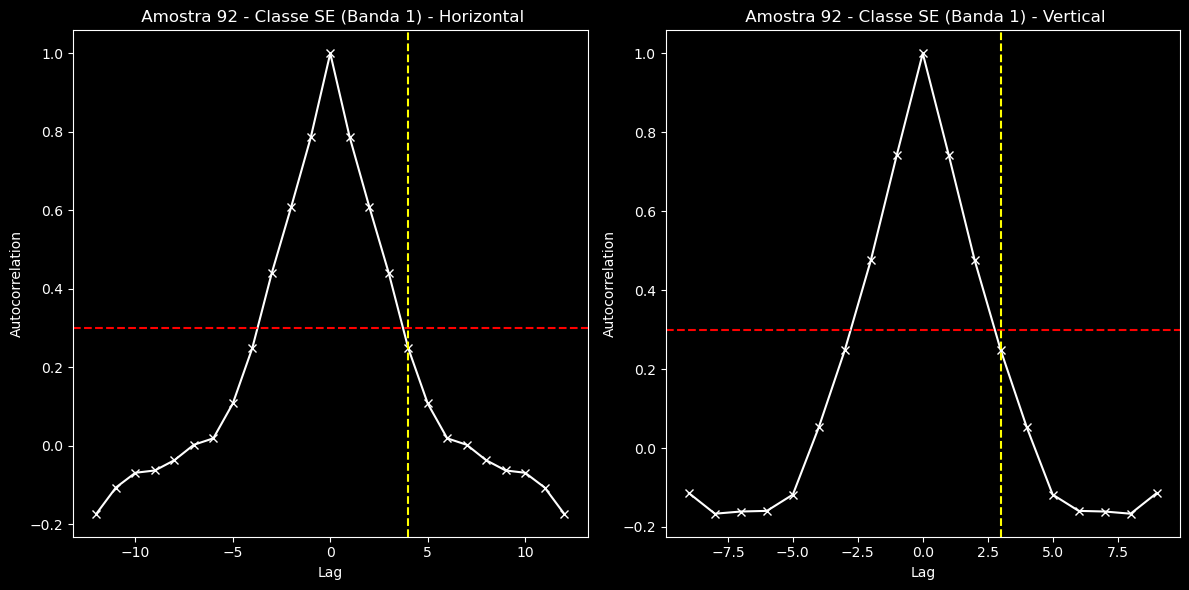

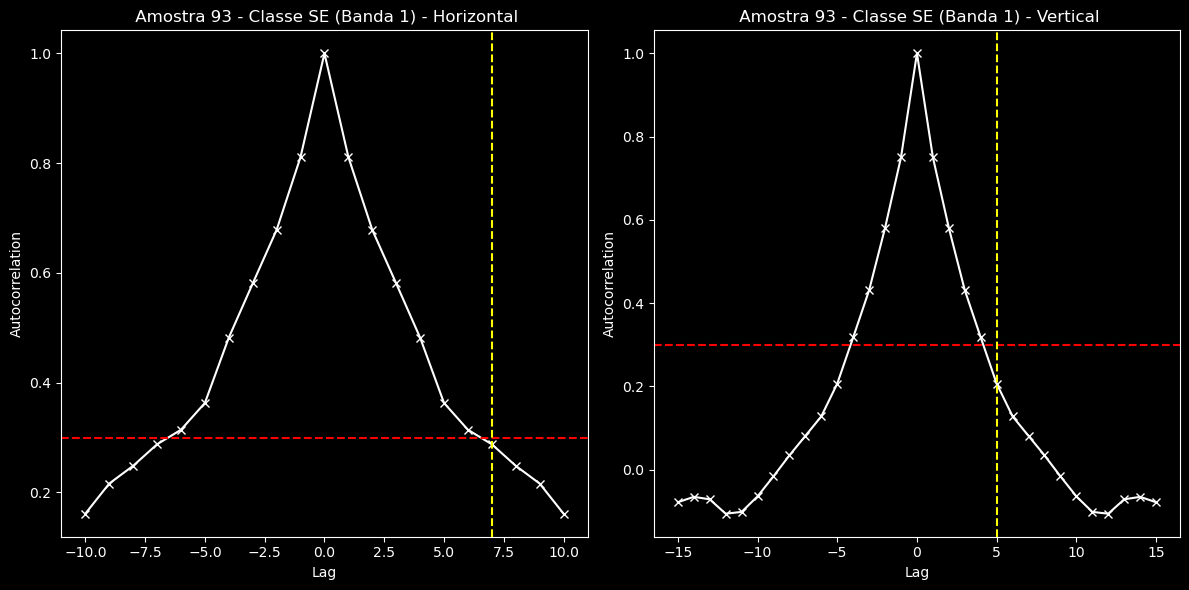

Lags Horizontais [5, 1, 1, 2, 2, 19, 4, 9, 5, 5, 4, 4, 6, 4, 7]
Lags Verticais [4, 1, 1, 1, 1, 7, 5, 6, 4, 3, 4, 3, 3, 3, 5]
Lag mediano horizontal para a classe SE: 4.0
Lag máximo horizontal para a classe SE: 9
Lag mediano vertical para a classe SE: 3.0
Lag máximo vertical para a classe SE: 7
-----------------------------------------------------------------------------------
Processando classe SS1.


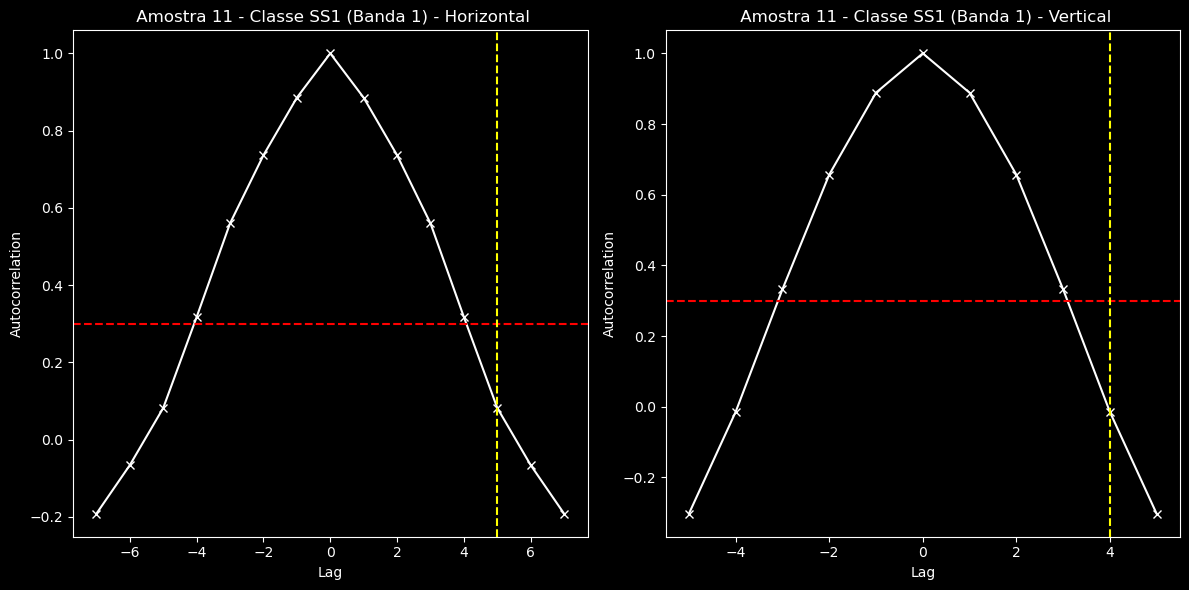

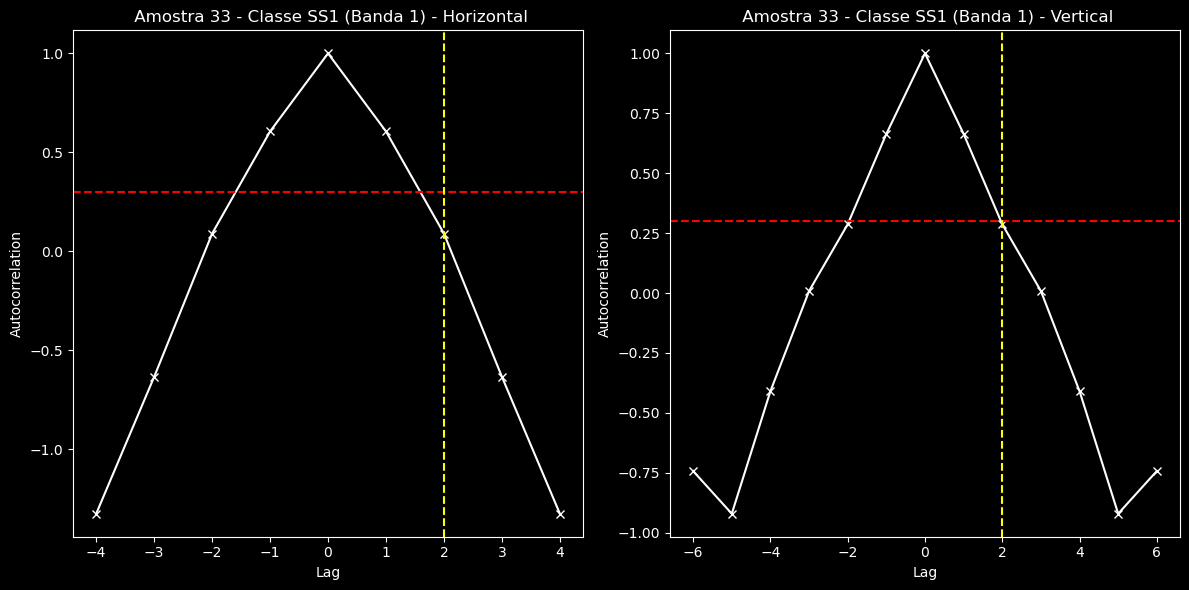

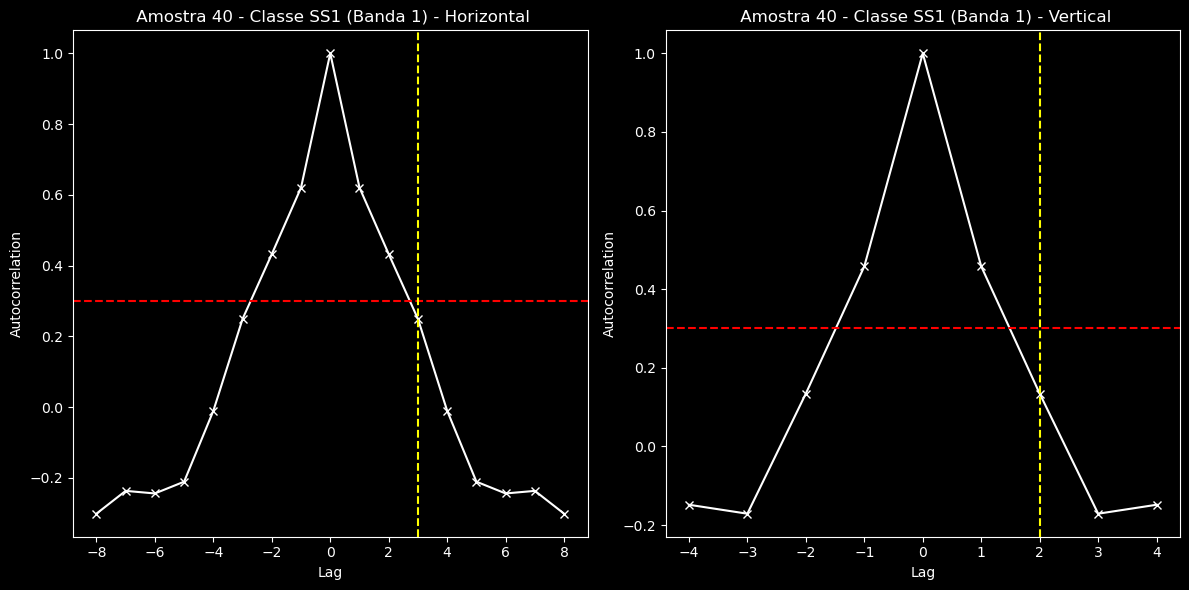

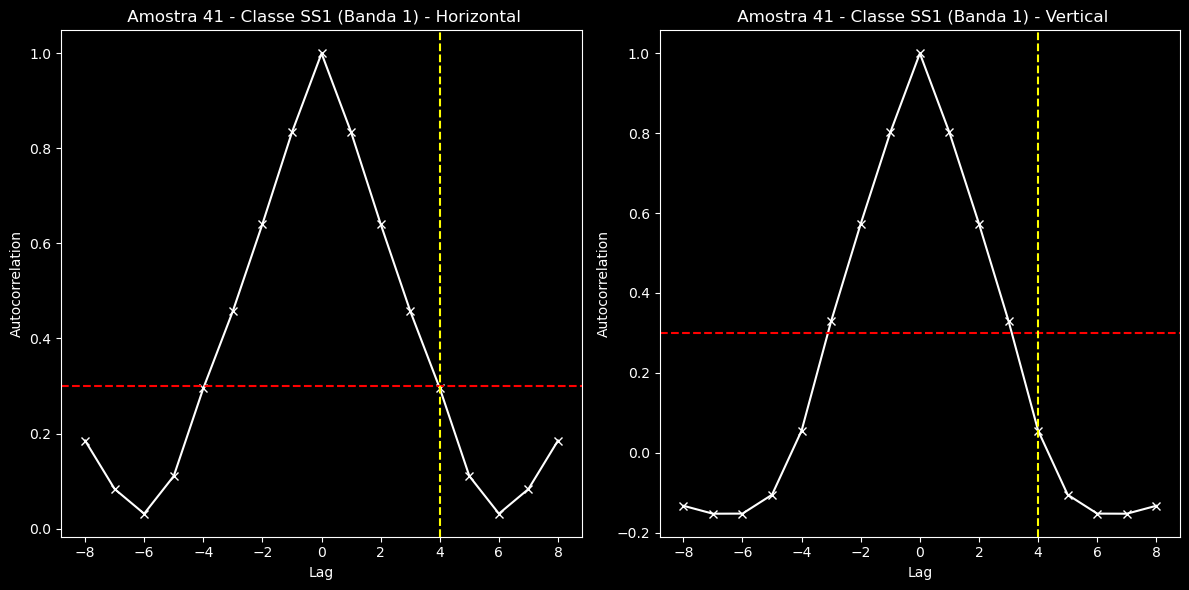

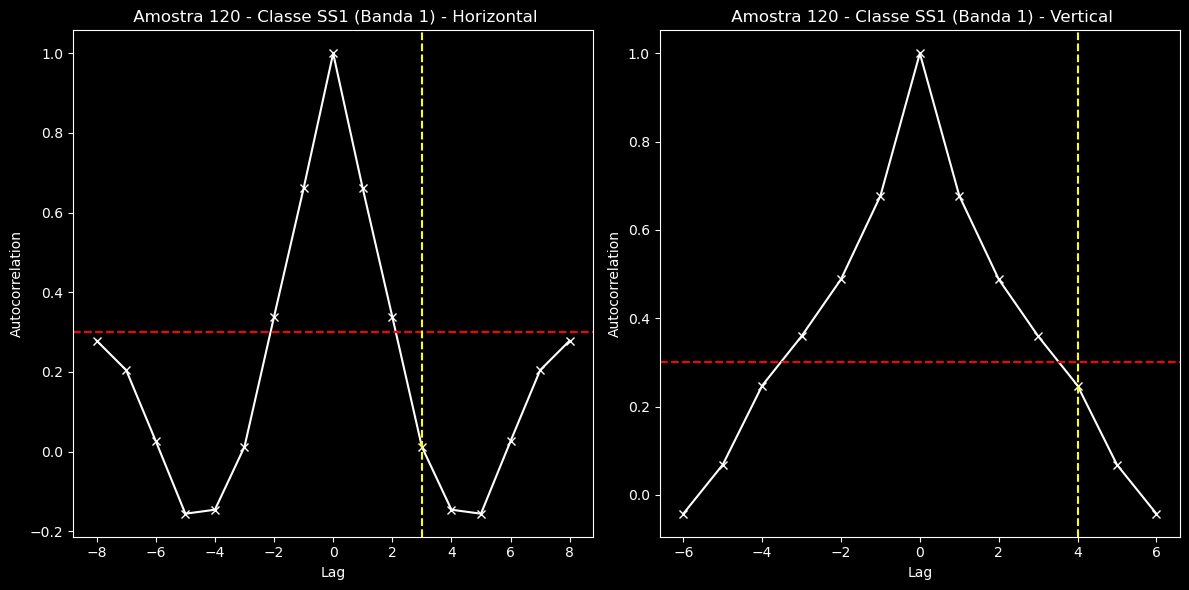

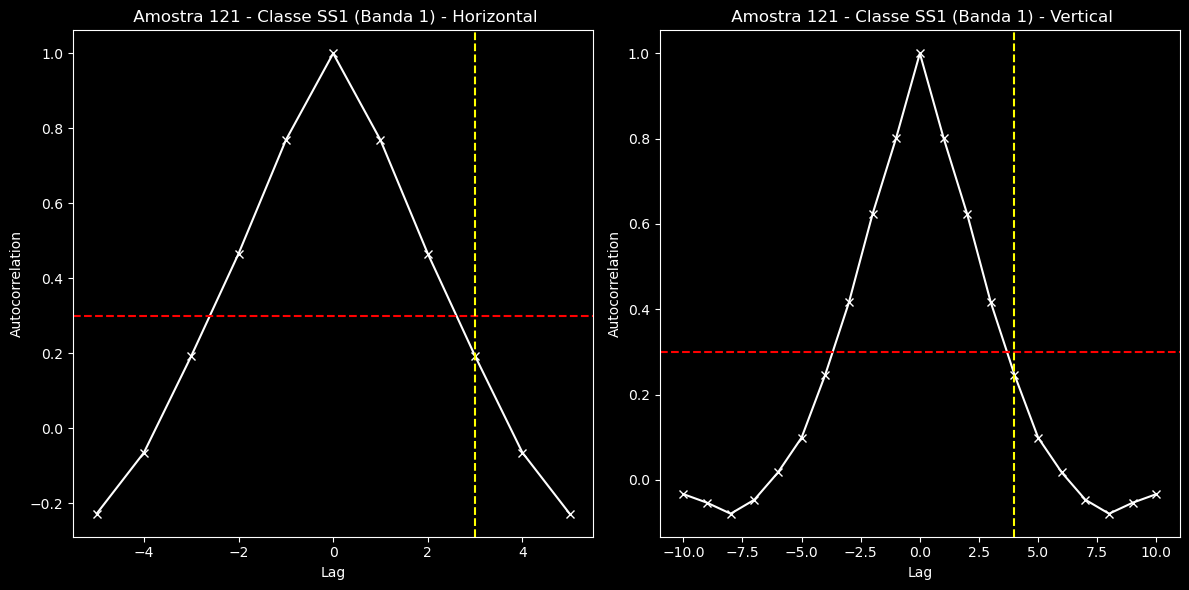

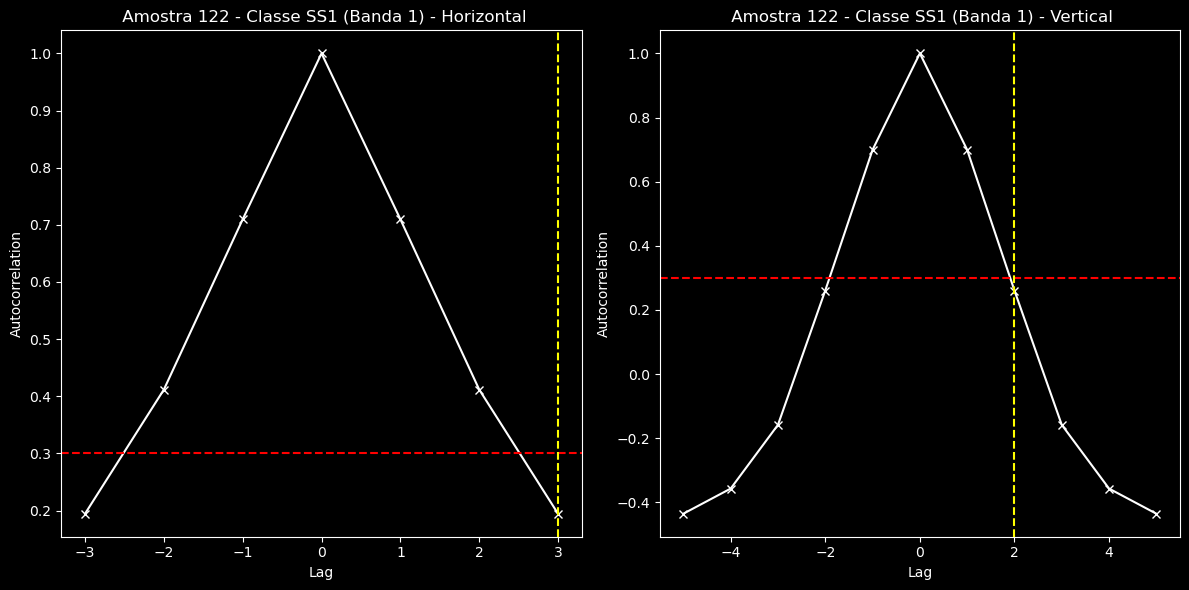

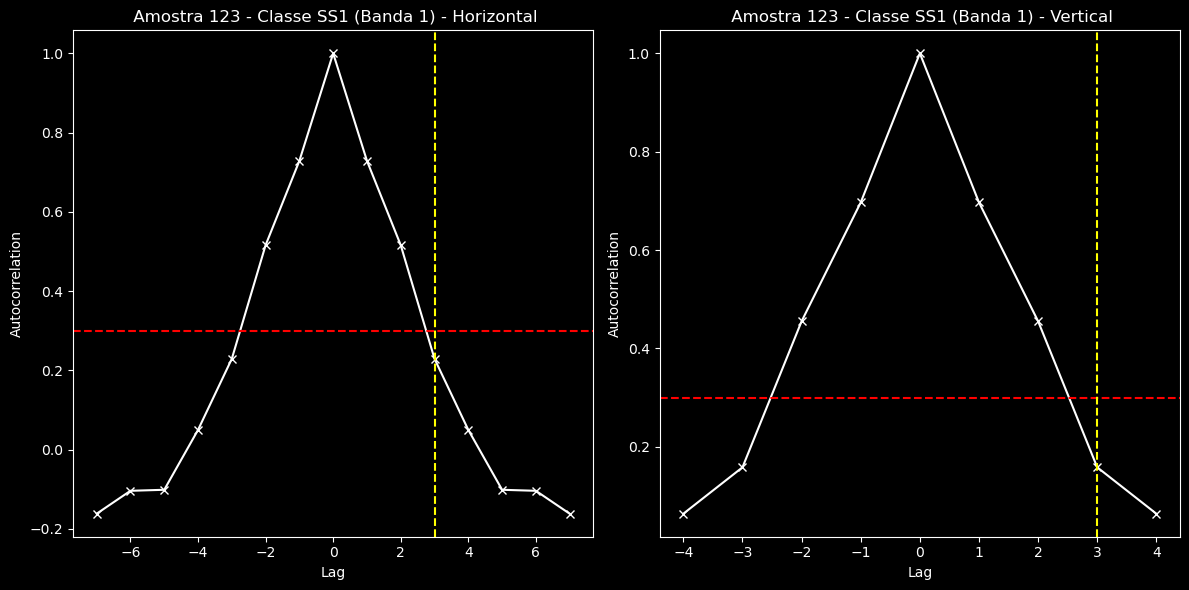

Erro ao calcular lags do polígono 123: '>' not supported between instances of 'float' and 'NoneType'
Erro ao calcular lags do polígono 124: '>' not supported between instances of 'float' and 'NoneType'


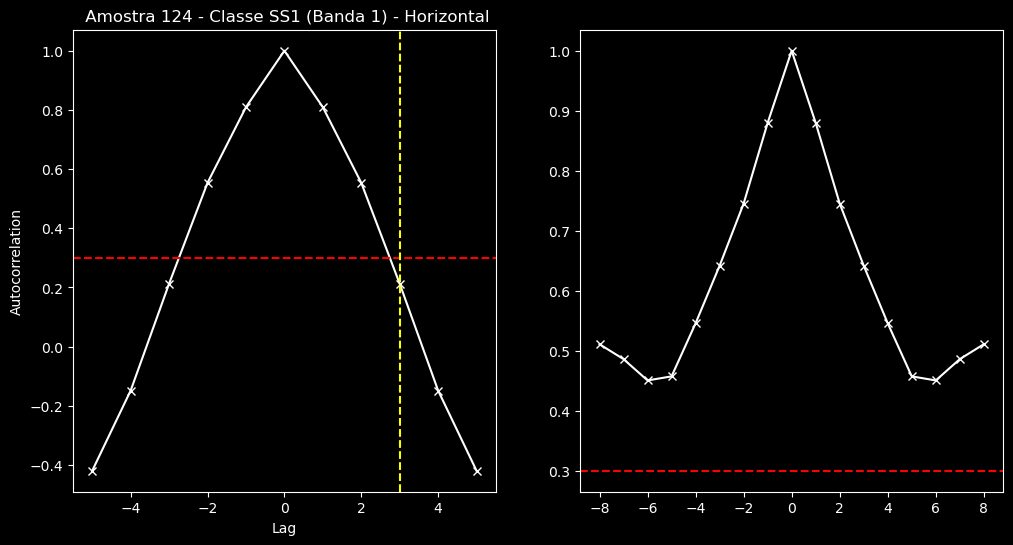

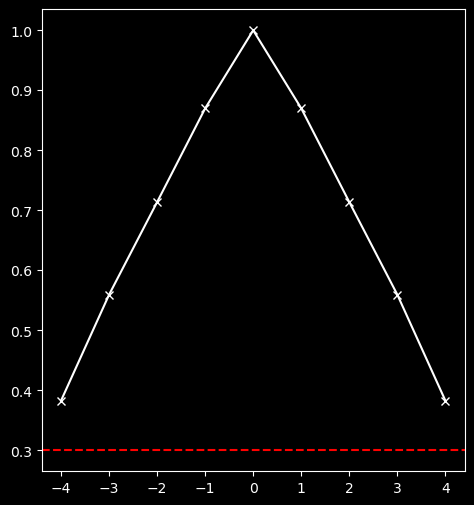

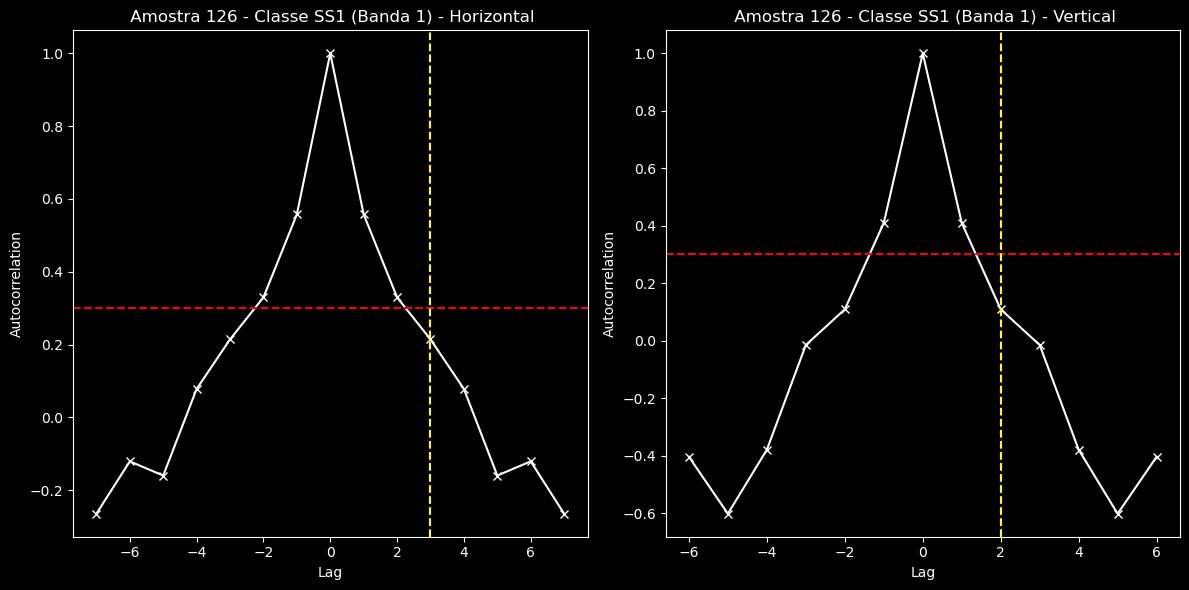

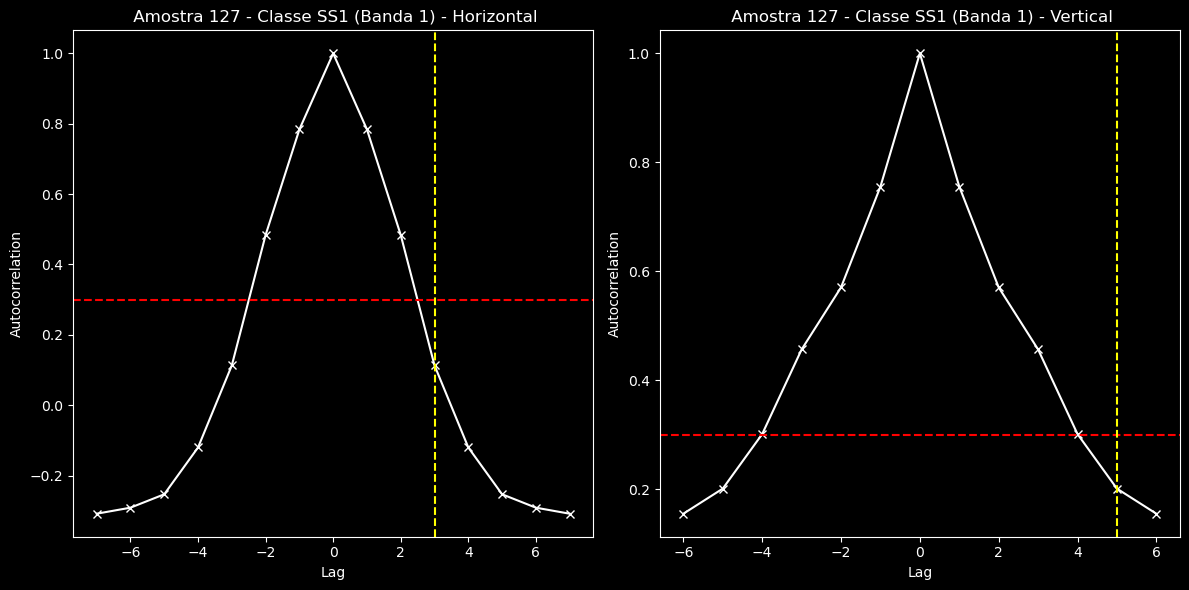

Lags Horizontais [5, 2, 3, 4, 3, 3, 3, 3, 3, 3]
Lags Verticais [4, 2, 2, 4, 4, 4, 2, 3, 2, 5]
Lag mediano horizontal para a classe SS1: 3.0
Lag máximo horizontal para a classe SS1: 3
Lag mediano vertical para a classe SS1: 3.5
Lag máximo vertical para a classe SS1: 5
-----------------------------------------------------------------------------------
Processando classe SS2.


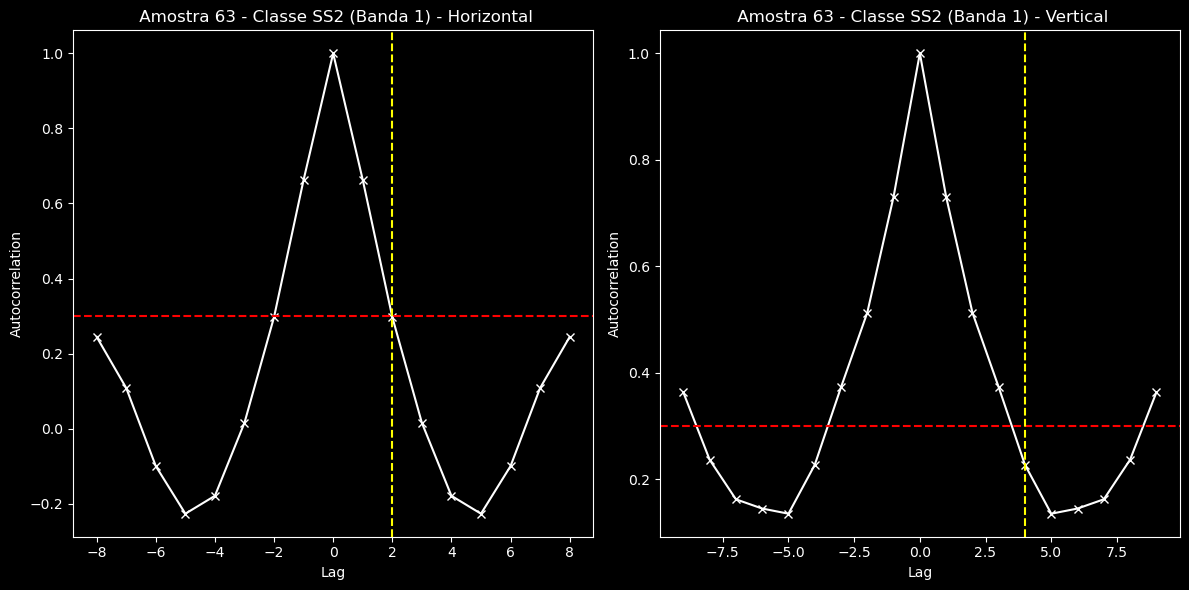

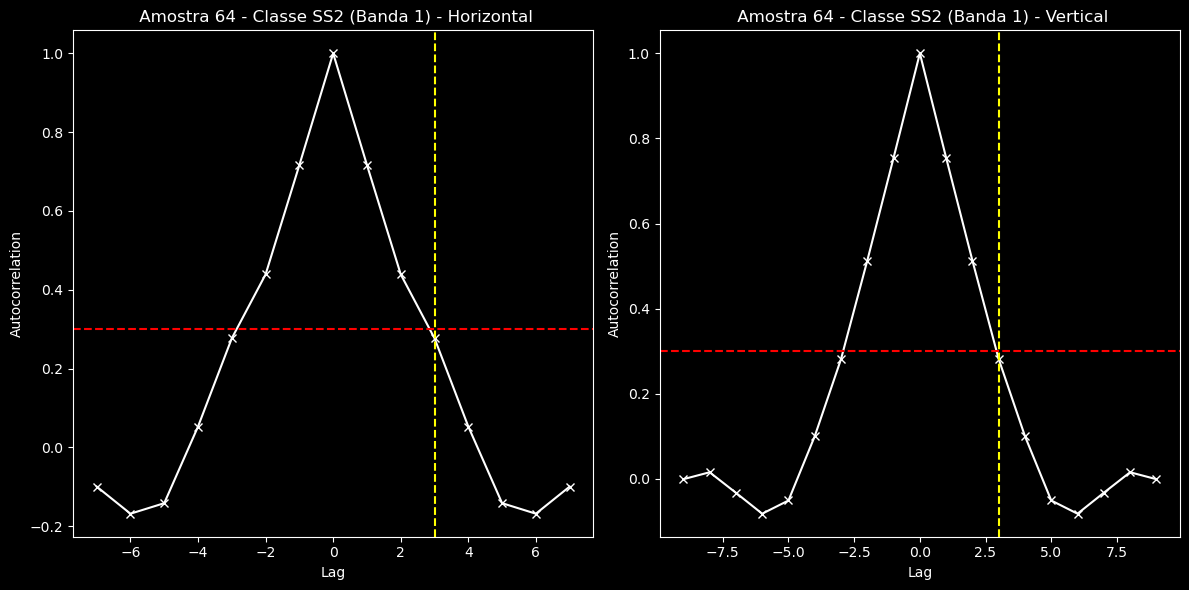

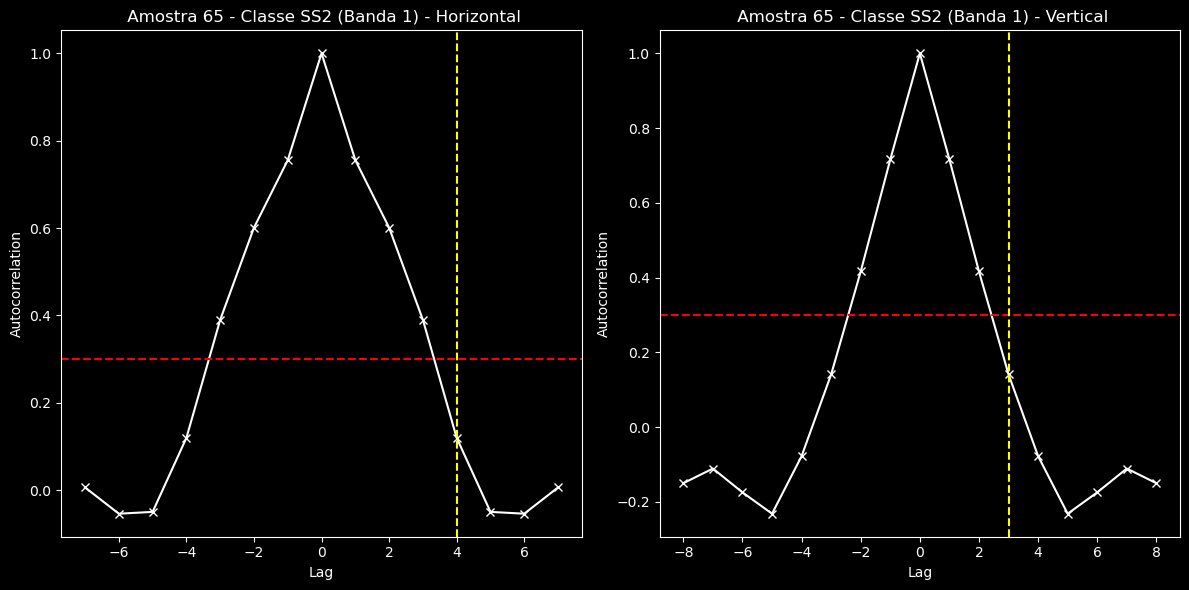

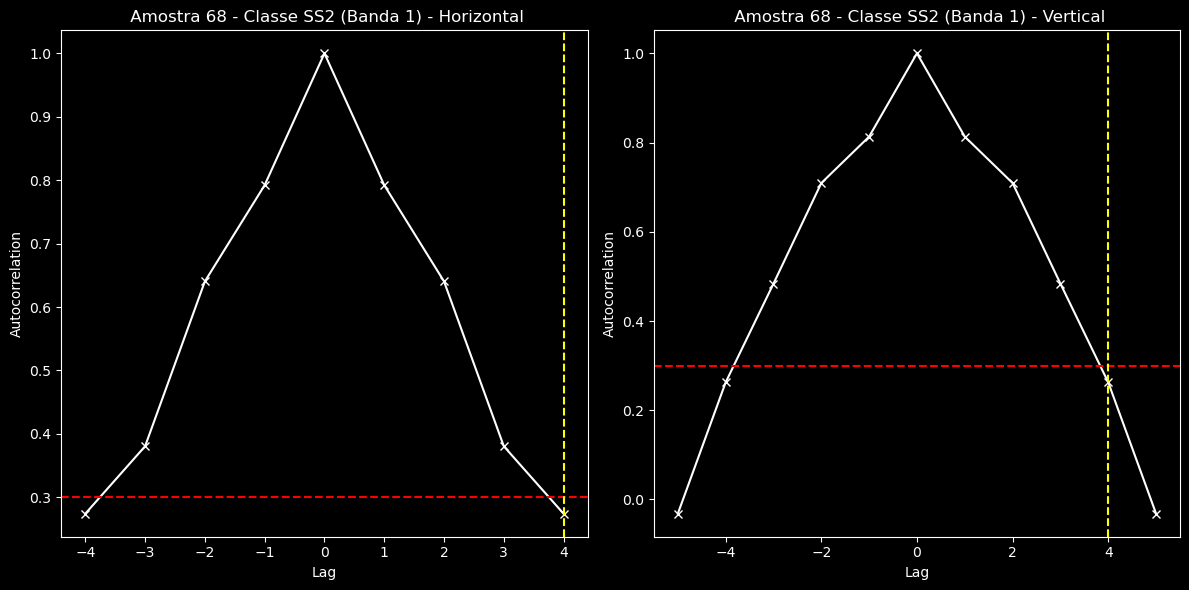

Erro ao calcular lags do polígono 68: '>' not supported between instances of 'float' and 'NoneType'


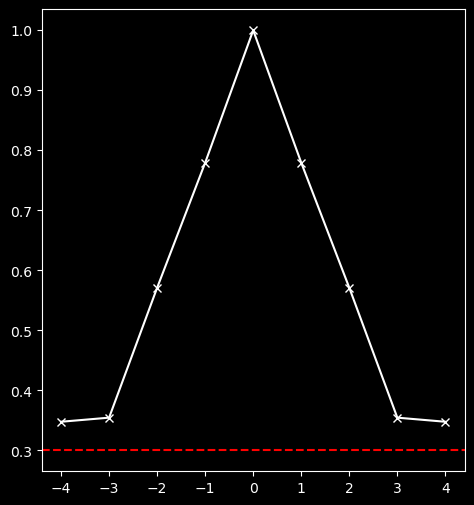

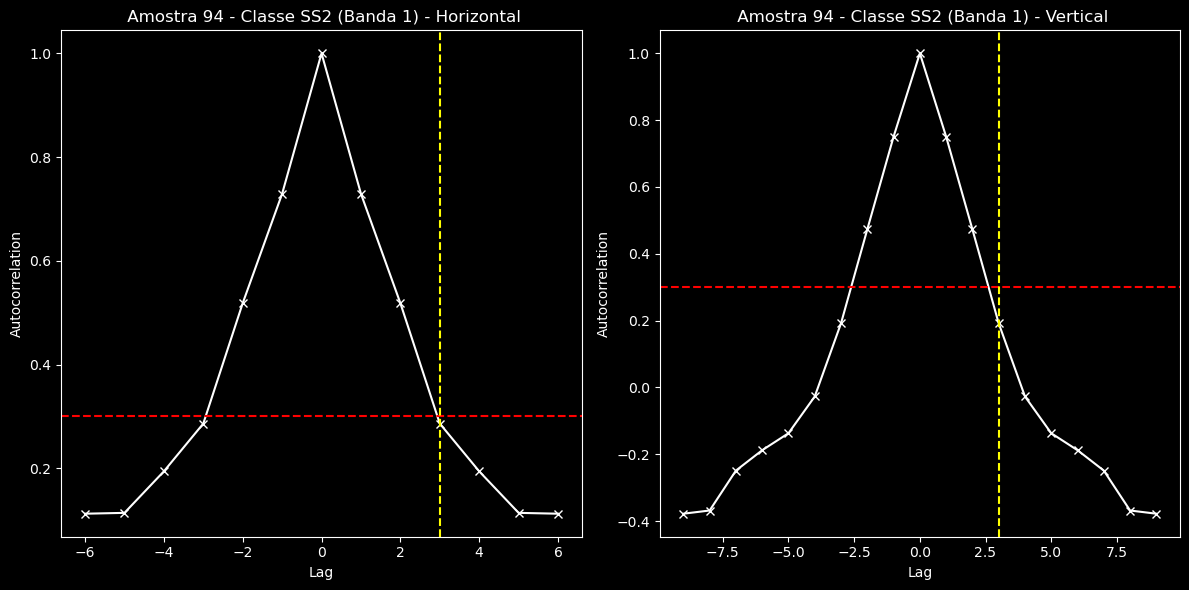

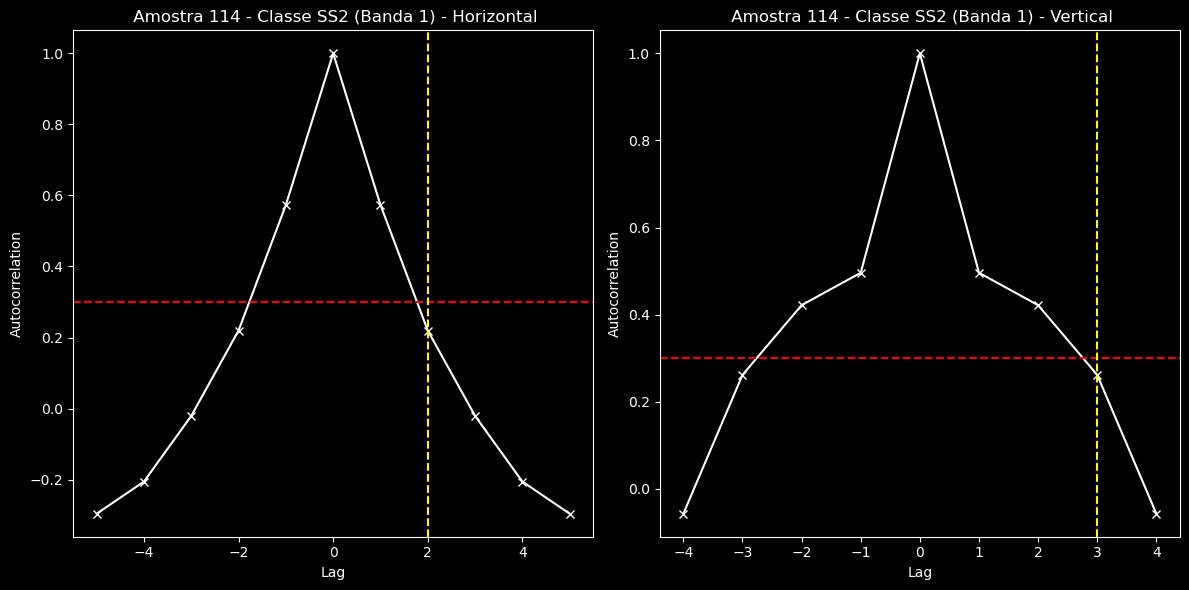

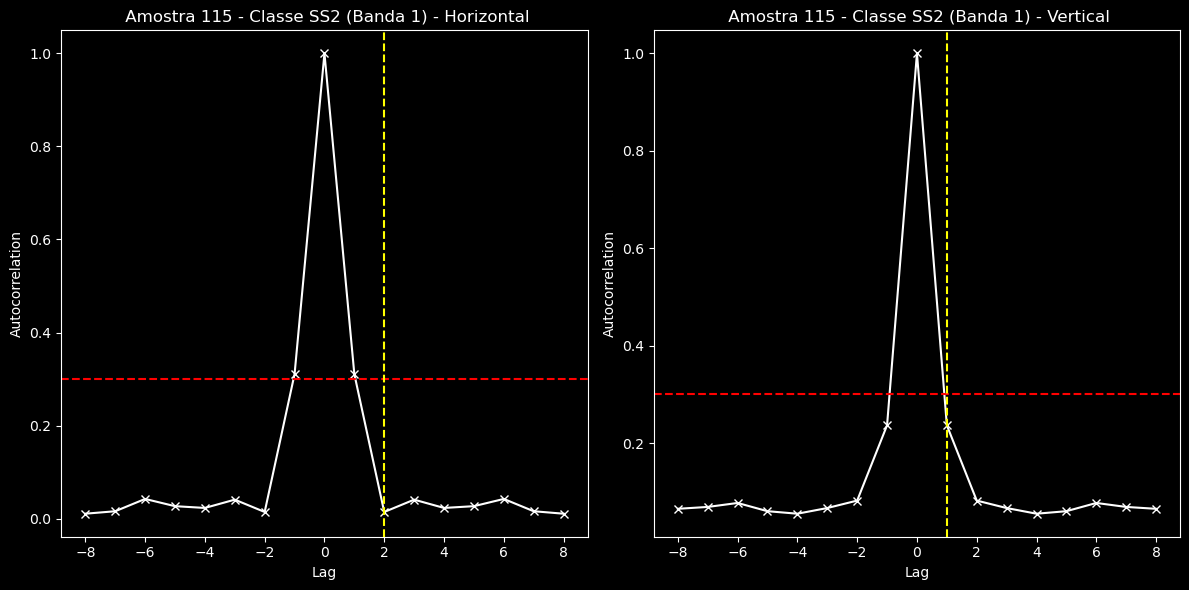

Erro ao calcular lags do polígono 115: '>' not supported between instances of 'float' and 'NoneType'


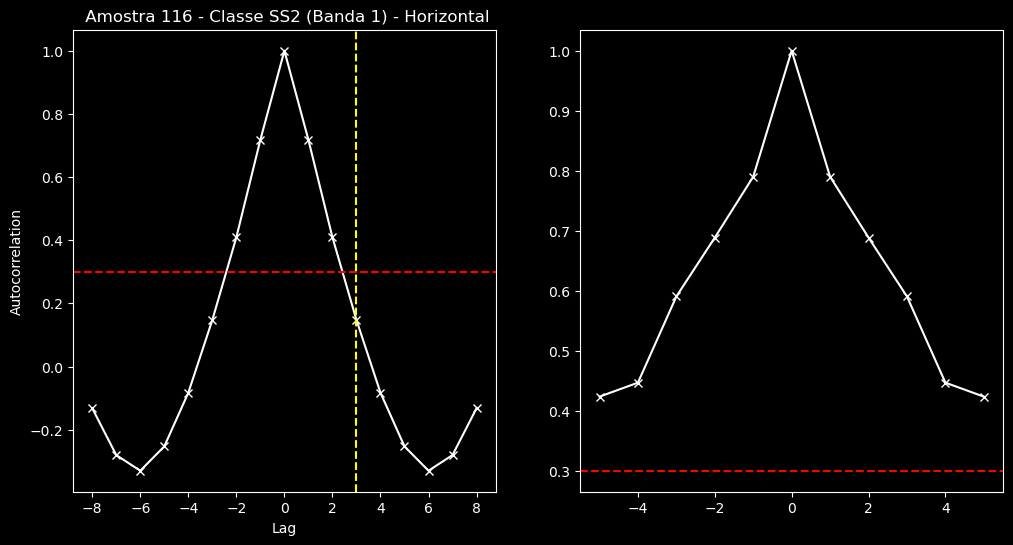

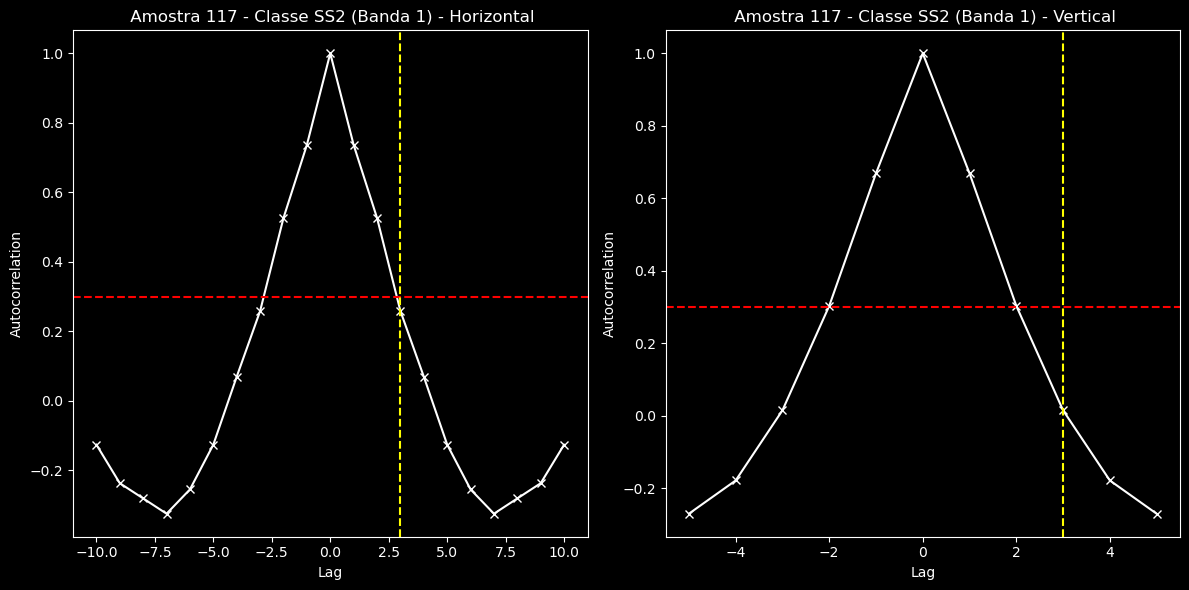

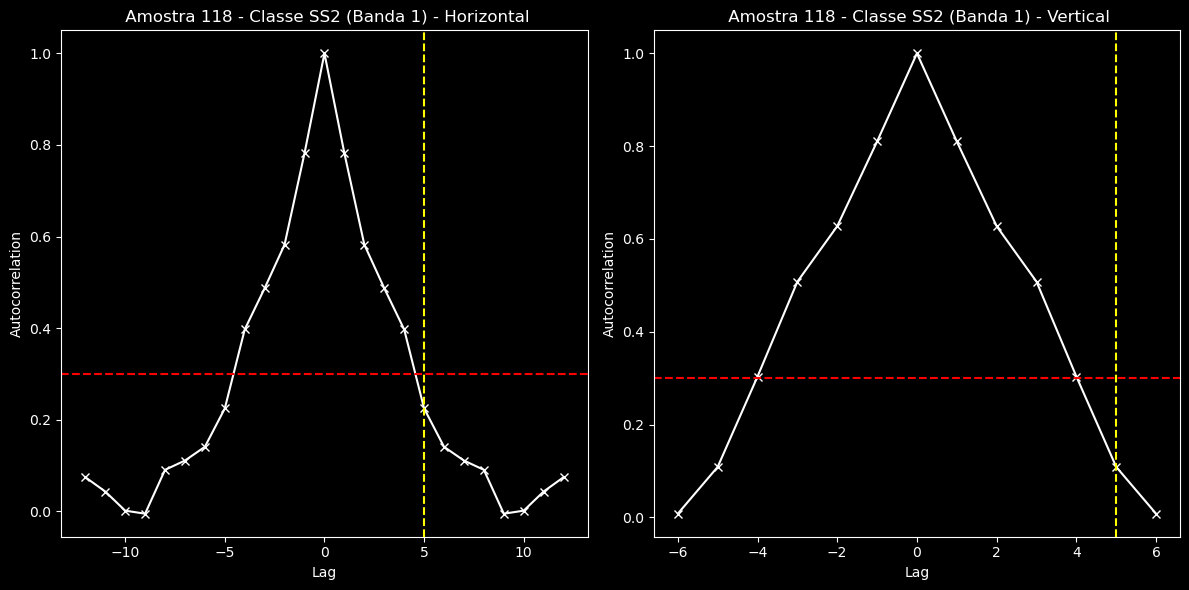

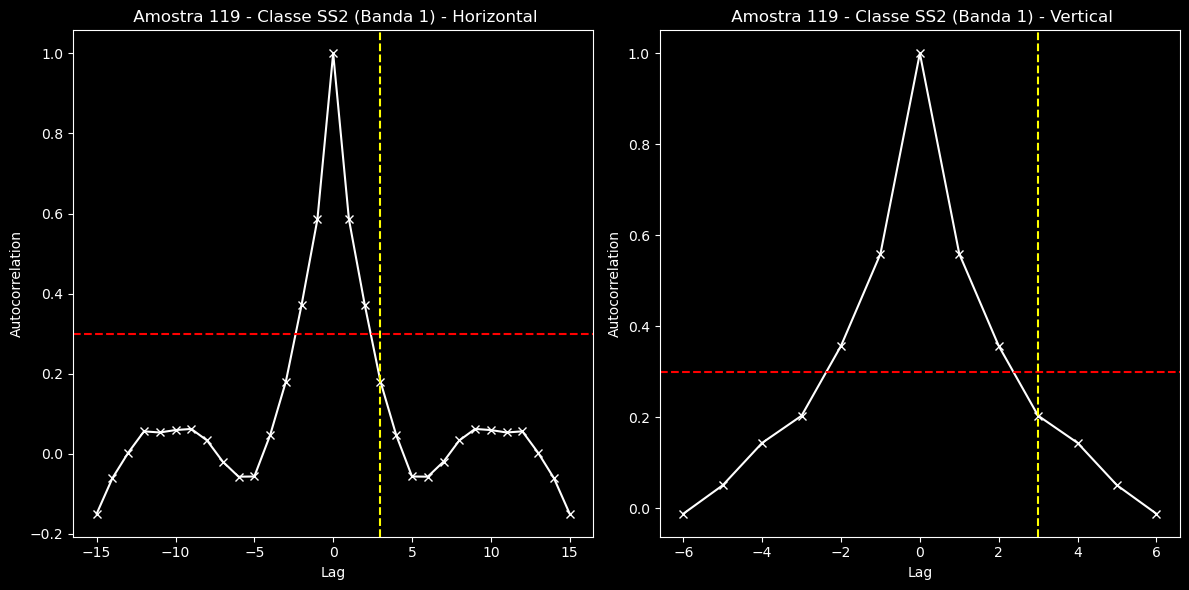

Lags Horizontais [2, 3, 4, 4, 3, 2, 2, 3, 5, 3]
Lags Verticais [4, 3, 3, 4, 3, 3, 1, 3, 5, 3]
Lag mediano horizontal para a classe SS2: 3.0
Lag máximo horizontal para a classe SS2: 5
Lag mediano vertical para a classe SS2: 3.0
Lag máximo vertical para a classe SS2: 4
-----------------------------------------------------------------------------------
Processando classe SS3.


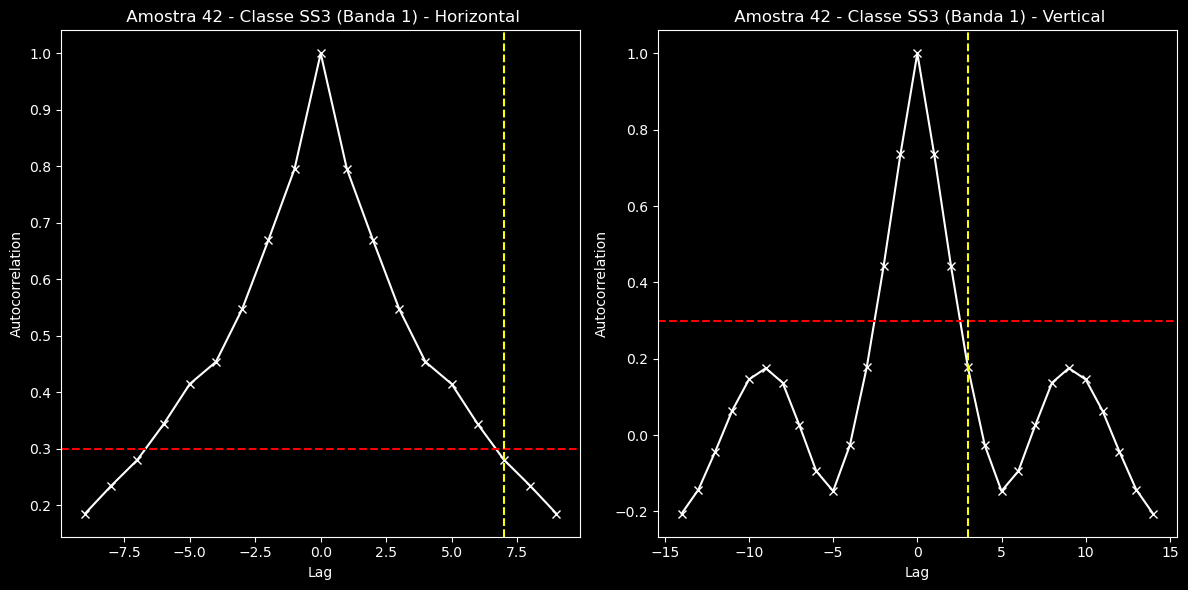

Erro ao calcular lags do polígono 42: '>' not supported between instances of 'float' and 'NoneType'
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Gabriel\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Gabriel\AppData\Local\Temp\ipykernel_6216\297929723.py", line 27, in <module>
    lag_horizontal, lag_vertical = autocorrelation(clipped_raster,title, target_correlation = 0.3 ,  plot = True)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gabriel\AppData\Local\Temp\ipykernel_6216\3874122535.py", line -1, in autocorrelation
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Gabriel\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gabriel\anaconda3

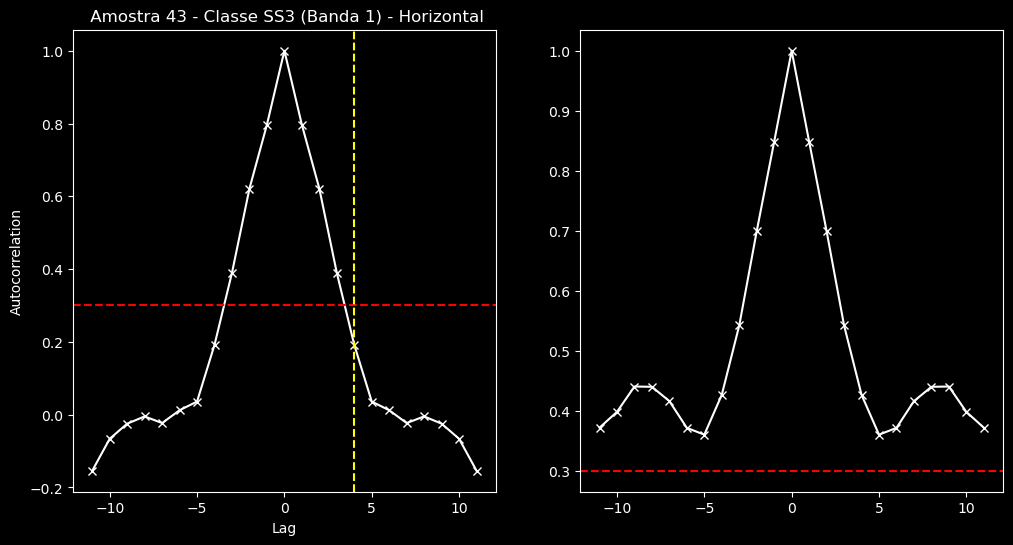

In [46]:
# Agrupando os polígonos por classe
# OBS.:Shapefile DEVE conter uma coluna com o nome 'Classe'
poligonos_por_classe = df_boundings.groupby('Classe')

# Dicionário para armazenar os lags horizontais e verticais por classe
# Lista para armazenar os dicionários por banda

lags_por_banda = []

# Looping por banda 
for banda in range(1,3):
    print(f'Processameto banda {banda}')
    lags_por_classe = {}

    # Looping por classe
    for classe, poligonos in poligonos_por_classe:
        lags_horizontais = []  # Lista para armazenar lags horizontais de cada polígono na classe atual
        lags_verticais = []  # Lista para armazenar lags verticais de cada polígono na classe atual
        print(f"Processando classe {classe}.")

        # Looping por amostra
        for _, row in poligonos.iterrows():
            try: # Pode não encontrar um lag minínimo para uma correlação abaixo do limiar dado
                clipped_raster = extrair_dados_raster(row['geometry'], masked_raster_path, banda)
                if clipped_raster is not None:
                    title = f" Amostra {row.name + 1} - Classe {classe} (Banda {banda})" #título do plot, caso ele seja TRUE
                    lag_horizontal, lag_vertical = autocorrelation(clipped_raster,title, target_correlation = 0.3 ,  plot = True) 
                    if lag_horizontal is not None:
                        lags_horizontais.append(lag_horizontal)
                    if lag_vertical is not None:
                        lags_verticais.append(lag_vertical)
            except Exception as e:
                print(f"Erro ao calcular lags do polígono {row.name}: {e}")
                continue  # Pula para o próximo polígono dentro da mesma classe
        print(f"Lags Horizontais {lags_horizontais}")
        print(f"Lags Verticais {lags_verticais}")

        IQR = True
    # Calculo dos lag medianos e máximos nas direções horizontal e vertical para a classe atual (se houver lags válidos)
        if lags_horizontais:
            lag_mediano_horizontal = np.median(lags_horizontais)
            lag_max_horizontal = find_max_lag_without_outliers(lags_horizontais, IQR = IQR)
            print(f"Lag mediano horizontal para a classe {classe}: {lag_mediano_horizontal}")
            print(f"Lag máximo horizontal para a classe {classe}: {lag_max_horizontal}")
        else:
            print(f"Não foram encontrados lags horizontais válidos para a classe {classe}")
            lag_mediano_horizontal = None
            lag_max_horizontal = None

        if lags_verticais:
            lag_mediano_vertical = np.median(lags_verticais)
            lag_max_vertical = find_max_lag_without_outliers(lags_verticais, IQR = IQR)
            print(f"Lag mediano vertical para a classe {classe}: {lag_mediano_vertical}")
            print(f"Lag máximo vertical para a classe {classe}: {lag_max_vertical}")
        else:
            print(f"Não foram encontrados lags verticais válidos para a classe {classe}")
            lag_mediano_vertical = None
            lag_max_vertical = None
        print('-----------------------------------------------------------------------------------')
        lags_por_classe[classe] = {
            'lags_horizontais': lags_horizontais,
            'lag_mediano_horizontal': lag_mediano_horizontal,
            'lags_verticais': lags_verticais,
            'lag_mediano_vertical': lag_mediano_vertical,
            'lag_max_horizontal': lag_max_horizontal,
            'lag_max_vertical': lag_max_vertical
        }
    
    lags_por_banda.append(lags_por_classe)
    print('----------------------------------------------------------------------------------------')
    print(f'Fim do calculo do lag para banda {banda}')
    print('----------------------------------------------------------------------------------------')

In [43]:
pd.DataFrame(lags_por_banda[0])

AP  \
lags_horizontais        [1, 4, 3, 1, 4, 2, 3, 8, 3, 1, 3, 3, 4, 2]   
lag_mediano_horizontal                                         3.0   
lags_verticais            [1, 3, 2, 4, 3, 4, 5, 4, 1, 3, 10, 4, 2]   
lag_mediano_vertical                                           3.0   
lag_max_horizontal                                               4   
lag_max_vertical                                                 5   

                                                                       CL  \
lags_horizontais            [4, 4, 4, 4, 1, 3, 4, 3, 4, 3, 4, 5, 3, 3, 4]   
lag_mediano_horizontal                                                4.0   
lags_verticais          [5, 5, 4, 3, 7, 1, 3, 5, 5, 3, 5, 3, 3, 2, 4, ...   
lag_mediano_vertical                                                  4.0   
lag_max_horizontal                                                      5   
lag_max_vertical                                                        7   

                                              FD                        FP  \
lags_horizontais        [4, 3, 4, 3, 3, 4, 3, 4]     [4, 4, 2, 2, 2, 2, 4]   
lag_mediano_horizontal                       3.5                       2.0   
lags_verticais          [4, 3, 4, 3, 3, 3, 4, 5]  [4, 4, 1, 2, 2, 3, 4, 4]   
lag_mediano_vertical                         3.5                       3.5   
lag_max_horizontal                             4                         4   
lag_max_vertical                               5                         4   

                                                                   PL  \
lags_horizontais        [4, 3, 5, 4, 3, 8, 3, 4, 8, 4, 3, 3, 3, 2, 3]   
lag_mediano_horizontal                                            3.0   
lags_verticais             [4, 5, 5, 3, 3, 3, 4, 4, 4, 3, 3, 3, 2, 1]   
lag_mediano_vertical                                              3.0   
lag_max_horizontal                                                  5   
lag_max_vertical                                                    5   

                                                                   PS  \
lags_horizontais           [4, 4, 3, 4, 3, 3, 4, 6, 4, 4, 5, 6, 3, 4]   
lag_mediano_horizontal                                            4.0   
lags_verticais          [4, 8, 5, 3, 6, 4, 4, 5, 5, 4, 5, 3, 3, 5, 4]   
lag_mediano_vertical                                              4.0   
lag_max_horizontal                                                  5   
lag_max_vertical                                                    6   

                                                                       SE  \
lags_horizontais        [5, 1, 1, 2, 2, 19, 4, 9, 5, 5, 5, 4, 4, 6, 4, 7]   
lag_mediano_horizontal                                                4.5   
lags_verticais              [4, 1, 1, 1, 1, 7, 5, 6, 4, 3, 4, 3, 3, 3, 5]   
lag_mediano_vertical                                                  3.0   
lag_max_horizontal                                                      7   
lag_max_vertical                                                        7   

                                                      SS1  \
lags_horizontais        [5, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3]   
lag_mediano_horizontal                                3.0   
lags_verticais          [4, 2, 2, 4, 4, 4, 2, 3, 5, 2, 5]   
lag_mediano_vertical                                  4.0   
lag_max_horizontal                                      3   
lag_max_vertical                                        5   

                                                      SS2  \
lags_horizontais        [2, 3, 4, 4, 3, 2, 2, 3, 3, 5, 3]   
lag_mediano_horizontal                                3.0   
lags_verticais          [4, 3, 3, 4, 4, 3, 3, 1, 3, 5, 3]   
lag_mediano_vertical                                  3.0   
lag_max_horizontal                                      5   
lag_max_vertical                                        5   

                                                SS3  
lags_horizon

In [44]:
pd.DataFrame(lags_por_banda[1])

AP  \
lags_horizontais        [4, 4, 3, 2, 3, 2, 2, 6, 4, 4, 3, 3, 2, 5]   
lag_mediano_horizontal                                         3.0   
lags_verticais          [4, 4, 4, 3, 2, 4, 3, 3, 4, 3, 4, 9, 5, 4]   
lag_mediano_vertical                                           4.0   
lag_max_horizontal                                               6   
lag_max_vertical                                                 5   

                                                                       CL  \
lags_horizontais        [1, 9, 5, 4, 6, 3, 3, 4, 4, 1, 3, 4, 3, 4, 3, ...   
lag_mediano_horizontal                                                4.0   
lags_verticais          [2, 3, 4, 3, 8, 3, 3, 6, 3, 3, 4, 3, 3, 2, 4, ...   
lag_mediano_vertical                                                  3.0   
lag_max_horizontal                                                      5   
lag_max_vertical                                                        5   

                                              FD                        FP  \
lags_horizontais        [4, 4, 4, 4, 2, 1, 3, 3]  [2, 3, 3, 2, 2, 3, 5, 3]   
lag_mediano_horizontal                       3.5                       3.0   
lags_verticais          [4, 4, 4, 3, 2, 1, 3, 3]  [1, 3, 3, 2, 2, 3, 5, 4]   
lag_mediano_vertical                         3.0                       3.0   
lag_max_horizontal                             4                         3   
lag_max_vertical                               4                         5   

                                                                   PL  \
lags_horizontais        [5, 3, 6, 3, 1, 5, 3, 4, 5, 5, 4, 3, 3, 3, 4]   
lag_mediano_horizontal                                            4.0   
lags_verticais             [5, 4, 6, 3, 1, 4, 3, 4, 3, 3, 3, 3, 3, 2]   
lag_mediano_vertical                                              3.0   
lag_max_horizontal                                                  6   
lag_max_vertical                                                    5   

                                                                 PS  \
lags_horizontais         [4, 4, 3, 2, 6, 5, 4, 4, 4, 3, 4, 4, 3, 4]   
lag_mediano_horizontal                                          4.0   
lags_verticais          [5, 7, 4, 3, 5, 5, 4, 4, 4, 5, 10, 3, 3, 4]   
lag_mediano_vertical                                            4.0   
lag_max_horizontal                                                5   
lag_max_vertical                                                  5   

                                                                      SE  \
lags_horizontais              [4, 2, 3, 2, 9, 4, 4, 4, 5, 2, 6, 7, 3, 3]   
lag_mediano_horizontal                                               4.0   
lags_verticais          [5, 1, 2, 1, 5, 6, 5, 4, 4, 5, 4, 3, 3, 3, 3, 4]   
lag_mediano_vertical                                                 4.0   
lag_max_horizontal                                                     7   
lag_max_vertical                                                       6   

                                                      SS1  \
lags_horizontais           [3, 2, 5, 4, 4, 3, 3, 2, 3, 3]   
lag_mediano_horizontal                                3.0   
lags_verticais          [3, 2, 2, 4, 3, 5, 2, 3, 6, 3, 6]   
lag_mediano_vertical                                  3.0   
lag_max_horizontal                                      4   
lag_max_vertical                                        6   

                                                         SS2  \
lags_horizontais        [3, 3, 4, 4, 2, 3, 3, 4, 4, 1, 4, 5]   
lag_mediano_horizontal                                   3.5   
lags_verticais             [4, 4, 4, 3, 3, 5, 3, 5, 4, 1, 3]   
lag_mediano_vertical                                     4.0   
lag_max_horizontal                                         5   
lag_max_vertical                                           5   

                                                SS3  
lags_horizon

In [45]:
# Dicionário para armazenar os maiores lags
maiores_lags = {}

# Iterando sobre cada dicionário da lista referente aos lags nas polarizações HV e HH
for dicionario in lags_por_banda:
    for classe, dados in dicionario.items():
        # Conferindo se a classe já foi verificada anteriormente
        if classe not in maiores_lags:
            maiores_lags[classe] = {'lag_max_horizontal': 0, 'lag_max_vertical': 0}
            
        # Atualiza os maiores lags ENTRE AS BANDAS
        maiores_lags[classe]['lag_max_horizontal'] = max(maiores_lags[classe]['lag_max_horizontal'], dados['lag_max_horizontal'])
        maiores_lags[classe]['lag_max_vertical'] = max(maiores_lags[classe]['lag_max_vertical'], dados['lag_max_vertical'])

print(pd.DataFrame(maiores_lags))

                    AP  CL  FD  FP  PL  PS  SE  SS1  SS2  SS3
lag_max_horizontal   6   5   4   4   6   5   7    4    5    4
lag_max_vertical     5   7   5   5   5   6   7    6    5    5
